# Mimid :  Inferring Grammars

* Code for subjects [here](#Our-subject-programs)
* Evaluation starts [here](#Evaluation)
  * The evaluation on specific subjects starts [here](#Subjects)
    * [CGIDecode](#CGIDecode)
    * [Calculator](#Calculator)
    * [MathExpr](#MathExpr)
    * [URLParse](#URLParse)
    * [Microjson](#Microjson)
* Results are [here](#Results)
* Recovering parse tree from a recognizer is [here](#Using-a-Recognizer-(not-a-Parser))
* Recovering parse tree from parser combinators is [here](#Parsing-with-Parser-Combinators)
* Recovering parse tree from PEG parer is [here](#Parsing-with-PEG-Parser)

Please note that a complete run can take an hour and a half to complete.

We start with a few Jupyter magics that let us specify examples inline, that can be turned off if needed for faster execution. Switch `TOP to False` if you do not want examples to complete.

In [1]:
TOP = __name__ == '__main__'

The magics we use are `%%var` and `%top`. The `%%var` lets us specify large strings such as file contents directly without too many escapes. The `%top` helps with examples.

In [2]:
from IPython.core.magic import  (Magics, magics_class, cell_magic, line_magic, line_cell_magic)
class B(dict):
    def __getattr__(self, name):
        return self.__getitem__(name)
@magics_class
class MyMagics(Magics):
    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._vars = B()
        shell.user_ns['VARS'] = self._vars

    @cell_magic
    def var(self, line, cell):
        self._vars[line.strip()] = cell.strip()
 
    @line_cell_magic
    def top(self, line, cell=None):
        if TOP:
            if cell is None:
                cell = line
            ip = get_ipython()
            res = ip.run_cell(cell)

get_ipython().register_magics(MyMagics)

## Verify System Version

In [3]:
import sys

Parts of the program, especially the subprocess execution using `do()` requires the new flags in `3.7`. I am not sure if the taints will work on anything above.

In [4]:
%top assert sys.version_info[0:2] == (3, 7)

In [5]:
import subprocess
from subprocess import run

In [6]:
import os
import json

We keep a log of all system commands executed for easier debugging at `./build/do.log` when debug is enabled.

In [7]:
DEBUG = False

In [8]:
class O:
    def __init__(self, **keys): self.__dict__.update(keys)
    def __repr__(self): return str(self.__dict__)

In [9]:
CMD_TIMEOUT=60*60*24

In [10]:
def do(command, env=None, shell=False, log=False, inputv=None, timeout=CMD_TIMEOUT, **args):
    result = None
    if inputv:
        result = subprocess.Popen(command,
            stdin = subprocess.PIPE,
            stdout = subprocess.PIPE,
            stderr = subprocess.STDOUT,
            shell = shell,
            env=dict(os.environ, **({} if env is None else env))
        )
        result.stdin.write(inputv)
        stdout, stderr = result.communicate(timeout=timeout)
    else:
        result = subprocess.Popen(command,
            stdout = subprocess.PIPE,
            stderr = subprocess.STDOUT,
            shell = shell,
            env=dict(os.environ, **({} if env is None else env))
        )
        stdout, stderr = result.communicate(timeout=timeout)
    if log:
         with open('build/do.log', 'a+') as f:
            print(json.dumps({'cmd':command,
                              'env':env,
                              'exitcode':result.returncode}), env,
                  flush=True, file=f)
    stdout = '' if stdout is None else stdout.decode()
    stderr = '' if stderr is None else stderr.decode()
    result.kill()
    return O(returncode=result.returncode, stdout=stdout, stderr=stderr)

In [11]:
import random

Try to ensure replicability of measurements.

In [12]:
random.seed(0)

Note that this notebook was tested on `Ubuntu 18.04.4 LTS`. In particular, I do not know if everything will work on `Windows`.

In [13]:
import shutil

In [14]:
%%top
if shutil.which('lsb_release'):
    res = do(['lsb_release', '-d']).stdout
elif shutil.which('sw_vers'):
    res = do(['sw_vers']).stdout
else:
    assert False
print(res)

Description:	Ubuntu 18.04.3 LTS



In [15]:
%top print(do(['jupyter', '--version']).stdout)

jupyter core     : 4.6.3
jupyter-notebook : 6.0.3
qtconsole        : 4.7.4
ipython          : 7.15.0
ipykernel        : 5.3.0
jupyter client   : 6.1.3
jupyter lab      : not installed
nbconvert        : 5.6.1
ipywidgets       : 7.5.1
nbformat         : 5.0.6
traitlets        : 4.3.3



## Install Prerequisites

We want to avoid reinstalling things on each run. So, we define a variable `INSTALL` that should be made true for installations to take place. Use it only during the first run.

In [16]:
INSTALL = False

In [17]:
def install(fn):
    if INSTALL:
        return fn()

Our code is based on the utilities provided by the [Fuzzingbook](http://fuzzingbook.org). Note that the measurements on time and precision in paper were based on Fuzzingbook `0.0.7`. During the development, we found a few bugs in Autogram, which we communicated back, which resulted in a new version of Fuzzingbook `0.8.0`.

The fixed *Autogram* implementation of the *Fuzzingbook* has better precision rates for *Autogram*, and timing for grammar generation. However, these numbers still fall short of *Mimid* for most grammars. Further, the grammars generated by *Autogram* are still enumerative. That is, rather than producing a context free grammar, it simply appends input strings as alternates to the `<START>` nonterminal. This again results in bad recall numbers as before. Hence, it does not change our main points. During the remainder of this notebook, we use the `0.8.0` version of the Fuzzingbook.

First we define `pip_install()`, a helper to silently install required dependencies.

In [18]:
def pip_install(v):
    return do(['pip', 'install', '-qqq', *v.split(' ')]).returncode

In [19]:
%top install(lambda: pip_install('fuzzingbook==0.8.1'))

We now need to update the Parser to the current version (not published in pypy).

In [20]:
!file Parser.py

Parser.py: Python script, ASCII text executable


In [21]:
import fuzzingbook.Parser as P

In [22]:
!cp Parser.py {P.__file__}

cp: cannot create regular file '/usr/local/lib/python3.7/dist-packages/fuzzingbook/Parser.py': Permission denied


In [23]:
import fuzzingbook.GrammarMiner as G

In [24]:
!cp GrammarMiner.py {G.__file__}

cp: cannot create regular file '/usr/local/lib/python3.7/dist-packages/fuzzingbook/GrammarMiner.py': Permission denied


This should work before we proceed. If not, restart the server.

In [25]:
parser = P.IterativeEarleyParser({'<START>': [['start']]}, start_symbol='<START>', canonical=True)

Our external dependencies other than `fuzzingbook` are as follows.

In [26]:
%top install(lambda: pip_install('astor graphviz scipy'))

**IMPORTANT:** Restart the jupyter server after installation of dependencies and extensions.

### Recommended Extensions

We recommend the following jupyter notebook extensions:

In [27]:
%top install(lambda: pip_install('jupyter_contrib_nbextensions jupyter_nbextensions_configurator'))

In [28]:
%top install(lambda: do(['jupyter','contrib','nbextension','install', '--sys-prefix']).returncode)

In [29]:
def nb_enable(v): return do(['jupyter','nbextension','enable',v]).returncode

In [30]:
%top install(lambda: do(['jupyter','nbextensions_configurator','enable']).returncode)

#### Table of contents

Please install this extension. The navigation in the notebook is rather hard without this installed.

In [31]:
%top install(lambda: nb_enable('toc2/main'))

#### Collapsible headings

Again, do install this extension. This will let you fold away those sections that you do not have an immediate interest in.

In [32]:
%top install(lambda: nb_enable('collapsible_headings/main'))

#### Code folding
Very helpful for hiding away source contents of libraries that are not for grammar recovery.

In [33]:
%top install(lambda: nb_enable('codefolding/main'))

### Cleanup

To make runs faster, we cache quite a lot of things. Remove `build` if you change code or samples.

In [34]:
%top do(['rm', '-rf','build']).returncode

0

### Magic for cell contents

As we mentioned before `%%var` defines a multi line embedded string that is accessible from Python.

In [35]:
%%var Mimid
# [(
Testing Mimid
# )]

In [36]:
%top VARS['Mimid']

'# [(\nTesting Mimid\n# )]'

## The fuzzer

We use the fuzer to generate inputs when needed.

In [37]:
import string
ASCII_MAP = {
        '[__WHITESPACE__]': string.whitespace,
        '[__DIGIT__]': string.digits,
        '[__ASCII_LOWER__]': string.ascii_lowercase,
        '[__ASCII_UPPER__]': string.ascii_uppercase,
        '[__ASCII_PUNCT__]': string.punctuation,
        '[__ASCII_LETTER__]': string.ascii_letters,
        '[__ASCII_ALPHANUM__]': string.ascii_letters + string.digits,
        '[__ASCII_PRINTABLE__]': string.printable
        }

class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

FUZZRANGE = 10

class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def nonterminals(self, rule):
        return [t for t in rule if is_nt(t)]

    def iter_gen_key(self, key, max_depth):
        def get_def(t):
            if t in ASCII_MAP:
                return [random.choice(ASCII_MAP[t]), []]
            elif t and t[-1] == '+' and t[0:-1] in ASCII_MAP:
                num = random.randrange(FUZZRANGE) + 1
                val = [random.choice(ASCII_MAP[t[0:-1]]) for i in range(num)]
                return [''.join(val), []]
            elif is_nt(t):
                return [t, None]
            else:
                return [t, []]

        cheap_grammar = {}
        for k in self.cost:
            # should we minimize it here? We simply avoid infinities
            rules = self.grammar[k]
            min_cost = min([self.cost[k][str(r)] for r in rules])
            #grammar[k] = [r for r in grammar[k] if self.cost[k][str(r)] == float('inf')]
            cheap_grammar[k] = [r for r in self.grammar[k] if self.cost[k][str(r)] == min_cost]

        root = [key, None]
        queue = [(0, root)]
        while queue:
            # get one item to expand from the queue
            (depth, item), *queue = queue
            key = item[0]
            if item[1] is not None: continue
            grammar = self.grammar if depth < max_depth else cheap_grammar
            chosen_rule = random.choice(grammar[key])
            expansion = [get_def(t) for t in chosen_rule]
            item[1] = expansion
            for t in expansion: queue.append((depth+1, t))
            #print("Fuzz: %s" % key, len(queue), file=sys.stderr)
        #print(file=sys.stderr)
        return root
    
    def gen_key(self, key, depth, max_depth):
        if key in ASCII_MAP:
            return (random.choice(ASCII_MAP[key]), [])
        if key and key[-1] == '+' and key[0:-1] in ASCII_MAP:
            m = random.randrange(FUZZRANGE) + 1
            return (''.join([random.choice(ASCII_MAP[key[0:-1]]) for i in range(m)]), [])
        if key not in self.grammar: return (key, [])
        if depth > max_depth:
            #return self.gen_key_cheap_iter(key)
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return (key, self.gen_rule(random.choice(rules), depth+1, max_depth))

    def gen_rule(self, rule, depth, max_depth):
        return [self.gen_key(token, depth, max_depth) for token in rule]

    def fuzz(self, key='<start>', max_depth=10):
        return tree_to_str(self.iter_gen_key(key=key, max_depth=max_depth))

    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
            if len(grammar[k]):
                assert len([v for v in cost[k] if v != float('inf')]) > 0
        return cost

## Our subject programs

Note that our taint tracking implementation is incomplete in that only some of the functions in Python are proxied to preserve taints. Hence, we modify source slightly where necessary to use the proxied functions without affecting the evaluation of the grammar inferencing algorithm.

### Calculator.py

This is a really simple calculator written in text book recursive descent style. Note that I have used `list()` in a few places to help out with taint tracking. This is due to the limitations of my taint tracking prototype. It can be fixed if required by simple AST walkers or better taint trackers.

In [38]:
%%var calc_src
# [(
import string

def is_digit(i):
    return i in string.digits
    
def parse_num(s,i):
    n = ''
    while s[i:] and is_digit(s[i]):
        n += s[i]
        i = i +1
    return i,n

def parse_paren(s, i):
    assert s[i] == '('
    i, v = parse_expr(s, i+1)
    if s[i:] == '':
        raise Exception(s, i)
    assert s[i] == ')'
    return i+1, v

def parse_expr(s, i = 0):
    expr = []
    is_op = True
    while s[i:]:
        c = s[i]
        if c in string.digits:
            if not is_op: raise Exception(s,i)
            i,num = parse_num(s,i)
            expr.append(num)
            is_op = False
        elif c in ['+', '-', '*', '/']:
            if is_op: raise Exception(s,i)
            expr.append(c)
            is_op = True
            i = i + 1
        elif c == '(':
            if not is_op: raise Exception(s,i)
            i, cexpr = parse_paren(s, i)
            expr.append(cexpr)
            is_op = False
        elif c == ')':
            break
        else:
            raise Exception(s,i)
    if is_op:
        raise Exception(s,i)
    return i, expr

def main(arg):
    return parse_expr(arg)
# )]

### Mathexpr.py

Originally from [here]( https://github.com/louisfisch/mathematical-expressions-parser). The mathexpr is much more complicated than our `calculator` and supports advanced functionalities such as predefined functions and variables.

In [39]:
%%var mathexpr_src
# [(
import math

_CONSTANTS = {
    'pi' : math.pi,
    'e' : math.e,
    'phi': (1 + 5 ** .5) / 2
}

_FUNCTIONS = {
    'abs': abs,
    'acos': math.acos,
    'asin': math.asin,
    'atan': math.atan,
    'atan2': math.atan2,
    'ceil': math.ceil,
    'cos': math.cos,
    'cosh': math.cosh,
    'degrees': math.degrees,
    'exp': math.exp,
    'fabs': math.fabs,
    'floor': math.floor,
    'fmod': math.fmod,
    'frexp': math.frexp,
    'hypot': math.hypot,
    'ldexp': math.ldexp,
    'log': math.log,
    'log10': math.log10,
    'modf': math.modf,
    'pow': math.pow,
    'radians': math.radians,
    'sin': math.sin,
    'sinh': math.sinh,
    'sqrt': math.sqrt,
    'tan': math.tan,
    'tanh': math.tanh
}

class Parser:
    def __init__(self, string, vars = None):
        self.string = string
        self.index = 0
        self.vars = {} if vars == None else vars.copy()
        for constant in _CONSTANTS.keys():
            if self.vars.get(constant) != None:
                raise Exception("Cannot redefine the value of " + constant)

    def getValue(self):
        value = self.parseExpression()
        self.skipWhitespace()
        
        if self.hasNext():
            raise Exception(
                "Unexpected character found: '" + self.peek() + "' at index " + str(self.index)
            )
        return value

    def peek(self):
        return self.string[self.index:self.index + 1]

    def hasNext(self):
        return self.index < len(self.string)

    def isNext(self, value):
        return self.string[self.index:self.index+len(value)] == value

    def popIfNext(self, value):
        if self.isNext(value):
            self.index += len(value)
            return True
        return False

    def popExpected(self, value):
        if not self.popIfNext(value):
            raise Exception("Expected '" + value + "' at index " + str(self.index))


    def skipWhitespace(self):
        while self.hasNext():
            if self.peek() in ' \t\n\r':
                self.index += 1
            else:
                return

    def parseExpression(self):
        return self.parseAddition()
    
    def parseAddition(self):
        values = [self.parseMultiplication()]
        
        while True:
            self.skipWhitespace()
            char = self.peek()
            
            if char == '+':
                self.index += 1
                values.append(self.parseMultiplication())
            elif char == '-':
                self.index += 1
                values.append(-1 * self.parseMultiplication())
            else:
                break
        
        return sum(values)

    def parseMultiplication(self):
        values = [self.parseParenthesis()]
            
        while True:
            self.skipWhitespace()
            char = self.peek()
                
            if char == '*':
                self.index += 1
                values.append(self.parseParenthesis())
            elif char == '/':
                div_index = self.index
                self.index += 1
                denominator = self.parseParenthesis()
                     
                if denominator == 0:
                    raise Exception(
                        "Division by 0 kills baby whales (occured at index " + str(div_index) + ")"
                    )
                values.append(1.0 / denominator)
            else:
                break
                     
        value = 1.0
        
        for factor in values:
            value *= factor
        return value

    def parseParenthesis(self):
        self.skipWhitespace()
        char = self.peek()
        
        if char == '(':
            self.index += 1
            value = self.parseExpression()
            self.skipWhitespace()
            
            if self.peek() != ')':
                raise Exception(
                    "No closing parenthesis found at character " + str(self.index)
                )
            self.index += 1
            return value
        else:
            return self.parseNegative()

    def parseArguments(self):
        args = []
        self.skipWhitespace()
        self.popExpected('(')
        while not self.popIfNext(')'):
            self.skipWhitespace()
            if len(args) > 0:
                self.popExpected(',')
                self.skipWhitespace()
            args.append(self.parseExpression())
            self.skipWhitespace()
        return args

    def parseNegative(self):
        self.skipWhitespace()
        char = self.peek()
        
        if char == '-':
            self.index += 1
            return -1 * self.parseParenthesis()
        else:
            return self.parseValue()

    def parseValue(self):
        self.skipWhitespace()
        char = self.peek()
        
        if char in '0123456789.':
            return self.parseNumber()
        else:
            return self.parseVariable()
 
    def parseVariable(self):
        self.skipWhitespace()
        var = []
        while self.hasNext():
            char = self.peek()
            
            if char.lower() in '_abcdefghijklmnopqrstuvwxyz0123456789':
                var.append(char)
                self.index += 1
            else:
                break
        #s = ''
        #for a in var:
        #    s += a # CHANGE from ORIGINAL to preserve taints. We need to taints.w__ join() calls.
        var = ''.join(var)
        
        function = _FUNCTIONS.get(var.lower())
        if function != None:
            args = self.parseArguments()
            return float(function(*args))
        
        constant = _CONSTANTS.get(var.lower())
        if constant != None:
            return constant

        value = self.vars.get(var, None)
        if value != None:
            return float(value)
            
        raise Exception("Unrecognized variable: '" + var + "'")

    def parseNumber(self):
        self.skipWhitespace()
        strValue = ''
        decimal_found = False
        char = ''

        while self.hasNext():
            char = self.peek()            
            
            if char == '.':
                if decimal_found:
                    raise Exception(
                        "Found an extra period in a number at character " + str(self.index) + ". Are you European?"
                    )
                decimal_found = True
                strValue += '.'
            elif char in '0123456789':
                strValue += char
            else:
                break
            self.index += 1

        if len(strValue) == 0:
            if char == '':
                raise Exception("Unexpected end found")
            else:
                raise Exception(
                    "I was expecting to find a number at character " + str(self.index) + " but instead I found a '" + char + "'. What's up with that?")

        return float(strValue)
import string
def main(arg):
    p = Parser(arg, {a:ord(a) for a in string.ascii_lowercase if a != 'e'})
    p.getValue()
# )]

### Microjson.py
The microjson is a complete pure python implementation of JSON parser, that was obtained from from [here](https://github.com/phensley/microjson). Note that we use `myio` which is an instrumented version of the original `io` to preserve taints.

In [40]:
%%var microjson_src
# [(
# microjson - Minimal JSON parser/emitter for use in standalone scripts.
# No warranty. Free to use/modify as you see fit. Trades speed for compactness.
# Send ideas, bugs, simplifications to http://github.com/phensley
# Copyright (c) 2010 Patrick Hensley <spaceboy@indirect.com>

# std
import math
import myio as io
import types


# the '_from_json_number' function returns either float or long.
__pychecker__ = 'no-returnvalues'

# character classes
WS = ' ' # ''.join([' ','\t','\r','\n','\b','\f'])
DIGITS = ''.join([str(i) for i in range(0, 10)])
NUMSTART = DIGITS + ''.join(['.','-','+'])
NUMCHARS = NUMSTART + ''.join(['e','E'])
ESC_MAP = {'n':'\n','t':'\t','r':'\r','b':'\b','f':'\f'}
REV_ESC_MAP = dict([(_v,_k) for _k,_v in list(ESC_MAP.items())] + [('"','"')])

# error messages
E_BYTES = 'input string must be type str containing ASCII or UTF-8 bytes'
E_MALF = 'malformed JSON data'
E_TRUNC = 'truncated JSON data'
E_BOOL = 'expected boolean'
E_NULL = 'expected null'
E_LITEM = 'expected list item'
E_DKEY = 'expected key'
E_COMMA = 'missing comma between elements'
E_COLON = 'missing colon after key'
E_EMPTY = 'found empty string, not valid JSON data'
E_BADESC = 'bad escape character found'
E_UNSUPP = 'unsupported type "%s" cannot be JSON-encoded'
E_BADFLOAT = 'cannot emit floating point value "%s"'

NEG_INF = float('-inf')
POS_INF = float('inf')


class JSONError(Exception):
    def __init__(self, msg, stm=None, pos=0):
        if stm:
            msg += ' at position %d, "%s"' % (pos, repr(stm.substr(pos, 32)))
        Exception.__init__(self, msg)


class JSONStream:

    # no longer inherit directly from StringIO, since we only want to
    # expose the methods below and not allow direct access to the
    # underlying stream.

    def __init__(self, data):
        self._stm = io.StringIO(data)

    @property
    def pos(self):
        return self._stm.tell()

    @property
    def len(self):
        return len(self._stm.getvalue())

    def getvalue(self):
        return self._stm.getvalue()

    def skipspaces(self):
        "post-cond: read pointer will be over first non-WS char"
        self._skip(lambda c: not c in WS)

    def _skip(self, stopcond):
        while True:
            c = self.peek()
            if stopcond(c) or c == '':
                break
            self.next()

    def next(self, size=1):
        return self._stm.read(size)

    def next_ord(self):
        return ord(next(self))

    def peek(self):
        if self.pos == self.len:
            return self.getvalue()[self.pos:]
        return self.getvalue()[self.pos]

    def substr(self, pos, length):
        return self.getvalue()[pos:pos+length]


def _decode_utf8(c0, stm):
    c0 = ord(c0)
    r = 0xFFFD      # unicode replacement character
    nc = stm.next_ord

    # 110yyyyy 10zzzzzz
    if (c0 & 0xE0) == 0xC0:
        r = ((c0 & 0x1F) << 6) + (nc() & 0x3F)

    # 1110xxxx 10yyyyyy 10zzzzzz
    elif (c0 & 0xF0) == 0xE0:
        r = ((c0 & 0x0F) << 12) + ((nc() & 0x3F) << 6) + (nc() & 0x3F)

    # 11110www 10xxxxxx 10yyyyyy 10zzzzzz
    elif (c0 & 0xF8) == 0xF0:
        r = ((c0 & 0x07) << 18) + ((nc() & 0x3F) << 12) + \
            ((nc() & 0x3F) << 6) + (nc() & 0x3F)
    return chr(r)


def decode_escape(c, stm):
    # whitespace
    v = ESC_MAP.get(c, None)
    if v is not None:
        return v

    # plain character
    elif c != 'u':
        return c

    # decode unicode escape \u1234
    sv = 12
    r = 0
    for _ in range(0, 4):
        r |= int(stm.next(), 16) << sv
        sv -= 4
    return chr(r)


def _from_json_string(stm):
    # skip over '"'
    stm.next()
    r = ''
    while True:
        c = stm.next()
        if c == '':
            raise JSONError(E_TRUNC, stm, stm.pos - 1)
        elif c == '\\':
            c = stm.next()
            r += decode_escape(c, stm)
        elif c == '"':
            return r
        elif c in [str(i) for i in range(127, 256)]:
            r += _decode_utf8(c, stm)
        else:
            r += c


def _from_json_fixed(stm, expected, value, errmsg):
    off = len(expected)
    pos = stm.pos
    res = stm.substr(pos, off)
    if res == expected:
        stm.next(off)
        return res
    raise JSONError(errmsg, stm, pos)


def _from_json_number(stm):
    # Per rfc 4627 section 2.4 '0' and '0.1' are valid, but '01' and
    # '01.1' are not, presumably since this would be confused with an
    # octal number.  This rule is not enforced.
    is_float = 0
    saw_exp = 0
    pos = stm.pos
    while True:
        c = stm.peek()
        if not c: break

        if not c in NUMCHARS:
            break
        elif c == '-' and not saw_exp:
            pass
        elif c in '.eE':
            is_float = 1
            if c in 'eE':
                saw_exp = 1

        stm.next()

    s = stm.substr(pos, stm.pos - pos)
    if is_float:
        return s
    return s


def _from_json_list(stm):
    # skip over '['
    stm.next()
    result = []
    pos = stm.pos
    comma = False
    while True:
        stm.skipspaces()
        c = stm.peek()
        if c == '':
            raise JSONError(E_TRUNC, stm, pos)

        elif c == ']':
            stm.next()
            return result

        elif c == ',':
            if not result:
                raise JSONError(E_TRUNC, stm, pos)
            if comma:
                raise JSONError(E_TRUNC, stm, pos)
            comma = True
            stm.next()
            result.append(_from_json_raw(stm))
            comma = False
            continue

        elif not result:
            # first item
            result.append(_from_json_raw(stm))
            comma = False
            continue

        else:
            raise JSONError(E_MALF, stm, stm.pos)


def _from_json_dict(stm):
    # skip over '{'
    stm.next()
    result = {}
    expect_key = 1
    pos = stm.pos
    comma = False
    while True:
        stm.skipspaces()
        c = stm.peek()
        if c == '':
            raise JSONError(E_TRUNC, stm, pos)

        # end of dictionary, or next item
        elif c == '}':
            if expect_key == 2:
                raise JSONError(E_TRUNC, stm, pos)
            stm.next()
            return result

        elif c == ',':
            if not result:
                raise JSONError(E_TRUNC, stm, pos)
            if comma:
                raise JSONError(E_TRUNC, stm, pos)
            comma = True
            stm.next()
            expect_key = 2
            continue

        # parse out a key/value pair
        elif c == '"':
            if not expect_key:
                raise JSONError(E_COMMA, stm, stm.pos)
            key = _from_json_string(stm)
            stm.skipspaces()
            c = stm.next()
            if c != ':':
                raise JSONError(E_COLON, stm, stm.pos)

            stm.skipspaces()
            val = _from_json_raw(stm)
            result[key] = val
            expect_key = 0
            comma = False
            continue

        # unexpected character in middle of dict
        raise JSONError(E_MALF, stm, stm.pos)


def _from_json_raw(stm):
    while True:
        stm.skipspaces()
        c = stm.peek()
        if c == '"': 
            return _from_json_string(stm)
        elif c == '{': 
            return _from_json_dict(stm)
        elif c == '[': 
            return _from_json_list(stm)
        elif c == 't':
            return _from_json_fixed(stm, 'true', True, E_BOOL)
        elif c == 'f':
            return _from_json_fixed(stm, 'false', False, E_BOOL)
        elif c == 'n': 
            return _from_json_fixed(stm, 'null', None, E_NULL)
        elif c in NUMSTART:
            return _from_json_number(stm)

        raise JSONError(E_MALF, stm, stm.pos)


def from_json(data):
    """
    Converts 'data' which is UTF-8 (or the 7-bit pure ASCII subset) into
    a Python representation.  You must pass bytes to this in a str type,
    not unicode.
    """
    if not isinstance(data, str):
        raise JSONError(E_BYTES)
    if not data:
        return None
    stm = JSONStream(data)
    v = _from_json_raw(stm)
    c = stm.peek()
    if c:
        raise JSONError(E_BYTES)
    return v


# JSON emitter

def _to_json_list(stm, lst):
    seen = 0
    stm.write('[')
    for elem in lst:
        if seen:
            stm.write(',')
        seen = 1
        _to_json_object(stm, elem)
    stm.write(']')


def _to_json_string(stm, buf):
    stm.write('"')
    for c in buf:
        nc = REV_ESC_MAP.get(c, None)
        if nc:
            stm.write('\\' + nc)
        elif ord(c) <= 0x7F:
            # force ascii
            stm.write(str(c))
        else:
            stm.write('\\u%04x' % ord(c))
    stm.write('"')


def _to_json_dict(stm, dct):
    seen = 0
    stm.write('{')
    for key in list(dct.keys()):
        if seen:
            stm.write(',')
        seen = 1
        val = dct[key]
        if not type(key) in (bytes, str):
            key = str(key)
        _to_json_string(stm, key)
        stm.write(':')
        _to_json_object(stm, val)
    stm.write('}')


def _to_json_object(stm, obj):
    if isinstance(obj, (list, tuple)):
        _to_json_list(stm, obj)
    elif isinstance(obj, bool):
        if obj:
            stm.write('true')
        else:
            stm.write('false')
    elif isinstance(obj, float):
        # this raises an error for NaN, -inf and inf values
        if not (NEG_INF < obj < POS_INF):
            raise JSONError(E_BADFLOAT % obj)
        stm.write("%s" % obj)
    elif isinstance(obj, int):
        stm.write("%d" % obj)
    elif isinstance(obj, type(None)):
        stm.write('null')
    elif isinstance(obj, (bytes, str)):
        _to_json_string(stm, obj)
    elif hasattr(obj, 'keys') and hasattr(obj, '__getitem__'):
        _to_json_dict(stm, obj)
    # fall back to implicit string conversion.
    elif hasattr(obj, '__unicode__'):
        _to_json_string(stm, obj.__unicode__())
    elif hasattr(obj, '__str__'):
        _to_json_string(stm, obj.__str__())
    else:
        raise JSONError(E_UNSUPP % type(obj))


def to_json(obj):
    """
    Converts 'obj' to an ASCII JSON string representation.
    """
    stm = io.StringIO('')
    _to_json_object(stm, obj)
    return stm.getvalue()


decode = from_json
encode = to_json

def main(arg):
    return from_json(arg)
# )]

### URLParse.py

This is the URL parser that is part of the Python distribution. The source was obtained from [here](https://github.com/python/cpython/blob/3.6/Lib/urllib/parse.py).

In [41]:
%%var urlparse_src
# [(
"""Parse (absolute and relative) URLs.

urlparse module is based upon the following RFC specifications.

RFC 3986 (STD66): "Uniform Resource Identifiers" by T. Berners-Lee, R. Fielding
and L.  Masinter, January 2005.

RFC 2732 : "Format for Literal IPv6 Addresses in URL's by R.Hinden, B.Carpenter
and L.Masinter, December 1999.

RFC 2396:  "Uniform Resource Identifiers (URI)": Generic Syntax by T.
Berners-Lee, R. Fielding, and L. Masinter, August 1998.

RFC 2368: "The mailto URL scheme", by P.Hoffman , L Masinter, J. Zawinski, July 1998.

RFC 1808: "Relative Uniform Resource Locators", by R. Fielding, UC Irvine, June
1995.

RFC 1738: "Uniform Resource Locators (URL)" by T. Berners-Lee, L. Masinter, M.
McCahill, December 1994

RFC 3986 is considered the current standard and any future changes to
urlparse module should conform with it.  The urlparse module is
currently not entirely compliant with this RFC due to defacto
scenarios for parsing, and for backward compatibility purposes, some
parsing quirks from older RFCs are retained. The testcases in
test_urlparse.py provides a good indicator of parsing behavior.
"""

import re
import sys
import collections

__all__ = ["urlparse", "urlunparse", "urljoin", "urldefrag",
           "urlsplit", "urlunsplit", "urlencode", "parse_qs",
           "parse_qsl", "quote", "quote_plus", "quote_from_bytes",
           "unquote", "unquote_plus", "unquote_to_bytes",
           "DefragResult", "ParseResult", "SplitResult",
           "DefragResultBytes", "ParseResultBytes", "SplitResultBytes"]

# A classification of schemes.
# The empty string classifies URLs with no scheme specified,
# being the default value returned by "urlsplit" and "urlparse".

uses_relative = ['', 'ftp', 'http', 'gopher', 'nntp', 'imap',
                 'wais', 'file', 'https', 'shttp', 'mms',
                 'prospero', 'rtsp', 'rtspu', 'sftp',
                 'svn', 'svn+ssh', 'ws', 'wss']

uses_netloc = ['', 'ftp', 'http', 'gopher', 'nntp', 'telnet',
               'imap', 'wais', 'file', 'mms', 'https', 'shttp',
               'snews', 'prospero', 'rtsp', 'rtspu', 'rsync',
               'svn', 'svn+ssh', 'sftp', 'nfs', 'git', 'git+ssh',
               'ws', 'wss']

uses_params = ['', 'ftp', 'hdl', 'prospero', 'http', 'imap',
               'https', 'shttp', 'rtsp', 'rtspu', 'sip', 'sips',
               'mms', 'sftp', 'tel']

# These are not actually used anymore, but should stay for backwards
# compatibility.  (They are undocumented, but have a public-looking name.)

non_hierarchical = ['gopher', 'hdl', 'mailto', 'news',
                    'telnet', 'wais', 'imap', 'snews', 'sip', 'sips']

uses_query = ['', 'http', 'wais', 'imap', 'https', 'shttp', 'mms',
              'gopher', 'rtsp', 'rtspu', 'sip', 'sips']

uses_fragment = ['', 'ftp', 'hdl', 'http', 'gopher', 'news',
                 'nntp', 'wais', 'https', 'shttp', 'snews',
                 'file', 'prospero']

# Characters valid in scheme names
scheme_chars = ('abcdefghijklmnopqrstuvwxyz'
                'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
                '0123456789'
                '+-.')

# XXX: Consider replacing with functools.lru_cache
MAX_CACHE_SIZE = 20
_parse_cache = {}

def clear_cache():
    """Clear the parse cache and the quoters cache."""
    _parse_cache.clear()
    _safe_quoters.clear()


# Helpers for bytes handling
# For 3.2, we deliberately require applications that
# handle improperly quoted URLs to do their own
# decoding and encoding. If valid use cases are
# presented, we may relax this by using latin-1
# decoding internally for 3.3
_implicit_encoding = 'ascii'
_implicit_errors = 'strict'

def _noop(obj):
    return obj

def _encode_result(obj, encoding=_implicit_encoding,
                        errors=_implicit_errors):
    return obj.encode(encoding, errors)

def _decode_args(args, encoding=_implicit_encoding,
                       errors=_implicit_errors):
    return tuple(x.decode(encoding, errors) if x else '' for x in args)

def _coerce_args(*args):
    # Invokes decode if necessary to create str args
    # and returns the coerced inputs along with
    # an appropriate result coercion function
    #   - noop for str inputs
    #   - encoding function otherwise
    str_input = isinstance(args[0], str)
    for arg in args[1:]:
        # We special-case the empty string to support the
        # "scheme=''" default argument to some functions
        if arg and isinstance(arg, str) != str_input:
            raise TypeError("Cannot mix str and non-str arguments")
    if str_input:
        return args + (_noop,)
    return _decode_args(args) + (_encode_result,)

# Result objects are more helpful than simple tuples
class _ResultMixinStr(object):
    """Standard approach to encoding parsed results from str to bytes"""
    __slots__ = ()

    def encode(self, encoding='ascii', errors='strict'):
        return self._encoded_counterpart(*(x.encode(encoding, errors) for x in self))


class _ResultMixinBytes(object):
    """Standard approach to decoding parsed results from bytes to str"""
    __slots__ = ()

    def decode(self, encoding='ascii', errors='strict'):
        return self._decoded_counterpart(*(x.decode(encoding, errors) for x in self))


class _NetlocResultMixinBase(object):
    """Shared methods for the parsed result objects containing a netloc element"""
    __slots__ = ()

    @property
    def username(self):
        return self._userinfo[0]

    @property
    def password(self):
        return self._userinfo[1]

    @property
    def hostname(self):
        hostname = self._hostinfo[0]
        if not hostname:
            return None
        # Scoped IPv6 address may have zone info, which must not be lowercased
        # like http://[fe80::822a:a8ff:fe49:470c%tESt]:1234/keys
        separator = '%' if isinstance(hostname, str) else b'%'
        hostname, percent, zone = hostname.partition(separator)
        return hostname.lower() + percent + zone

    @property
    def port(self):
        port = self._hostinfo[1]
        if port is not None:
            port = int(port, 10)
            if not ( 0 <= port <= 65535):
                raise ValueError("Port out of range 0-65535")
        return port


class _NetlocResultMixinStr(_NetlocResultMixinBase, _ResultMixinStr):
    __slots__ = ()

    @property
    def _userinfo(self):
        netloc = self.netloc
        userinfo, have_info, hostinfo = netloc.rpartition('@')
        if have_info:
            username, have_password, password = userinfo.partition(':')
            if not have_password:
                password = None
        else:
            username = password = None
        return username, password

    @property
    def _hostinfo(self):
        netloc = self.netloc
        _, _, hostinfo = netloc.rpartition('@')
        _, have_open_br, bracketed = hostinfo.partition('[')
        if have_open_br:
            hostname, _, port = bracketed.partition(']')
            _, _, port = port.partition(':')
        else:
            hostname, _, port = hostinfo.partition(':')
        if not port:
            port = None
        return hostname, port


class _NetlocResultMixinBytes(_NetlocResultMixinBase, _ResultMixinBytes):
    __slots__ = ()

    @property
    def _userinfo(self):
        netloc = self.netloc
        userinfo, have_info, hostinfo = netloc.rpartition(b'@')
        if have_info:
            username, have_password, password = userinfo.partition(b':')
            if not have_password:
                password = None
        else:
            username = password = None
        return username, password

    @property
    def _hostinfo(self):
        netloc = self.netloc
        _, _, hostinfo = netloc.rpartition(b'@')
        _, have_open_br, bracketed = hostinfo.partition(b'[')
        if have_open_br:
            hostname, _, port = bracketed.partition(b']')
            _, _, port = port.partition(b':')
        else:
            hostname, _, port = hostinfo.partition(b':')
        if not port:
            port = None
        return hostname, port


from collections import namedtuple

_DefragResultBase = namedtuple('DefragResult', 'url fragment')
_SplitResultBase = namedtuple(
    'SplitResult', 'scheme netloc path query fragment')
_ParseResultBase = namedtuple(
    'ParseResult', 'scheme netloc path params query fragment')

_DefragResultBase.__doc__ = """
DefragResult(url, fragment)

A 2-tuple that contains the url without fragment identifier and the fragment
identifier as a separate argument.
"""

_DefragResultBase.url.__doc__ = """The URL with no fragment identifier."""

_DefragResultBase.fragment.__doc__ = """
Fragment identifier separated from URL, that allows indirect identification of a
secondary resource by reference to a primary resource and additional identifying
information.
"""

_SplitResultBase.__doc__ = """
SplitResult(scheme, netloc, path, query, fragment)

A 5-tuple that contains the different components of a URL. Similar to
ParseResult, but does not split params.
"""

_SplitResultBase.scheme.__doc__ = """Specifies URL scheme for the request."""

_SplitResultBase.netloc.__doc__ = """
Network location where the request is made to.
"""

_SplitResultBase.path.__doc__ = """
The hierarchical path, such as the path to a file to download.
"""

_SplitResultBase.query.__doc__ = """
The query component, that contains non-hierarchical data, that along with data
in path component, identifies a resource in the scope of URI's scheme and
network location.
"""

_SplitResultBase.fragment.__doc__ = """
Fragment identifier, that allows indirect identification of a secondary resource
by reference to a primary resource and additional identifying information.
"""

_ParseResultBase.__doc__ = """
ParseResult(scheme, netloc, path, params,  query, fragment)

A 6-tuple that contains components of a parsed URL.
"""

_ParseResultBase.scheme.__doc__ = _SplitResultBase.scheme.__doc__
_ParseResultBase.netloc.__doc__ = _SplitResultBase.netloc.__doc__
_ParseResultBase.path.__doc__ = _SplitResultBase.path.__doc__
_ParseResultBase.params.__doc__ = """
Parameters for last path element used to dereference the URI in order to provide
access to perform some operation on the resource.
"""

_ParseResultBase.query.__doc__ = _SplitResultBase.query.__doc__
_ParseResultBase.fragment.__doc__ = _SplitResultBase.fragment.__doc__


# For backwards compatibility, alias _NetlocResultMixinStr
# ResultBase is no longer part of the documented API, but it is
# retained since deprecating it isn't worth the hassle
ResultBase = _NetlocResultMixinStr

# Structured result objects for string data
class DefragResult(_DefragResultBase, _ResultMixinStr):
    __slots__ = ()
    def geturl(self):
        if self.fragment:
            return self.url + '#' + self.fragment
        else:
            return self.url

class SplitResult(_SplitResultBase, _NetlocResultMixinStr):
    __slots__ = ()
    def geturl(self):
        return urlunsplit(self)

class ParseResult(_ParseResultBase, _NetlocResultMixinStr):
    __slots__ = ()
    def geturl(self):
        return urlunparse(self)

# Structured result objects for bytes data
class DefragResultBytes(_DefragResultBase, _ResultMixinBytes):
    __slots__ = ()
    def geturl(self):
        if self.fragment:
            return self.url + b'#' + self.fragment
        else:
            return self.url

class SplitResultBytes(_SplitResultBase, _NetlocResultMixinBytes):
    __slots__ = ()
    def geturl(self):
        return urlunsplit(self)

class ParseResultBytes(_ParseResultBase, _NetlocResultMixinBytes):
    __slots__ = ()
    def geturl(self):
        return urlunparse(self)

# Set up the encode/decode result pairs
def _fix_result_transcoding():
    _result_pairs = (
        (DefragResult, DefragResultBytes),
        (SplitResult, SplitResultBytes),
        (ParseResult, ParseResultBytes),
    )
    for _decoded, _encoded in _result_pairs:
        _decoded._encoded_counterpart = _encoded
        _encoded._decoded_counterpart = _decoded

_fix_result_transcoding()
del _fix_result_transcoding

def urlparse(url, scheme='', allow_fragments=True):
    """Parse a URL into 6 components:
    <scheme>://<netloc>/<path>;<params>?<query>#<fragment>
    Return a 6-tuple: (scheme, netloc, path, params, query, fragment).
    Note that we don't break the components up in smaller bits
    (e.g. netloc is a single string) and we don't expand % escapes."""
    url, scheme, _coerce_result = _coerce_args(url, scheme)
    splitresult = urlsplit(url, scheme, allow_fragments)
    scheme, netloc, url, query, fragment = splitresult
    if scheme in uses_params and ';' in url:
        url, params = _splitparams(url)
    else:
        params = ''
    result = ParseResult(scheme, netloc, url, params, query, fragment)
    return _coerce_result(result)

def _splitparams(url):
    if '/'  in url:
        i = url.find(';', url.rfind('/'))
        if i < 0:
            return url, ''
    else:
        i = url.find(';')
    return url[:i], url[i+1:]

def _splitnetloc(url, start=0):
    delim = len(url)   # position of end of domain part of url, default is end
    for c in '/?#':    # look for delimiters; the order is NOT important
        wdelim = -1    # FIXME: changed for tracking taints.
        for i, c_ in enumerate(url[start:]):
            if c_ == c:
                wdelim = start + i
                break
        #wdelim = url.find(c, start)        # find first of this delim
        if wdelim >= 0:                    # if found
            delim = min(delim, wdelim)     # use earliest delim position
    return url[start:delim], url[delim:]   # return (domain, rest)

def _checknetloc(netloc):
    if not netloc or not any(ord(c) > 127 for c in netloc):
        return
    # looking for characters like \u2100 that expand to 'a/c'
    # IDNA uses NFKC equivalence, so normalize for this check
    import unicodedata
    n = netloc.rpartition('@')[2] # ignore anything to the left of '@'
    n = n.replace(':', '')        # ignore characters already included
    n = n.replace('#', '')        # but not the surrounding text
    n = n.replace('?', '')
    netloc2 = unicodedata.normalize('NFKC', n)
    if n == netloc2:
        return
    for c in '/?#@:':
        if c in netloc2:
            raise ValueError("netloc '" + netloc + "' contains invalid " +
                             "characters under NFKC normalization")

def urlsplit(url, scheme='', allow_fragments=True):
    """Parse a URL into 5 components:
    <scheme>://<netloc>/<path>?<query>#<fragment>
    Return a 5-tuple: (scheme, netloc, path, query, fragment).
    Note that we don't break the components up in smaller bits
    (e.g. netloc is a single string) and we don't expand % escapes."""
    url, scheme, _coerce_result = _coerce_args(url, scheme)
    allow_fragments = bool(allow_fragments)
    key = url, scheme, allow_fragments, type(url), type(scheme)
    cached = _parse_cache.get(key, None)
    if cached:
        return _coerce_result(cached)
    if len(_parse_cache) >= MAX_CACHE_SIZE: # avoid runaway growth
        clear_cache()
    netloc = query = fragment = ''
    # FIXME: changed for tracking
    i = -1
    for j, c_ in enumerate(url):
        if ':' == c_:
            i = j
            break
    #i = url.find(':')
    if i > 0:
        if url[:i] == 'http': # optimize the common case
            scheme = url[:i].lower()
            url = url[i+1:]
            if url[:2] == '//':
                netloc, url = _splitnetloc(url, 2)
                if (('[' in netloc and not ']' in netloc) or
                        (']' in netloc and not '[' in netloc)):
                    raise ValueError("Invalid IPv6 URL")
            if allow_fragments and '#' in url:
                url, fragment = url.split('#', 1)
            if '?' in url:
                url, query = url.split('?', 1)
            _checknetloc(netloc)
            v = SplitResult(scheme, netloc, url, query, fragment)
            _parse_cache[key] = v
            return _coerce_result(v)
        valid_scheme = True
        for c in url[:i]:
            if not c in scheme_chars:
                valid_scheme = False
                break
        if valid_scheme:
            # make sure "url" is not actually a port number (in which case
            # "scheme" is really part of the path)
            rest = url[i+1:]
            if not rest or any(not c in '0123456789' for c in rest):
                # not a port number
                scheme, url = url[:i].lower(), rest

    if url[:2] == '//':
        netloc, url = _splitnetloc(url, 2)
        if (('[' in netloc and not ']' in netloc) or
                (']' in netloc and not '[' in netloc)):
            raise ValueError("Invalid IPv6 URL")
    if allow_fragments and '#' in url:
        url, fragment = url.split('#', 1)
    if '?' in url:
        url, query = url.split('?', 1)
    _checknetloc(netloc)
    v = SplitResult(scheme, netloc, url, query, fragment)
    _parse_cache[key] = v
    return _coerce_result(v)

def urlunparse(components):
    """Put a parsed URL back together again.  This may result in a
    slightly different, but equivalent URL, if the URL that was parsed
    originally had redundant delimiters, e.g. a ? with an empty query
    (the draft states that these are equivalent)."""
    scheme, netloc, url, params, query, fragment, _coerce_result = (
                                                  _coerce_args(*components))
    if params:
        url = "%s;%s" % (url, params)
    return _coerce_result(urlunsplit((scheme, netloc, url, query, fragment)))

def urlunsplit(components):
    """Combine the elements of a tuple as returned by urlsplit() into a
    complete URL as a string. The data argument can be any five-item iterable.
    This may result in a slightly different, but equivalent URL, if the URL that
    was parsed originally had unnecessary delimiters (for example, a ? with an
    empty query; the RFC states that these are equivalent)."""
    scheme, netloc, url, query, fragment, _coerce_result = (
                                          _coerce_args(*components))
    if netloc or (scheme and scheme in uses_netloc and url[:2] != '//'):
        if url and url[:1] != '/': url = '/' + url
        url = '//' + (netloc or '') + url
    if scheme:
        url = scheme + ':' + url
    if query:
        url = url + '?' + query
    if fragment:
        url = url + '#' + fragment
    return _coerce_result(url)

def urljoin(base, url, allow_fragments=True):
    """Join a base URL and a possibly relative URL to form an absolute
    interpretation of the latter."""
    if not base:
        return url
    if not url:
        return base

    base, url, _coerce_result = _coerce_args(base, url)
    bscheme, bnetloc, bpath, bparams, bquery, bfragment = \
            urlparse(base, '', allow_fragments)
    scheme, netloc, path, params, query, fragment = \
            urlparse(url, bscheme, allow_fragments)

    if scheme != bscheme or not scheme in uses_relative:
        return _coerce_result(url)
    if scheme in uses_netloc:
        if netloc:
            return _coerce_result(urlunparse((scheme, netloc, path,
                                              params, query, fragment)))
        netloc = bnetloc

    if not path and not params:
        path = bpath
        params = bparams
        if not query:
            query = bquery
        return _coerce_result(urlunparse((scheme, netloc, path,
                                          params, query, fragment)))

    base_parts = bpath.split('/')
    if base_parts[-1] != '':
        # the last item is not a directory, so will not be taken into account
        # in resolving the relative path
        del base_parts[-1]

    # for rfc3986, ignore all base path should the first character be root.
    if path[:1] == '/':
        segments = path.split('/')
    else:
        segments = base_parts + path.split('/')
        # filter out elements that would cause redundant slashes on re-joining
        # the resolved_path
        segments[1:-1] = filter(None, segments[1:-1])

    resolved_path = []

    for seg in segments:
        if seg == '..':
            try:
                resolved_path.pop()
            except IndexError:
                # ignore any .. segments that would otherwise cause an IndexError
                # when popped from resolved_path if resolving for rfc3986
                pass
        elif seg == '.':
            continue
        else:
            resolved_path.append(seg)

    if segments[-1] in ('.', '..'):
        # do some post-processing here. if the last segment was a relative dir,
        # then we need to append the trailing '/'
        resolved_path.append('')

    return _coerce_result(urlunparse((scheme, netloc, '/'.join(
        resolved_path) or '/', params, query, fragment)))


def urldefrag(url):
    """Removes any existing fragment from URL.

    Returns a tuple of the defragmented URL and the fragment.  If
    the URL contained no fragments, the second element is the
    empty string.
    """
    url, _coerce_result = _coerce_args(url)
    if '#' in url:
        s, n, p, a, q, frag = urlparse(url)
        defrag = urlunparse((s, n, p, a, q, ''))
    else:
        frag = ''
        defrag = url
    return _coerce_result(DefragResult(defrag, frag))

_hexdig = '0123456789ABCDEFabcdef'
_hextobyte = None

def unquote_to_bytes(string):
    """unquote_to_bytes('abc%20def') -> b'abc def'."""
    # Note: strings are encoded as UTF-8. This is only an issue if it contains
    # unescaped non-ASCII characters, which URIs should not.
    if not string:
        # Is it a string-like object?
        string.split
        return b''
    if isinstance(string, str):
        string = string.encode('utf-8')
    bits = string.split(b'%')
    if len(bits) == 1:
        return string
    res = [bits[0]]
    append = res.append
    # Delay the initialization of the table to not waste memory
    # if the function is never called
    global _hextobyte
    if _hextobyte is None:
        _hextobyte = {(a + b).encode(): bytes([int(a + b, 16)])
                      for a in _hexdig for b in _hexdig}
    for item in bits[1:]:
        try:
            append(_hextobyte[item[:2]])
            append(item[2:])
        except KeyError:
            append(b'%')
            append(item)
    return b''.join(res)

_asciire = re.compile('([\x00-\x7f]+)')

def unquote(string, encoding='utf-8', errors='replace'):
    """Replace %xx escapes by their single-character equivalent. The optional
    encoding and errors parameters specify how to decode percent-encoded
    sequences into Unicode characters, as accepted by the bytes.decode()
    method.
    By default, percent-encoded sequences are decoded with UTF-8, and invalid
    sequences are replaced by a placeholder character.

    unquote('abc%20def') -> 'abc def'.
    """
    if not '%' in string:
        string.split
        return string
    if encoding is None:
        encoding = 'utf-8'
    if errors is None:
        errors = 'replace'
    bits = _asciire.split(string)
    res = [bits[0]]
    append = res.append
    for i in range(1, len(bits), 2):
        append(unquote_to_bytes(bits[i]).decode(encoding, errors))
        append(bits[i + 1])
    return ''.join(res)


def parse_qs(qs, keep_blank_values=False, strict_parsing=False,
             encoding='utf-8', errors='replace', max_num_fields=None):
    """Parse a query given as a string argument.

        Arguments:

        qs: percent-encoded query string to be parsed

        keep_blank_values: flag indicating whether blank values in
            percent-encoded queries should be treated as blank strings.
            A true value indicates that blanks should be retained as
            blank strings.  The default false value indicates that
            blank values are to be ignored and treated as if they were
            not included.

        strict_parsing: flag indicating what to do with parsing errors.
            If false (the default), errors are silently ignored.
            If true, errors raise a ValueError exception.

        encoding and errors: specify how to decode percent-encoded sequences
            into Unicode characters, as accepted by the bytes.decode() method.

        max_num_fields: int. If set, then throws a ValueError if there
            are more than n fields read by parse_qsl().

        Returns a dictionary.
    """
    parsed_result = {}
    pairs = parse_qsl(qs, keep_blank_values, strict_parsing,
                      encoding=encoding, errors=errors,
                      max_num_fields=max_num_fields)
    for name, value in pairs:
        if name in parsed_result:
            parsed_result[name].append(value)
        else:
            parsed_result[name] = [value]
    return parsed_result


def parse_qsl(qs, keep_blank_values=False, strict_parsing=False,
              encoding='utf-8', errors='replace', max_num_fields=None):
    """Parse a query given as a string argument.

        Arguments:

        qs: percent-encoded query string to be parsed

        keep_blank_values: flag indicating whether blank values in
            percent-encoded queries should be treated as blank strings.
            A true value indicates that blanks should be retained as blank
            strings.  The default false value indicates that blank values
            are to be ignored and treated as if they were  not included.

        strict_parsing: flag indicating what to do with parsing errors. If
            false (the default), errors are silently ignored. If true,
            errors raise a ValueError exception.

        encoding and errors: specify how to decode percent-encoded sequences
            into Unicode characters, as accepted by the bytes.decode() method.

        max_num_fields: int. If set, then throws a ValueError
            if there are more than n fields read by parse_qsl().

        Returns a list, as G-d intended.
    """
    qs, _coerce_result = _coerce_args(qs)

    # If max_num_fields is defined then check that the number of fields
    # is less than max_num_fields. This prevents a memory exhaustion DOS
    # attack via post bodies with many fields.
    if max_num_fields is not None:
        num_fields = 1 + qs.count('&') + qs.count(';')
        if max_num_fields < num_fields:
            raise ValueError('Max number of fields exceeded')

    pairs = [s2 for s1 in qs.split('&') for s2 in s1.split(';')]
    r = []
    for name_value in pairs:
        if not name_value and not strict_parsing:
            continue
        nv = name_value.split('=', 1)
        if len(nv) != 2:
            if strict_parsing:
                raise ValueError("bad query field: %r" % (name_value,))
            # Handle case of a control-name with no equal sign
            if keep_blank_values:
                nv.append('')
            else:
                continue
        if len(nv[1]) or keep_blank_values:
            name = nv[0].replace('+', ' ')
            name = unquote(name, encoding=encoding, errors=errors)
            name = _coerce_result(name)
            value = nv[1].replace('+', ' ')
            value = unquote(value, encoding=encoding, errors=errors)
            value = _coerce_result(value)
            r.append((name, value))
    return r

def unquote_plus(string, encoding='utf-8', errors='replace'):
    """Like unquote(), but also replace plus signs by spaces, as required for
    unquoting HTML form values.

    unquote_plus('%7e/abc+def') -> '~/abc def'
    """
    string = string.replace('+', ' ')
    return unquote(string, encoding, errors)

_ALWAYS_SAFE = frozenset(b'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
                         b'abcdefghijklmnopqrstuvwxyz'
                         b'0123456789'
                         b'_.-')
_ALWAYS_SAFE_BYTES = bytes(_ALWAYS_SAFE)
_safe_quoters = {}

class Quoter(collections.defaultdict):
    """A mapping from bytes (in range(0,256)) to strings.

    String values are percent-encoded byte values, unless the key < 128, and
    in the "safe" set (either the specified safe set, or default set).
    """
    # Keeps a cache internally, using defaultdict, for efficiency (lookups
    # of cached keys don't call Python code at all).
    def __init__(self, safe):
        """safe: bytes object."""
        self.safe = _ALWAYS_SAFE.union(safe)

    def __repr__(self):
        # Without this, will just display as a defaultdict
        return "<%s %r>" % (self.__class__.__name__, dict(self))

    def __missing__(self, b):
        # Handle a cache miss. Store quoted string in cache and return.
        res = chr(b) if b in self.safe else '%{:02X}'.format(b)
        self[b] = res
        return res

def quote(string, safe='/', encoding=None, errors=None):
    """quote('abc def') -> 'abc%20def'

    Each part of a URL, e.g. the path info, the query, etc., has a
    different set of reserved characters that must be quoted.

    RFC 2396 Uniform Resource Identifiers (URI): Generic Syntax lists
    the following reserved characters.

    reserved    = ";" | "/" | "?" | ":" | "@" | "&" | "=" | "+" |
                  "$" | ","

    Each of these characters is reserved in some component of a URL,
    but not necessarily in all of them.

    By default, the quote function is intended for quoting the path
    section of a URL.  Thus, it will not encode '/'.  This character
    is reserved, but in typical usage the quote function is being
    called on a path where the existing slash characters are used as
    reserved characters.

    string and safe may be either str or bytes objects. encoding and errors
    must not be specified if string is a bytes object.

    The optional encoding and errors parameters specify how to deal with
    non-ASCII characters, as accepted by the str.encode method.
    By default, encoding='utf-8' (characters are encoded with UTF-8), and
    errors='strict' (unsupported characters raise a UnicodeEncodeError).
    """
    if isinstance(string, str):
        if not string:
            return string
        if encoding is None:
            encoding = 'utf-8'
        if errors is None:
            errors = 'strict'
        string = string.encode(encoding, errors)
    else:
        if encoding is not None:
            raise TypeError("quote() doesn't support 'encoding' for bytes")
        if errors is not None:
            raise TypeError("quote() doesn't support 'errors' for bytes")
    return quote_from_bytes(string, safe)

def quote_plus(string, safe='', encoding=None, errors=None):
    """Like quote(), but also replace ' ' with '+', as required for quoting
    HTML form values. Plus signs in the original string are escaped unless
    they are included in safe. It also does not have safe default to '/'.
    """
    # Check if ' ' in string, where string may either be a str or bytes.  If
    # there are no spaces, the regular quote will produce the right answer.
    if ((isinstance(string, str) and not ' ' in string) or
        (isinstance(string, bytes) and not b' ' in string)):
        return quote(string, safe, encoding, errors)
    if isinstance(safe, str):
        space = ' '
    else:
        space = b' '
    string = quote(string, safe + space, encoding, errors)
    return string.replace(' ', '+')

def quote_from_bytes(bs, safe='/'):
    """Like quote(), but accepts a bytes object rather than a str, and does
    not perform string-to-bytes encoding.  It always returns an ASCII string.
    quote_from_bytes(b'abc def\x3f') -> 'abc%20def%3f'
    """
    if not isinstance(bs, (bytes, bytearray)):
        raise TypeError("quote_from_bytes() expected bytes")
    if not bs:
        return ''
    if isinstance(safe, str):
        # Normalize 'safe' by converting to bytes and removing non-ASCII chars
        safe = safe.encode('ascii', 'ignore')
    else:
        safe = bytes([c for c in safe if c < 128])
    if not bs.rstrip(_ALWAYS_SAFE_BYTES + safe):
        return bs.decode()
    try:
        quoter = _safe_quoters[safe]
    except KeyError:
        _safe_quoters[safe] = quoter = Quoter(safe).__getitem__
    return ''.join([quoter(char) for char in bs])

def urlencode(query, doseq=False, safe='', encoding=None, errors=None,
              quote_via=quote_plus):
    """Encode a dict or sequence of two-element tuples into a URL query string.

    If any values in the query arg are sequences and doseq is true, each
    sequence element is converted to a separate parameter.

    If the query arg is a sequence of two-element tuples, the order of the
    parameters in the output will match the order of parameters in the
    input.

    The components of a query arg may each be either a string or a bytes type.

    The safe, encoding, and errors parameters are passed down to the function
    specified by quote_via (encoding and errors only if a component is a str).
    """

    if hasattr(query, "items"):
        query = query.items()
    else:
        # It's a bother at times that strings and string-like objects are
        # sequences.
        try:
            # non-sequence items should not work with len()
            # non-empty strings will fail this
            if len(query) and not isinstance(query[0], tuple):
                raise TypeError
            # Zero-length sequences of all types will get here and succeed,
            # but that's a minor nit.  Since the original implementation
            # allowed empty dicts that type of behavior probably should be
            # preserved for consistency
        except TypeError:
            ty, va, tb = sys.exc_info()
            raise TypeError("not a valid non-string sequence "
                            "or mapping object").with_traceback(tb)

    l = []
    if not doseq:
        for k, v in query:
            if isinstance(k, bytes):
                k = quote_via(k, safe)
            else:
                k = quote_via(str(k), safe, encoding, errors)

            if isinstance(v, bytes):
                v = quote_via(v, safe)
            else:
                v = quote_via(str(v), safe, encoding, errors)
            l.append(k + '=' + v)
    else:
        for k, v in query:
            if isinstance(k, bytes):
                k = quote_via(k, safe)
            else:
                k = quote_via(str(k), safe, encoding, errors)

            if isinstance(v, bytes):
                v = quote_via(v, safe)
                l.append(k + '=' + v)
            elif isinstance(v, str):
                v = quote_via(v, safe, encoding, errors)
                l.append(k + '=' + v)
            else:
                try:
                    # Is this a sufficient test for sequence-ness?
                    x = len(v)
                except TypeError:
                    # not a sequence
                    v = quote_via(str(v), safe, encoding, errors)
                    l.append(k + '=' + v)
                else:
                    # loop over the sequence
                    for elt in v:
                        if isinstance(elt, bytes):
                            elt = quote_via(elt, safe)
                        else:
                            elt = quote_via(str(elt), safe, encoding, errors)
                        l.append(k + '=' + elt)
    return '&'.join(l)

def to_bytes(url):
    """to_bytes(u"URL") --> 'URL'."""
    # Most URL schemes require ASCII. If that changes, the conversion
    # can be relaxed.
    # XXX get rid of to_bytes()
    if isinstance(url, str):
        try:
            url = url.encode("ASCII").decode()
        except UnicodeError:
            raise UnicodeError("URL " + repr(url) +
                               " contains non-ASCII characters")
    return url

def unwrap(url):
    """unwrap('<URL:type://host/path>') --> 'type://host/path'."""
    url = str(url).strip()
    if url[:1] == '<' and url[-1:] == '>':
        url = url[1:-1].strip()
    if url[:4] == 'URL:': url = url[4:].strip()
    return url

_typeprog = None
def splittype(url):
    """splittype('type:opaquestring') --> 'type', 'opaquestring'."""
    global _typeprog
    if _typeprog is None:
        _typeprog = re.compile('([^/:]+):(.*)', re.DOTALL)

    match = _typeprog.match(url)
    if match:
        scheme, data = match.groups()
        return scheme.lower(), data
    return None, url

_hostprog = None
def splithost(url):
    """splithost('//host[:port]/path') --> 'host[:port]', '/path'."""
    global _hostprog
    if _hostprog is None:
        _hostprog = re.compile('//([^/#?]*)(.*)', re.DOTALL)

    match = _hostprog.match(url)
    if match:
        host_port, path = match.groups()
        if path and path[0] != '/':
            path = '/' + path
        return host_port, path
    return None, url

def splituser(host):
    """splituser('user[:passwd]@host[:port]') --> 'user[:passwd]', 'host[:port]'."""
    user, delim, host = host.rpartition('@')
    return (user if delim else None), host

def splitpasswd(user):
    """splitpasswd('user:passwd') -> 'user', 'passwd'."""
    user, delim, passwd = user.partition(':')
    return user, (passwd if delim else None)

# splittag('/path#tag') --> '/path', 'tag'
_portprog = None
def splitport(host):
    """splitport('host:port') --> 'host', 'port'."""
    global _portprog
    if _portprog is None:
        _portprog = re.compile('(.*):([0-9]*)$', re.DOTALL)

    match = _portprog.match(host)
    if match:
        host, port = match.groups()
        if port:
            return host, port
    return host, None

def splitnport(host, defport=-1):
    """Split host and port, returning numeric port.
    Return given default port if no ':' found; defaults to -1.
    Return numerical port if a valid number are found after ':'.
    Return None if ':' but not a valid number."""
    host, delim, port = host.rpartition(':')
    if not delim:
        host = port
    elif port:
        try:
            nport = int(port)
        except ValueError:
            nport = None
        return host, nport
    return host, defport

def splitquery(url):
    """splitquery('/path?query') --> '/path', 'query'."""
    path, delim, query = url.rpartition('?')
    if delim:
        return path, query
    return url, None

def splittag(url):
    """splittag('/path#tag') --> '/path', 'tag'."""
    path, delim, tag = url.rpartition('#')
    if delim:
        return path, tag
    return url, None

def splitattr(url):
    """splitattr('/path;attr1=value1;attr2=value2;...') ->
        '/path', ['attr1=value1', 'attr2=value2', ...]."""
    words = url.split(';')
    return words[0], words[1:]

def splitvalue(attr):
    """splitvalue('attr=value') --> 'attr', 'value'."""
    attr, delim, value = attr.partition('=')
    return attr, (value if delim else None)

def main(arg):
    clear_cache()
    scheme, netloc, path, params, query, fragment = urlparse(arg)
    parse_qs(query)
# )]

### CGIDecode.py

The CGIDecode is a program to decode a URL encoded string. The source for this program was obtained from [here](https://www.fuzzingbook.org/html/Coverage.html).

In [42]:
%%var cgidecode_src
# [(
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t
def main(arg):
    cgi_decode(arg)
# )]

### Subject Registry

We store all our subject programs under `program_src`.

In [43]:
# [(
program_src = {
    'calculator.py': VARS['calc_src'],
    'mathexpr.py': VARS['mathexpr_src'],
    'urlparse.py': VARS['urlparse_src'],
    'cgidecode.py': VARS['cgidecode_src'],
    'microjson.py': VARS['microjson_src']
}
# )]

## Rewriting the source to track control flow and taints.

We rewrite the source so that `asring in value` gets converted to `taint_wrap__(astring).in_(value)`. Note that what we are tracking is not really taints, but rather _character accesses_ to the origin string.

We also rewrite the methods so that method bodies are enclosed in a `method__` context manager, any `if`conditions and `while` loops (only `while` for now) are enclosed in an outer `stack__` and inner `scope__` context manager. This lets us track when the corresponding scopes are entered into and left.

In [44]:
import ast
import astor

### InRewriter
The `InRewriter` class handles transforming `in` statements so that taints can be tracked. It has two methods. The `wrap()` method transforms any `a in lst` calls to `taint_wrap__(a) in lst`.

In [45]:
class InRewriter(ast.NodeTransformer):
    def wrap(self, node):
        return ast.Call(func=ast.Name(id='taint_wrap__', ctx=ast.Load()), args=[node], keywords=[])

The `wrap()` method is internally used by `visit_Compare()` method to transform `a in lst` to `taint_wrap__(a).in_(lst)`. We need to do this because Python ties the overriding of `in` operator to the `__contains__()` method in the class of `lst`. In our case, however, very often `a` is the element tainted and hence proxied. Hence we need a method invoked on the `a` object.

In [46]:
class InRewriter(InRewriter):
    def visit_Compare(self, tree_node):
        left = tree_node.left
        if not tree_node.ops or not isinstance(tree_node.ops[0], ast.In):
            return tree_node
        mod_val = ast.Call(
            func=ast.Attribute(
                value=self.wrap(left),
                attr='in_'),
            args=tree_node.comparators,
            keywords=[])
        return mod_val

Tying it together.

In [47]:
def rewrite_in(src):
    v = ast.fix_missing_locations(InRewriter().visit(ast.parse(src)))
    source = astor.to_source(v)
    return "%s" % source

####  Using It

In [48]:
from fuzzingbook.fuzzingbook_utils import print_content

In [49]:
%top print_content(rewrite_in('s in ["a", "b", "c"]'))

taint_wrap__(s).in_(['a', 'b', 'c'])


### Rewriter

The `Rewriter` class handles inserting tracing probes into methods and control structures. Essentially, we insert a `with` scope for the method body, and a `with` scope outside both `while` and `if` scopes. Finally, we insert a `with` scope inside the `while` and `if` scopes. IMPORTANT: We only implement the `while` context. Similar should be implemented for the `for` context.

#### The method context wrapper

A few counters to provide unique identifiers for context managers. Essentially, we number each if and while that we see.

In [50]:
class Rewriter(InRewriter):
    def init_counters(self):
        self.if_counter = 0
        self.while_counter = 0

The `methods[]` array is used to keep track of the current method stack during execution. Epsilon and NoEpsilon are simply constants that I use to indicate whether an IF or a Loop is nullable or not. If it is nullable, I mark it with Epsilon.

In [51]:
methods = []
Epsilon = '-'
NoEpsilon = '='

The `wrap_in_method()` generates a wrapper for method definitions.

In [52]:
class Rewriter(Rewriter):
    def wrap_in_method(self, body, args):
        method_name_expr = ast.Str(methods[-1])
        my_args = ast.List(args.args, ast.Load())
        args = [method_name_expr, my_args]
        scope_expr = ast.Call(func=ast.Name(id='method__', ctx=ast.Load()), args=args, keywords=[])
        return [ast.With(items=[ast.withitem(scope_expr, ast.Name(id='_method__'))], body=body)]

The method `visit_FunctionDef()` is the method rewriter that actually does the job.

In [53]:
class Rewriter(Rewriter):
    def visit_FunctionDef(self, tree_node):
        self.init_counters()
        methods.append(tree_node.name)
        self.generic_visit(tree_node)
        tree_node.body = self.wrap_in_method(tree_node.body, tree_node.args)
        return tree_node

The `rewrite_def()` method wraps the function definitions in scopes.

In [54]:
def rewrite_def(src):
    v = ast.fix_missing_locations(Rewriter().visit(ast.parse(src)))
    return astor.to_source(v)

We can use it as follows:

In [55]:
%top print_content(rewrite_def('\n'.join(program_src['calculator.py'].split('\n')[12:19])), 'calculator.py')

def parse_paren(s, i):
    with method__('parse_paren', [s, i]) as _method__:
        assert s[i] == '('
        i, v = parse_expr(s, i + 1)
        if s[i:] == '':
            raise Exception(s, i)
        assert s[i] == ')'


#### The stack wrapper

The method `wrap_in_outer()` adds a `with ..stack..()` context _outside_ the control structures. The stack is used to keep track of the current control structure stack for any character comparison made. Notice the `can_empty` parameter. This indicates that the particular structure is _nullable_. For `if` we can make the condition right away. For `while` we postpone the decision.

In [56]:
class Rewriter(Rewriter):
    def wrap_in_outer(self, name, can_empty, counter, node):
        name_expr = ast.Str(name)
        can_empty_expr = ast.Str(can_empty)
        counter_expr = ast.Num(counter)
        method_id = ast.Name(id='_method__')
        args = [name_expr, counter_expr, method_id, can_empty_expr]
        scope_expr = ast.Call(func=ast.Name(id='stack__', ctx=ast.Load()),
                args=args, keywords=[])
        return ast.With(
            items=[ast.withitem(scope_expr, ast.Name(id='%s_%d_stack__' % (name, counter)))], 
            body=[node])

#### The scope wrapper
The method `wrap_in_inner()` adds a `with ...scope..()` context immediately inside the control structure. For `while`, this means simply adding one `with ...scope..()` just before the first line. For `if`, this means adding one `with ...scope...()` each to each branch of the `if` condition.

In [57]:
class Rewriter(Rewriter):
    def wrap_in_inner(self, name, counter, val, body):
        val_expr = ast.Num(val)
        stack_iter = ast.Name(id='%s_%d_stack__' % (name, counter))
        method_id = ast.Name(id='_method__')
        args = [val_expr, stack_iter, method_id]
        scope_expr = ast.Call(func=ast.Name(id='scope__', ctx=ast.Load()),
                args=args, keywords=[])
        return [ast.With(
            items=[ast.withitem(scope_expr, ast.Name(id='%s_%d_%d_scope__' % (name, counter, val)))], 
            body=body)]

#### Rewriting `If` conditions

While rewriting if conditions, we have to take care of the cascading if conditions (`elsif`), which is represented as nested if conditions in AST. They do not require separate `stack` context, but only separate `scope` contexts.

In [58]:
class Rewriter(Rewriter):
    def process_if(self, tree_node, counter, val=None):
        if val is None: val = 0
        else: val += 1
        if_body = []
        self.generic_visit(tree_node.test)
        for node in tree_node.body:
            if_body.append(self.generic_visit(ast.Module(node)).body)
        tree_node.body = self.wrap_in_inner('if', counter, val, if_body)

        # else part.
        if len(tree_node.orelse) == 1 and isinstance(tree_node.orelse[0], ast.If):
            self.process_if(tree_node.orelse[0], counter, val)
        else:
            if tree_node.orelse:
                val += 1
                for node in tree_node.orelse: self.generic_visit(node)
                tree_node.orelse = self.wrap_in_inner('if', counter, val, tree_node.orelse)

While rewriting `if` conditions, we have to take care of the cascading `if` conditions, which is represented as nested `if` conditions in AST. We need to identify whether the cascading `if` conditions (`elsif`) have an empty `orelse` clause or not. If it has an empty `orelse`, then the entire set of `if` conditions may be excised, and still produce a valid value. Hence, it should be marked as optional. The `visit_If()` checks if the cascading `ifs` have an `orelse` or not.  

In [59]:
class Rewriter(Rewriter):
    def visit_If(self, tree_node):
        self.if_counter += 1
        counter = self.if_counter
        #is it empty
        start = tree_node
        while start:
            if isinstance(start, ast.If):
                if not start.orelse:
                    start = None
                elif len(start.orelse) == 1:
                    start = start.orelse[0]
                else:
                    break
            else:
                break
        self.process_if(tree_node, counter=self.if_counter)
        can_empty = NoEpsilon if start else Epsilon  # NoEpsilon for + and Epsilon for *
        return self.wrap_in_outer('if', can_empty, counter, tree_node)

#### Rewriting `while` loops

Rewriting while loops are simple. We wrap them in `stack` and `scope` contexts. We do not implement the `orelse` feature yet.

In [60]:
class Rewriter(Rewriter):
    def visit_While(self, tree_node):
        self.generic_visit(tree_node)
        self.while_counter += 1
        counter = self.while_counter
        test = tree_node.test
        body = tree_node.body
        assert not tree_node.orelse
        tree_node.body = self.wrap_in_inner('while', counter, 0, body)
        return self.wrap_in_outer('while', '?', counter, tree_node)

#### Combining both

In [61]:
def rewrite_cf(src, original):
    v = ast.fix_missing_locations(Rewriter().visit(ast.parse(src)))
    return astor.to_source(v)

An example with `if` conditions.

In [62]:
%top print_content('\n'.join(program_src['calculator.py'].split('\n')[12:19]), 'calculator.py')

def parse_paren(s, i):
    assert s[i] == '('
    i, v = parse_expr(s, i+1)
    if s[i:] == '':
        raise Exception(s, i)
    assert s[i] == ')'


In [63]:
%top print_content(rewrite_cf('\n'.join(program_src['calculator.py'].split('\n')[12:19]), 'calculator.py').strip(), filename='calculator.py')

def parse_paren(s, i):
    with method__('parse_paren', [s, i]) as _method__:
        assert s[i] == '('
        i, v = parse_expr(s, i + 1)
        with stack__('if', 1, _method__, '-') as if_1_stack__:
            if s[i:] == '':
                with scope__(0, if_1_stack__, _method__) as if_1_0_scope__:
                    raise Exception(s, i)
        assert s[i] == ')'


An example with `while` loops.

In [64]:
%top print_content('\n'.join(program_src['calculator.py'].split('\n')[5:11]), 'calculator.py')

    
def parse_num(s,i):
    n = ''
    while s[i:] and is_digit(s[i]):
        n += s[i]
        i = i +1


In [65]:
%top print_content(rewrite_cf('\n'.join(program_src['calculator.py'].split('\n')[5:11]), 'calculator.py'), filename='calculator.py')

def parse_num(s, i):
    with method__('parse_num', [s, i]) as _method__:
        n = ''
        with stack__('while', 1, _method__, '?') as while_1_stack__:
            while s[i:] and is_digit(s[i]):
                with scope__(0, while_1_stack__, _method__
                    ) as while_1_0_scope__:
                    n += s[i]
                    i = i + 1


#### Generating the complete instrumented source

For the complete instrumented source, we need to first make sure that all necessary imports are satisfied. Next, we also need to invoke the parser with the necessary tainted input and output the trace.

In [66]:
def rewrite(src, original):
    src = ast.fix_missing_locations(InRewriter().visit(ast.parse(src)))
    v = ast.fix_missing_locations(Rewriter().visit(ast.parse(src)))
    header = """
from mimid_context import scope__, stack__, method__
import json
import sys
import taints
from taints import taint_wrap__
    """
    source = astor.to_source(v)
    footer = """
if __name__ == "__main__":
    js = []
    for arg in sys.argv[1:]:
        with open(arg) as f:
            mystring = f.read().strip().replace('\\n', ' ')
        taints.trace_init()
        tainted_input = taints.wrap_input(mystring)
        main(tainted_input)
        assert tainted_input.comparisons
        j = {
        'comparisons_fmt': 'idx, char, method_call_id',
        'comparisons':taints.convert_comparisons(tainted_input.comparisons, mystring),
        'method_map_fmt': 'method_call_id, method_name, children',
        'method_map': taints.convert_method_map(taints.METHOD_MAP),
        'inputstr': mystring,
        'original': %s,
        'arg': arg}
        js.append(j)
    print(json.dumps(js))
"""
    footer = footer % repr(original)
    return "%s\n%s\n%s" % (header, source, footer)

#### Using It

In [67]:
%top calc_parse_rewritten = rewrite(program_src['calculator.py'], original='calculator.py')

In [68]:
%top print_content(calc_parse_rewritten, filename='calculator.py')

from mimid_context import scope__, stack__, method__
import json
import sys
import taints
from taints import taint_wrap__
    
import string


def is_digit(i):
    with method__('is_digit', [i]) as _method__:
        return taint_wrap__(i).in_(string.digits)


def parse_num(s, i):
    with method__('parse_num', [s, i]) as _method__:
        n = ''
        with stack__('while', 1, _method__, '?') as while_1_stack__:
            while s[i:] and is_digit(s[i]):
                with scope__(0, while_1_stack__, _method__
                    ) as while_1_0_scope__:
                    n += s[i]
                    i = i + 1
        return i, n


def parse_paren(s, i):
    with method__('parse_paren', [s, i]) as _method__:
        assert s[i] == '('
        i, v = parse_expr(s, i + 1)
        with stack__('if', 1, _method__, '-') as if_1_stack__:
            if s[i:] == '':
                with scope__(0, if_1_stack__, _method__) as if_1_0_scope__:
                    raise Exception(s, i)
  

### Generate Transformed Sources

We will now write the transformed sources.

In [69]:
do(['mkdir','-p','build','subjects','samples']).returncode

0

In [70]:
# [(
for file_name in program_src:
    print(file_name)
    with open("subjects/%s" % file_name, 'wb+') as f:
        f.write(program_src[file_name].encode('utf-8'))
    with open("build/%s" % file_name, 'w+') as f:
        f.write(rewrite(program_src[file_name], file_name))
# )]

calculator.py
mathexpr.py
urlparse.py
cgidecode.py
microjson.py


### Context Mangers

The context managers are probes inserted into the source code so that we know when execution enters and exits specific control flow structures such as conditionals and loops. Note that source code for these probes are not really a requirement. They can be inserted directly on binaries too, or even dynamically inserted using tools such as `dtrace`. For now, we make our life simple using AST editing.

In [71]:
%%var config_src
# [(
import urllib.parse
# This is useful for parsers such as PEG where the argument
# is important as the name of the non-terminal. For others such
# as parser combinators, we need to find how to incorporate the
# variable name info in the method name.
ENCODE_ARGS = False
def encode_method_name(name, my_args):
    if not ENCODE_ARGS: return name
    if not my_args: return name
    # trick to convert args that are not of type str for later.
    if hasattr(my_args[0], 'tag'):
        name = "%s:%s" % (my_args[0].tag, name)
    else:
        return "%s(%s)" % (name, urllib.parse.quote('_'.join([str(i) for i in my_args])))
# )]

#### Method context
The `method__` context handles the assignment of method name, as well as storing the method stack.

In [72]:
%%var mimid_method_context
# [(
import taints
import config
def to_key(method, name, num):
    return '%s:%s_%s' % (method, name, num)

class method__:
    def __init__(self, name, args):
        if not taints.METHOD_NUM_STACK: return
        self.name = config.encode_method_name(name, args)
        self.method_name = self.name
        taints.trace_call(self.name)

    def __enter__(self):
        if not taints.METHOD_NUM_STACK: return
        self._old_name =  taints.trace_set_method(self.name)
        self.stack = []
        return self

    def __exit__(self, *args):
        if not taints.METHOD_NUM_STACK: return
        taints.trace_return()
        taints.trace_set_method(self._old_name)
# )]

#### Stack context

The stack context stores the current prefix and handles updating the stack that is stored at the method context. 

In [73]:
%%var mimid_stack_context
# [(
class stack__:
    def __init__(self, name, num, method_i, can_empty):
        if not taints.METHOD_NUM_STACK: return
        self.stack = method_i.stack
        self.method_name = method_i.method_name
        self.can_empty = can_empty # * means yes. + means no, ? means to be determined
        self.name, self.num = name, num

    def __enter__(self):
        if not taints.METHOD_NUM_STACK: return
        if self.name in {'while'}:
            self.stack.append('loop_%d' % self.num)
        elif self.name in {'if'}:
            self.stack.append('if_%d' % self.num)
        else:
            assert False
        return self

    def __exit__(self, *args):
        if not taints.METHOD_NUM_STACK: return
        self.stack.pop()
# )]

#### Scope context
The scope context correctly identifies when the control structure is entered into, and exited (in case of loops) and the alternative entered into (in case of if conditions).

In [74]:
%%var mimid_scope_context
# [(
import json

def encode_name(method, ctrl, ctrl_id, alt_num, can_empty, stack):
    assert ctrl in {'while', 'if'}
    return '%s:%s_%s,%s %s#%s' % (method, ctrl, ctrl_id, alt_num, can_empty, json.dumps(stack))

class scope__:
    def __init__(self, alt, stack_i, method_i):
        if not taints.METHOD_NUM_STACK: return
        self.name, self.num, self.method, self.alt = stack_i.name, stack_i.num, stack_i.method_name, alt
        self.stack = stack_i.stack
        self.method_name = stack_i.method_name
        self.can_empty = stack_i.can_empty

    def __enter__(self):
        if not taints.METHOD_NUM_STACK: return
        if self.name in {'while'}:
            # we do not have to keep track of iteration id. We
            # instead recognize different parts of loops by compatible patterns
            pass
            #self.stack[-1] += 1
        elif self.name in {'if'}:
            pass
        else:
            assert False, self.name
        encoded_name = encode_name(self.method, self.name, self.num, self.alt, self.can_empty, self.stack)
        taints.trace_call(encoded_name)
        self._old_name = taints.trace_set_method(self.name)
        return self

    def __exit__(self, *args):
        if not taints.METHOD_NUM_STACK: return
        taints.trace_return()
        taints.trace_set_method(self._old_name)
# )]

### Taint Tracker

The taint tracker is essentially a reimplementation of the information flow taints from the Fuzzingbook. It incorporates tracing of character accesses. IMPORTANT: Not all methods are implemented.

In [75]:
%%var taints_src
# [(
import inspect
import enum

class tstr_(str):
    def __new__(cls, value, *args, **kw):
        return super(tstr_, cls).__new__(cls, value)

class tstr(tstr_):
    def __init__(self, value, taint=None, parent=None, **kwargs):
        self.parent = parent
        l = len(self)
        if taint is None:
            taint = 0
        self.taint = list(range(taint, taint + l)) if isinstance(
            taint, int) else taint
        assert len(self.taint) == l

    def __repr__(self):
        return self

    def __str__(self):
        return str.__str__(self)

class tstr(tstr):
    def untaint(self):
        self.taint = [None] * len(self)
        return self

    def has_taint(self):
        return any(True for i in self.taint if i is not None)

    def taint_in(self, gsentence):
        return set(self.taint) <= set(gsentence.taint)



class tstr(tstr):
    def create(self, res, taint):
        return tstr(res, taint, self)



class tstr(tstr):
    def __getitem__(self, key):
        res = super().__getitem__(key)
        if isinstance(key, int):
            key = len(self) + key if key < 0 else key
            return self.create(res, [self.taint[key]])
        elif isinstance(key, slice):
            return self.create(res, self.taint[key])
        else:
            assert False

class tstr(tstr):
    def __iter__(self):
        return tstr_iterator(self)

class tstr_iterator():
    def __init__(self, tstr):
        self._tstr = tstr
        self._str_idx = 0

    def __next__(self):
        if self._str_idx == len(self._tstr):
            raise StopIteration
        # calls tstr getitem should be tstr
        c = self._tstr[self._str_idx]
        assert isinstance(c, tstr)
        self._str_idx += 1
        return c

class tstr(tstr):
    def __add__(self, other):
        if isinstance(other, tstr):
            return self.create(str.__add__(self, other),
                               (self.taint + other.taint))
        else:
            return self.create(str.__add__(self, other),
                               (self.taint + [-1 for i in other]))

class tstr(tstr):
    def __radd__(self, other):
        if other:
            taint = other.taint if isinstance(other, tstr) else [
                None for i in other]
        else:
            taint = []
        return self.create(str.__add__(other, self), (taint + self.taint))

class tstr(tstr):
    class TaintException(Exception):
        pass

    def x(self, i=0):
        if not self.taint:
            raise tstr.TaintException('Invalid request idx')
        if isinstance(i, int):
            return [self[p]
                    for p in [k for k, j in enumerate(self.taint) if j == i]]
        elif isinstance(i, slice):
            r = range(i.start or 0, i.stop or len(self), i.step or 1)
            return [self[p]
                    for p in [k for k, j in enumerate(self.taint) if j in r]]

class tstr(tstr):
    def replace(self, a, b, n=None):
        old_taint = self.taint
        b_taint = b.taint if isinstance(b, tstr) else [None] * len(b)
        mystr = str(self)
        i = 0
        while True:
            if n and i >= n:
                break
            idx = mystr.find(a)
            if idx == -1:
                break
            last = idx + len(a)
            mystr = mystr.replace(a, b, 1)
            partA, partB = old_taint[0:idx], old_taint[last:]
            old_taint = partA + b_taint + partB
            i += 1
        return self.create(mystr, old_taint)

class tstr(tstr):
    def _split_helper(self, sep, splitted):
        result_list = []
        last_idx = 0
        first_idx = 0
        sep_len = len(sep)

        for s in splitted:
            last_idx = first_idx + len(s)
            item = self[first_idx:last_idx]
            result_list.append(item)
            first_idx = last_idx + sep_len
        return result_list

    def _split_space(self, splitted):
        result_list = []
        last_idx = 0
        first_idx = 0
        sep_len = 0
        for s in splitted:
            last_idx = first_idx + len(s)
            item = self[first_idx:last_idx]
            result_list.append(item)
            v = str(self[last_idx:])
            sep_len = len(v) - len(v.lstrip(' '))
            first_idx = last_idx + sep_len
        return result_list

    def rsplit(self, sep=None, maxsplit=-1):
        splitted = super().rsplit(sep, maxsplit)
        if not sep:
            return self._split_space(splitted)
        return self._split_helper(sep, splitted)

    def split(self, sep=None, maxsplit=-1):
        splitted = super().split(sep, maxsplit)
        if not sep:
            return self._split_space(splitted)
        return self._split_helper(sep, splitted)

class tstr(tstr):
    def strip(self, cl=None):
        return self.lstrip(cl).rstrip(cl)

    def lstrip(self, cl=None):
        res = super().lstrip(cl)
        i = self.find(res)
        return self[i:]

    def rstrip(self, cl=None):
        res = super().rstrip(cl)
        return self[0:len(res)]


class tstr(tstr):
    def expandtabs(self, n=8):
        parts = self.split('\t')
        res = super().expandtabs(n)
        all_parts = []
        for i, p in enumerate(parts):
            all_parts.extend(p.taint)
            if i < len(parts) - 1:
                l = len(all_parts) % n
                all_parts.extend([p.taint[-1]] * l)
        return self.create(res, all_parts)

class tstr(tstr):
    def join(self, iterable):
        mystr = ''
        mytaint = []
        sep_taint = self.taint
        lst = list(iterable)
        for i, s in enumerate(lst):
            staint = s.taint if isinstance(s, tstr) else [None] * len(s)
            mytaint.extend(staint)
            mystr += str(s)
            if i < len(lst) - 1:
                mytaint.extend(sep_taint)
                mystr += str(self)
        res = super().join(iterable)
        assert len(res) == len(mystr)
        return self.create(res, mytaint)

class tstr(tstr):
    def partition(self, sep):
        partA, sep, partB = super().partition(sep)
        return (self.create(partA, self.taint[0:len(partA)]),
                self.create(sep, self.taint[len(partA):len(partA) + len(sep)]),
                self.create(partB, self.taint[len(partA) + len(sep):]))

    def rpartition(self, sep):
        partA, sep, partB = super().rpartition(sep)
        return (self.create(partA, self.taint[0:len(partA)]),
                self.create(sep, self.taint[len(partA):len(partA) + len(sep)]),
                self.create(partB, self.taint[len(partA) + len(sep):]))

class tstr(tstr):
    def ljust(self, width, fillchar=' '):
        res = super().ljust(width, fillchar)
        initial = len(res) - len(self)
        if isinstance(fillchar, tstr):
            t = fillchar.x()
        else:
            t = -1
        return self.create(res, [t] * initial + self.taint)

    def rjust(self, width, fillchar=' '):
        res = super().rjust(width, fillchar)
        final = len(res) - len(self)
        if isinstance(fillchar, tstr):
            t = fillchar.x()
        else:
            t = -1
        return self.create(res, self.taint + [t] * final)

class tstr(tstr):
    def swapcase(self):
        return self.create(str(self).swapcase(), self.taint)

    def upper(self):
        return self.create(str(self).upper(), self.taint)

    def lower(self):
        return self.create(str(self).lower(), self.taint)

    def capitalize(self):
        return self.create(str(self).capitalize(), self.taint)

    def title(self):
        return self.create(str(self).title(), self.taint)

def taint_include(gword, gsentence):
    return set(gword.taint) <= set(gsentence.taint)


def make_str_wrapper(fun):
    def proxy(*args, **kwargs):
        res = fun(*args, **kwargs)
        return res
    return proxy

import types
tstr_members = [name for name, fn in inspect.getmembers(tstr, callable)
                if isinstance(fn, types.FunctionType) and fn.__qualname__.startswith('tstr')]

for name, fn in inspect.getmembers(str, callable):
    if name not in set(['__class__', '__new__', '__str__', '__init__',
                        '__repr__', '__getattribute__']) | set(tstr_members):
        setattr(tstr, name, make_str_wrapper(fn))


def make_str_abort_wrapper(fun):
    def proxy(*args, **kwargs):
        raise tstr.TaintException('%s Not implemented in TSTR' % fun.__name__)
    return proxy



class eoftstr(tstr):
    def create(self, res, taint):
        return eoftstr(res, taint, self)

    def __getitem__(self, key):
        def get_interval(key):
            return ((0 if key.start is None else key.start),
                    (len(res) if key.stop is None else key.stop))

        res = super().__getitem__(key)
        if isinstance(key, int):
            key = len(self) + key if key < 0 else key
            return self.create(res, [self.taint[key]])
        elif isinstance(key, slice):
            if res:
                return self.create(res, self.taint[key])
            # Result is an empty string
            t = self.create(res, self.taint[key])
            key_start, key_stop = get_interval(key)
            cursor = 0
            if key_start < len(self):
                assert key_stop < len(self)
                #cursor = self.taint[key_stop]
            else:
                if len(self) == 0:
                    # if the original string was empty, we assume that any
                    # empty string produced from it should carry the same
                    # taint.
                    #cursor = self.x()
                #else:
                    # Key start was not in the string. We can reply only
                    # if the key start was just outside the string, in
                    # which case, we guess.
                    if key_start != len(self):
                        raise tstr.TaintException('Can\'t guess the taint')
                    #cursor = self.taint[len(self) - 1] + 1
            # _tcursor gets created only for empty strings.
            t._tcursor = cursor
            return t

        else:
            assert False

class eoftstr(eoftstr):
    def t(self, i=0):
        if self.taint:
            return self.taint[i]
        else:
            if i != 0:
                raise tstr.TaintException('Invalid request idx')
            # self._tcursor gets created only for empty strings.
            # use the exception to determine which ones need it.
            return self._tcursor

class Op(enum.Enum):
    LT = 0
    LE = enum.auto()
    EQ = enum.auto()
    NE = enum.auto()
    GT = enum.auto()
    GE = enum.auto()
    IN = enum.auto()
    NOT_IN = enum.auto()
    IS = enum.auto()
    IS_NOT = enum.auto()
    FIND_STR = enum.auto()

COMPARE_OPERATORS = {
    Op.EQ: lambda x, y: x == y,
    Op.NE: lambda x, y: x != y,
    Op.IN: lambda x, y: x in y,
    Op.NOT_IN: lambda x, y: x not in y,
    Op.FIND_STR: lambda x, y: x.find(y)
}

Comparisons = []

# ### Instructions

class Instr:
    def __init__(self, o, a, b):
        self.opA = a
        self.opB = b
        self.op = o

    def o(self):
        if self.op == Op.EQ:
            return 'eq'
        elif self.op == Op.NE:
            return 'ne'
        else:
            return '?'

    def opS(self):
        if not self.opA.has_taint() and isinstance(self.opB, tstr):
            return (self.opB, self.opA)
        else:
            return (self.opA, self.opB)

    @property
    def op_A(self):
        return self.opS()[0]

    @property
    def op_B(self):
        return self.opS()[1]

    def __repr__(self):
        return "%s,%s,%s" % (self.o(), repr(self.opA), repr(self.opB))

    def __str__(self):
        if self.op == Op.EQ:
            if str(self.opA) == str(self.opB):
                return "%s = %s" % (repr(self.opA), repr(self.opB))
            else:
                return "%s != %s" % (repr(self.opA), repr(self.opB))
        elif self.op == Op.NE:
            if str(self.opA) == str(self.opB):
                return "%s = %s" % (repr(self.opA), repr(self.opB))
            else:
                return "%s != %s" % (repr(self.opA), repr(self.opB))
        elif self.op == Op.IN:
            if str(self.opA) in str(self.opB):
                return "%s in %s" % (repr(self.opA), repr(self.opB))
            else:
                return "%s not in %s" % (repr(self.opA), repr(self.opB))
        elif self.op == Op.NOT_IN:
            if str(self.opA) in str(self.opB):
                return "%s in %s" % (repr(self.opA), repr(self.opB))
            else:
                return "%s not in %s" % (repr(self.opA), repr(self.opB))
        else:
            assert False


class ctstr(eoftstr):
    def create(self, res, taint):
        o = ctstr(res, taint, self)
        o.comparisons = self.comparisons
        return o

    def add_instr(self, op, c_a, c_b):
        self.comparisons.append(Instr(op, c_a, c_b))

    def with_comparisons(self, comparisons):
        self.comparisons = comparisons
        return self

class ctstr(ctstr):
    def __eq__(self, other):
        if len(self) == 0 and len(other) == 0:
            self.add_instr(Op.EQ, self, other)
            return True
        elif len(self) == 0:
            self.add_instr(Op.EQ, self, other[0])
            return False
        elif len(other) == 0:
            self.add_instr(Op.EQ, self[0], other)
            return False
        elif len(self) == 1 and len(other) == 1:
            self.add_instr(Op.EQ, self, other)
            return super().__eq__(other)
        else:
            if not self[0] == other[0]:
                return False
            return self[1:] == other[1:]

class ctstr(ctstr):
    def __ne__(self, other):
        return not self.__eq__(other)

class ctstr(ctstr):
    def __contains__(self, other):
        self.add_instr(Op.IN, self, other)
        return super().__contains__(other)

class ctstr(ctstr):
    def find(self, sub, start=None, end=None):
        if start is None:
            start_val = 0
        else:
            start_val = start
        if end is None:
            end_val = len(self)
        else:
            end_val = end
        self.add_instr(Op.IN, self[start_val:end_val], sub)
        return super().find(sub, start, end)

class ctstr(ctstr):
    def rfind(self, sub, start=None, end=None):
        if start is None:
            start_val = 0
        else:
            start_val = start
        if end is None:
            end_val = len(self)
        else:
            end_val = end
        self.add_instr(Op.IN, self[start_val:end_val], sub)
        return super().find(sub, start, end)

class ctstr(ctstr):
    def startswith(self, s, beg =0,end=None):
        if end == None:
            end = len(self)
        self == s[beg:end]
        return super().startswith(s, beg, end)


def substrings(s, l):
    for i in range(len(s) - (l - 1)):
        yield s[i:i + l]

class ctstr(ctstr):
    def in_(self, s):
        if isinstance(s, str):
            # c in '0123456789'
            # to
            # __fn(c).in_('0123456789')
            # ensure that all characters are compared
            result = [self == c for c in substrings(s, len(self))]
            return any(result)
        else:
            for item in s:
                if self == item:
                    return True
            return False

class ctstr(ctstr):
    def split(self, sep=None, maxsplit=-1):
        self.add_instr(Op.IN, self, sep)
        return super().split(sep, maxsplit)


class xtstr(ctstr):
    def _find(self, substr, sub, m):
        v_ = str(substr)
        if not v_: return []
        v = v_.find(str(sub))
        start = substr.taint[0]
        if v == -1:
            return [(i, m) for i in range(start, start + len(substr))]
        else:
            return [(i, m) for i in range(start, start + v + len(sub))]

    def add_instr(self, op, c_a, c_b):
        ct = None
        m = get_current_method()
        if len(c_a) == 1 and isinstance(c_a, xtstr):
            ct = c_a.taint[0]
            self.comparisons.append((ct, m))
        elif len(c_b) == 1 and isinstance(c_b, xtstr):
            ct = c_b.taint[0]
            self.comparisons.append((ct, m))
        elif op == Op.IN:
            self.comparisons.extend(self._find(c_a, c_b, m))
        elif len(c_a) == 0 or len(c_b) == 0:
            pass
        else:
            assert False, "op:%s A:%s B:%s" % (op, c_a, c_b)
        # print(repr(m))
    def replace(self, old, new, count=None):
        m = get_current_method()
        if count is not None:
            # TODO
            self.comparisons.extend([(t, m) for t in self.taint])
            return super().replace(old, new, count)
        else:
            self.comparisons.extend([(t, m) for t in self.taint])
            return super().replace(old, new)

    def create(self, res, taint):
        o = xtstr(res, taint, self)
        o.comparisons = self.comparisons
        return o

    def __hash__(self):
        return hash(str(self))

import inspect
def make_str_abort_wrapper(fun):
    def proxy(*args, **kwargs):
        raise tstr.TaintException(
            '%s Not implemented in `xtstr`' %
            fun.__name__)
    return proxy

defined_xtstr = {}
for name, fn in inspect.getmembers(xtstr, callable):
    clz = fn.__qualname__.split('.')[0]
    if clz in {'ctstr', 'xtstr'}:
        defined_xtstr[name] = clz

for name, fn in inspect.getmembers(str, callable):
    if name not in defined_xtstr and name not in {
            '__init__', '__str__', '__eq__', '__ne__', '__class__', '__new__',
            '__setattr__', '__len__', '__getattribute__', '__le__', 'lower',
            'strip', 'lstrip', 'rstrip', '__iter__', '__getitem__', '__add__'}:
        setattr(xtstr, name, make_str_abort_wrapper(fn))
        

CURRENT_METHOD = None
METHOD_NUM_STACK = []
METHOD_MAP = {}
METHOD_NUM = 0

def get_current_method():
    return CURRENT_METHOD

def set_current_method(method, stack_depth, mid):
    global CURRENT_METHOD
    CURRENT_METHOD = (method, stack_depth, mid)
    return CURRENT_METHOD

def trace_init():
    global CURRENT_METHOD
    global METHOD_NUM_STACK
    global METHOD_MAP
    global METHOD_NUM
    CURRENT_METHOD = None
    METHOD_NUM_STACK.clear()
    METHOD_MAP.clear()
    METHOD_NUM = 0

    start = (METHOD_NUM, None, [])
    METHOD_NUM_STACK.append(start)
    METHOD_MAP[METHOD_NUM] = start

def trace_call(method):
    global CURRENT_METHOD
    global METHOD_NUM_STACK
    global METHOD_MAP
    global METHOD_NUM
    METHOD_NUM += 1

    # create our method invocation
    # method_num, method_name, children
    n = (METHOD_NUM, method, [])
    METHOD_MAP[METHOD_NUM] = n
    # add ourselves as one of the children to the previous method invocation
    METHOD_NUM_STACK[-1][2].append(n)
    # and set us as the current method.
    METHOD_NUM_STACK.append(n)

def trace_return():
    METHOD_NUM_STACK.pop()

def trace_set_method(method):
    set_current_method(method, len(METHOD_NUM_STACK), METHOD_NUM_STACK[-1][0])
    
class in_wrap:
    def __init__(self, s):
        self.s = s

    def in_(self, s):
        m = get_current_method()
        if isinstance(s, xtstr):
            cmps = s._find(s, self.s, m)
            s.comparisons.extend(cmps)
        if isinstance(self.s, xtstr):
            cmps = [(t,m) for t in self.s.taint]
            self.s.comparisons.extend(cmps)
        return self.s in s

def taint_wrap__(st):
    if isinstance(st, str):
        return in_wrap(st)
    else:
        return st

def wrap_input(inputstr):
    return xtstr(inputstr, parent=None).with_comparisons([])

def convert_comparisons(comparisons, inputstr):
    light_comparisons = []
    for idx, (method, stack_depth, mid) in comparisons:
        if idx is None: continue
        light_comparisons.append((idx, inputstr[idx], mid))
    return light_comparisons

def convert_method_map(method_map):
    light_map = {}
    for k in method_map:
        method_num, method_name, children = method_map[k]
        light_map[k] = (k, method_name, [c[0] for c in children])
    return light_map
# ])

We write both files to the appropriate locations.

In [76]:
# [(
with open('build/mimid_context.py', 'w+') as f:
    print(VARS['mimid_method_context'], file=f)
    print(VARS['mimid_stack_context'], file=f)
    print(VARS['mimid_scope_context'], file=f)

with open('build/taints.py', 'w+') as f:
    print(VARS['taints_src'], file=f)
with open('build/config.py', 'w+') as f:
    print(VARS['config_src'], file=f)
# )]

In [77]:
example = '''
import taints
from taints import taint_wrap__
import json
import copy
from mimid_context import scope__, stack__, method__


def example(string):
    with method__('example', [string]) as _method__:
        if taint_wrap__('?').in_(string):
            print('?')
        for i in string:
            print(i)
    
def main(arg):
    with method__('main', [arg]) as _method__:
        example(arg)

mystring = 'cat?cats'
taints.trace_init()
tainted_input = taints.wrap_input(mystring)
example(tainted_input)
cs = copy.copy(tainted_input.comparisons)
for c in cs:
    print(c)
'''
with open('build/example.py' , 'w+') as f:
    print(example, file=f)

In [78]:
!(cd build; python3 example.py )

?
c
a
t
?
c
a
t
s
(0, ('example', 2, 1))
(1, ('example', 2, 1))
(2, ('example', 2, 1))
(3, ('example', 2, 1))
(0, ('example', 2, 1))
(1, ('example', 2, 1))
(2, ('example', 2, 1))
(3, ('example', 2, 1))


## Generating Traces

Here is how one can generate traces for the `calc` program.

In [79]:
%top do(['mkdir','-p','samples/calc']).returncode

0

In [80]:
%top do(['mkdir','-p','samples/mathexpr']).returncode

0

In [81]:
%%top
# [(
with open('samples/calc/0.csv', 'w+') as f:
    print('9-(16+72)*3/458', file=f)
    
with open('samples/calc/1.csv', 'w+') as f:
    print('(9)+3/4/58', file=f)
    
with open('samples/calc/2.csv', 'w+') as f:
    print('8*3/40', file=f)
# )]

Generating traces on `mathexpr`.

In [82]:
%%top
# [(
with open('samples/mathexpr/0.csv', 'w+') as f:
    print('100', file=f)
    
with open('samples/mathexpr/1.csv', 'w+') as f:
    print('2 + 3', file=f)
    
with open('samples/mathexpr/2.csv', 'w+') as f:
    print('4 * 5 + cos(30)', file=f)
# )]

In [83]:
%top calc_trace_out = do("python3 build/calculator.py samples/calc/*.csv", shell=True).stdout

In [84]:
%top mathexpr_trace_out = do("python3 build/mathexpr.py samples/mathexpr/*.csv", shell=True).stdout

In [85]:
import json

In [86]:
%top calc_trace = json.loads(calc_trace_out)

In [87]:
for ct in calc_trace:
    cstr = ct['inputstr']
    print(cstr)
    seen = set()
    for ci, char, m in ct['comparisons']:
        assert(char == cstr[ci])
        seen.add(ci)
        print(ci, cstr[ci])
    print(seen, cstr)
    assert len(seen) == len(cstr)

9-(16+72)*3/458
0 9
0 9
1 -
1 -
1 -
1 -
1 -
2 (
2 (
2 (
2 (
2 (
2 (
2 (
2 (
3 1
3 1
4 6
5 +
5 +
5 +
5 +
6 7
6 7
7 2
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
9 *
9 *
9 *
9 *
9 *
10 3
10 3
11 /
11 /
11 /
11 /
11 /
11 /
11 /
12 4
12 4
13 5
14 8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} 9-(16+72)*3/458
(9)+3/4/58
0 (
0 (
0 (
0 (
0 (
0 (
0 (
0 (
1 9
1 9
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
3 +
3 +
3 +
4 3
4 3
5 /
5 /
5 /
5 /
5 /
5 /
5 /
6 4
6 4
7 /
7 /
7 /
7 /
7 /
7 /
7 /
8 5
8 5
9 8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} (9)+3/4/58
8*3/40
0 8
0 8
1 *
1 *
1 *
1 *
1 *
1 *
2 3
2 3
3 /
3 /
3 /
3 /
3 /
3 /
3 /
4 4
4 4
5 0
{0, 1, 2, 3, 4, 5} 8*3/40


In [88]:
%top mathexpr_trace = json.loads(mathexpr_trace_out)

## Mining the Traces Generated

### Reconstructing the Method Tree with Attached Character Comparisons

Reconstruct the actual method trace from a trace with the following
format
```
key   : [ mid, method_name, children_ids ]
```

In [89]:
def reconstruct_method_tree(method_map):
    first_id = None
    tree_map = {}
    for key in method_map:
        m_id, m_name, m_children = method_map[key]
        children = []
        if m_id in tree_map:
            # just update the name and children
            assert not tree_map[m_id]
            tree_map[m_id]['id'] = m_id
            tree_map[m_id]['name'] = m_name
            tree_map[m_id]['indexes'] = []
            tree_map[m_id]['children'] = children
        else:
            assert first_id is None
            tree_map[m_id] = {'id': m_id, 'name': m_name, 'children': children, 'indexes': []}
            first_id = m_id

        for c in m_children:
            assert c not in tree_map
            val = {}
            tree_map[c] = val
            children.append(val)
    return first_id, tree_map

Here is how one would use it. The first element in the returned tuple is the id of the bottom most method call.

In [90]:
from fuzzingbook.GrammarFuzzer import display_tree

In [91]:
%top first, calc_method_tree1 = reconstruct_method_tree(calc_trace[0]['method_map'])

In [92]:
%top first, mathexpr_method_tree1 = reconstruct_method_tree(mathexpr_trace[0]['method_map'])

In [93]:
def extract_node(node, id):
    symbol = str(node['id'])
    children = node['children']
    annotation = str(node['name'])
    return "%s:%s" % (symbol, annotation), children, ''

In [94]:
%top v = display_tree(calc_method_tree1[0], extract_node=extract_node)

In [95]:
from IPython.display import Image

In [96]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

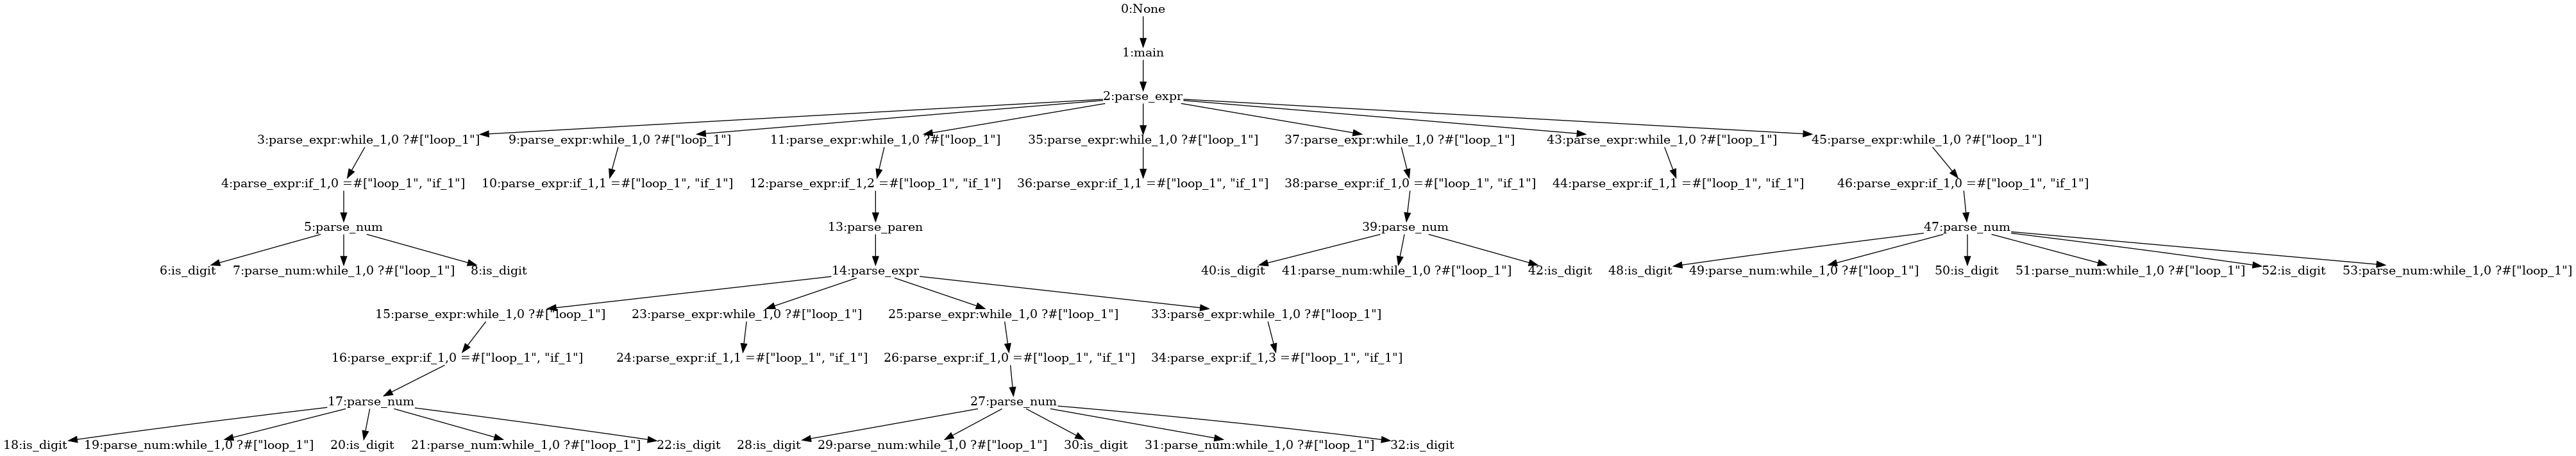

In [97]:
%top zoom(v)

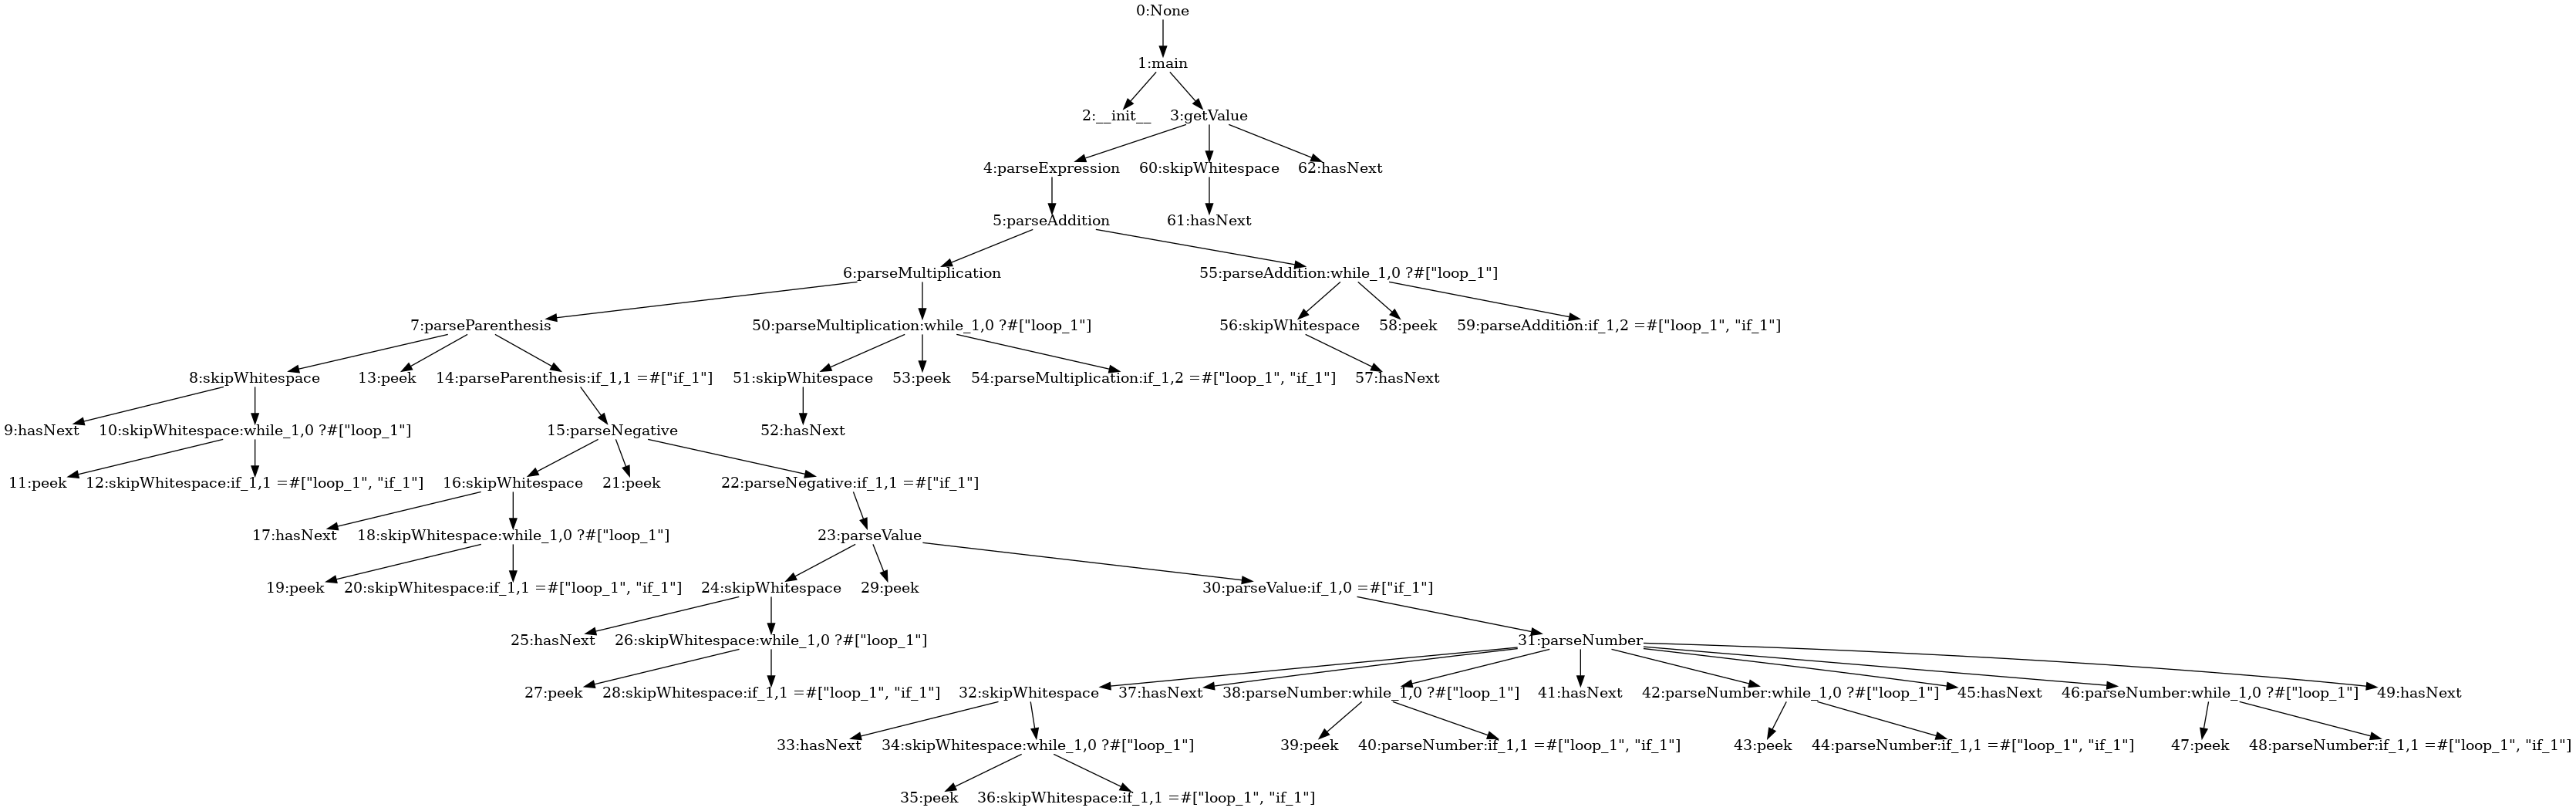

In [98]:
%top zoom(display_tree(mathexpr_method_tree1[0], extract_node=extract_node))

In [99]:
%top trace = {0: {'id': 0, 'name': None, 'children': [{'id': 1, 'name': '_real_program_main', 'indexes': [], 'children': [{'id': 2, 'name': '_real_program_main:if_16 - 0#[-1]', 'indexes': [], 'children': [{'id': 3, 'name': 'if:if_17 - 0#[-1, -1]', 'indexes': [], 'children': []}]}, {'id': 4, 'name': 'parse_expr', 'indexes': [], 'children': [{'id': 5, 'name': 'parse_expr:while_10 ? [1]', 'indexes': [], 'children': [{'id': 6, 'name': 'while:if_11 - 0#[1, -1]', 'indexes': [], 'children': [{'id': 7, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}, {'id': 12, 'name': 'parse_expr:while_10 ? [2]', 'indexes': [], 'children': [{'id': 13, 'name': 'while:if_11 - 0#[2, -1]', 'indexes': [], 'children': []}]}, {'id': 14, 'name': 'parse_expr:while_10 ? [3]', 'indexes': [], 'children': [{'id': 15, 'name': 'while:if_11 - 0#[3, -1]', 'indexes': [], 'children': [{'id': 16, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}]}]}], 'indexes': []}, 1: {'id': 1, 'name': '_real_program_main', 'indexes': [], 'children': [{'id': 2, 'name': '_real_program_main:if_16 - 0#[-1]', 'indexes': [], 'children': [{'id': 3, 'name': 'if:if_17 - 0#[-1, -1]', 'indexes': [], 'children': []}]}, {'id': 4, 'name': 'parse_expr', 'indexes': [], 'children': [{'id': 5, 'name': 'parse_expr:while_10 ? [1]', 'indexes': [], 'children': [{'id': 6, 'name': 'while:if_11 - 0#[1, -1]', 'indexes': [], 'children': [{'id': 7, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}, {'id': 12, 'name': 'parse_expr:while_10 ? [2]', 'indexes': [], 'children': [{'id': 13, 'name': 'while:if_11 - 0#[2, -1]', 'indexes': [], 'children': []}]}, {'id': 14, 'name': 'parse_expr:while_10 ? [3]', 'indexes': [], 'children': [{'id': 15, 'name': 'while:if_11 - 0#[3, -1]', 'indexes': [], 'children': [{'id': 16, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}]}]}, 2: {'id': 2, 'name': '_real_program_main:if_16 - 0#[-1]', 'indexes': [], 'children': [{'id': 3, 'name': 'if:if_17 - 0#[-1, -1]', 'indexes': [], 'children': []}]}, 4: {'id': 4, 'name': 'parse_expr', 'indexes': [], 'children': [{'id': 5, 'name': 'parse_expr:while_10 ? [1]', 'indexes': [], 'children': [{'id': 6, 'name': 'while:if_11 - 0#[1, -1]', 'indexes': [], 'children': [{'id': 7, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}, {'id': 12, 'name': 'parse_expr:while_10 ? [2]', 'indexes': [], 'children': [{'id': 13, 'name': 'while:if_11 - 0#[2, -1]', 'indexes': [], 'children': []}]}, {'id': 14, 'name': 'parse_expr:while_10 ? [3]', 'indexes': [], 'children': [{'id': 15, 'name': 'while:if_11 - 0#[3, -1]', 'indexes': [], 'children': [{'id': 16, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}]}, 3: {'id': 3, 'name': 'if:if_17 - 0#[-1, -1]', 'indexes': [], 'children': []}, 5: {'id': 5, 'name': 'parse_expr:while_10 ? [1]', 'indexes': [], 'children': [{'id': 6, 'name': 'while:if_11 - 0#[1, -1]', 'indexes': [], 'children': [{'id': 7, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}, 12: {'id': 12, 'name': 'parse_expr:while_10 ? [2]', 'indexes': [], 'children': [{'id': 13, 'name': 'while:if_11 - 0#[2, -1]', 'indexes': [], 'children': []}]}, 14: {'id': 14, 'name': 'parse_expr:while_10 ? [3]', 'indexes': [], 'children': [{'id': 15, 'name': 'while:if_11 - 0#[3, -1]', 'indexes': [], 'children': [{'id': 16, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}]}, 6: {'id': 6, 'name': 'while:if_11 - 0#[1, -1]', 'indexes': [], 'children': [{'id': 7, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}, 7: {'id': 7, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}, 8: {'id': 8, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, 10: {'id': 10, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}, 9: {'id': 9, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}, 11: {'id': 11, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}, 13: {'id': 13, 'name': 'while:if_11 - 0#[2, -1]', 'indexes': [], 'children': []}, 15: {'id': 15, 'name': 'while:if_11 - 0#[3, -1]', 'indexes': [], 'children': [{'id': 16, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}]}, 16: {'id': 16, 'name': 'parse_num', 'indexes': [], 'children': [{'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}]}, 17: {'id': 17, 'name': 'parse_num:for_2 ? 0#[1]', 'indexes': [], 'children': [{'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}]}, 19: {'id': 19, 'name': 'parse_num:for_2 ? 0#[2]', 'indexes': [], 'children': [{'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}]}, 18: {'id': 18, 'name': 'for:if_3 - 1#[1, -1]', 'indexes': [], 'children': []}, 20: {'id': 20, 'name': 'for:if_3 - 0#[2, -1]', 'indexes': [], 'children': []}}

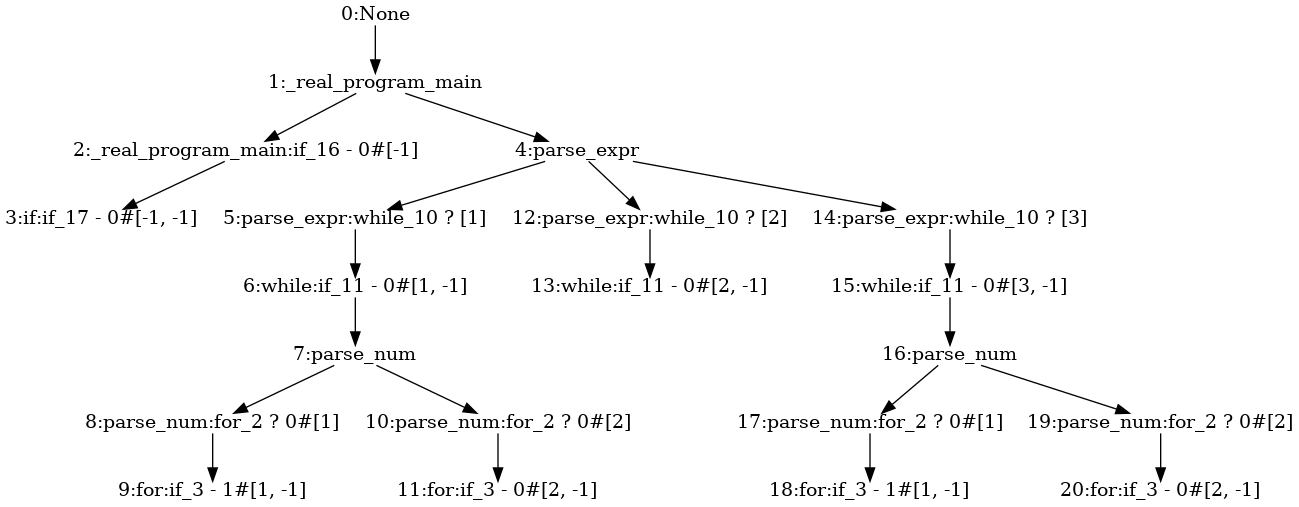

In [100]:
%top zoom(display_tree(trace[0], extract_node=extract_node))

#### Identifying last comparisons
We need only the last comparisons made on any index. This means that we should care for only the last parse in an ambiguous parse. So, we assign the method that last touched an index to be its consumer.

However, to make concessions for real world, we also check if we are overwriting a child (`HEURISTIC`). Essentially, if the heursitic is enabled, then if the current method id (`midP`) is smaller than the `midC` already stored in the last comparison map, then it means that `midP` is a parent that called `midC` previously, and now accessing an index that `midC` touched. This happens when the parent tries to find a substring like `#` in the entirety of the original string. (Note that we have seen this only in `URLParser`). (Note that this heuristic does not restrict reparsing by another function call -- in such a case, `midC` will not smaller than `midP`). So, perhaps, we should let the child keep the ownership. However, there is one more wrinkle. If the character being contested was the last index touched by our `mid`, then it is likely that it was simply a boundary check. In that case, we should let the parent own this character.

In [101]:
LAST_COMPARISON_HEURISTIC = False

In [102]:
def last_comparisons(comparisons):
    last_cmp_only = {}
    last_idx = {}

    # get the last indexes compared in methods.
    for idx, char, mid in comparisons:
        if mid in last_idx:
            if idx > last_idx[mid]:
                last_idx[mid] = idx
        else:
            last_idx[mid] = idx

    for idx, char, mid in comparisons:
        if LAST_COMPARISON_HEURISTIC:
            if idx in last_cmp_only:
                midC = last_cmp_only[idx]
                if midC > mid:
                    # midC is a child of mid.
                    # do not clobber children unless it was the last character
                    # for that child.
                    if last_idx[mid] == idx:
                        # if it was the last index, may be the child used it
                        # as a boundary check.
                        pass
                    else:
                        # do not overwrite the current value of `last_cmp_only[idx]`
                        continue
        last_cmp_only[idx] = mid
    return last_cmp_only

Here is how one would use it.

In [103]:
%top calc_last_comparisons1 = last_comparisons(calc_trace[0]['comparisons'])

In [104]:
%top calc_last_comparisons1

{0: 6,
 1: 9,
 2: 13,
 3: 18,
 4: 20,
 5: 23,
 6: 28,
 7: 30,
 8: 13,
 9: 35,
 10: 40,
 11: 43,
 12: 48,
 13: 50,
 14: 52}

In [105]:
%top mathexpr_last_comparisons1 = last_comparisons(mathexpr_trace[0]['comparisons'])

In [106]:
%top mathexpr_last_comparisons1

{0: 38, 1: 42, 2: 46}

#### Attaching characters to the tree
Add the comparison indexes to the method tree that we constructed

In [107]:
def attach_comparisons(method_tree, comparisons):
    for idx in comparisons:
        mid = comparisons[idx]
        method_tree[mid]['indexes'].append(idx)

Here is how one would use it. Note which method call each input index is associated. For example, the first index is associated with method call id: 6, which corresponds to `is_digit`.

In [108]:
%top attach_comparisons(calc_method_tree1, calc_last_comparisons1)

In [109]:
%top calc_method_tree1

{0: {'id': 0,
  'name': None,
  'children': [{'id': 1,
    'name': 'main',
    'indexes': [],
    'children': [{'id': 2,
      'name': 'parse_expr',
      'indexes': [],
      'children': [{'id': 3,
        'name': 'parse_expr:while_1,0 ?#["loop_1"]',
        'indexes': [],
        'children': [{'id': 4,
          'name': 'parse_expr:if_1,0 =#["loop_1", "if_1"]',
          'indexes': [],
          'children': [{'id': 5,
            'name': 'parse_num',
            'indexes': [],
            'children': [{'id': 6,
              'name': 'is_digit',
              'indexes': [0],
              'children': []},
             {'id': 7,
              'name': 'parse_num:while_1,0 ?#["loop_1"]',
              'indexes': [],
              'children': []},
             {'id': 8,
              'name': 'is_digit',
              'indexes': [],
              'children': []}]}]}]},
       {'id': 9,
        'name': 'parse_expr:while_1,0 ?#["loop_1"]',
        'indexes': [1],
        'children': [{'id': 

In [110]:
%top attach_comparisons(mathexpr_method_tree1, mathexpr_last_comparisons1)

In [111]:
%top mathexpr_method_tree1

{0: {'id': 0,
  'name': None,
  'children': [{'id': 1,
    'name': 'main',
    'indexes': [],
    'children': [{'id': 2, 'name': '__init__', 'indexes': [], 'children': []},
     {'id': 3,
      'name': 'getValue',
      'indexes': [],
      'children': [{'id': 4,
        'name': 'parseExpression',
        'indexes': [],
        'children': [{'id': 5,
          'name': 'parseAddition',
          'indexes': [],
          'children': [{'id': 6,
            'name': 'parseMultiplication',
            'indexes': [],
            'children': [{'id': 7,
              'name': 'parseParenthesis',
              'indexes': [],
              'children': [{'id': 8,
                'name': 'skipWhitespace',
                'indexes': [],
                'children': [{'id': 9,
                  'name': 'hasNext',
                  'indexes': [],
                  'children': []},
                 {'id': 10,
                  'name': 'skipWhitespace:while_1,0 ?#["loop_1"]',
                  'indexes': 

In [112]:
def wrap_input(istr):
    def extract_node(node, id):
        symbol = str(node['id'])
        children = node['children']
        annotation = str(node['name'])
        indexes = repr(tuple([istr[i] for i in node['indexes']]))
        return "%s %s" % (annotation, indexes), children, ''
    return extract_node

In [113]:
%top extract_node1 = wrap_input(calc_trace[0]['inputstr'])

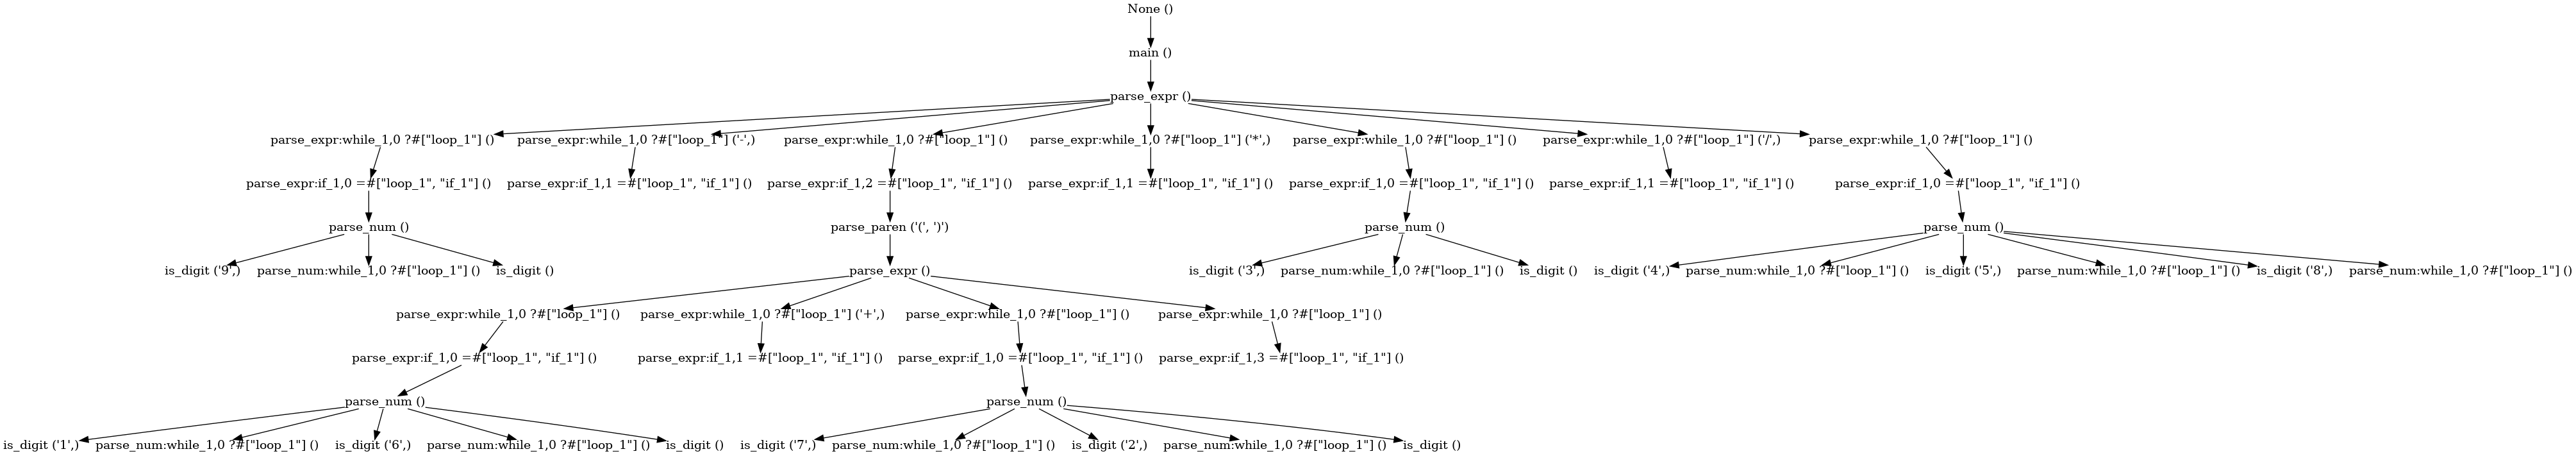

In [114]:
%top zoom(display_tree(calc_method_tree1[0], extract_node=extract_node1))

In [115]:
%top extract_node1 = wrap_input(mathexpr_trace[0]['inputstr'])

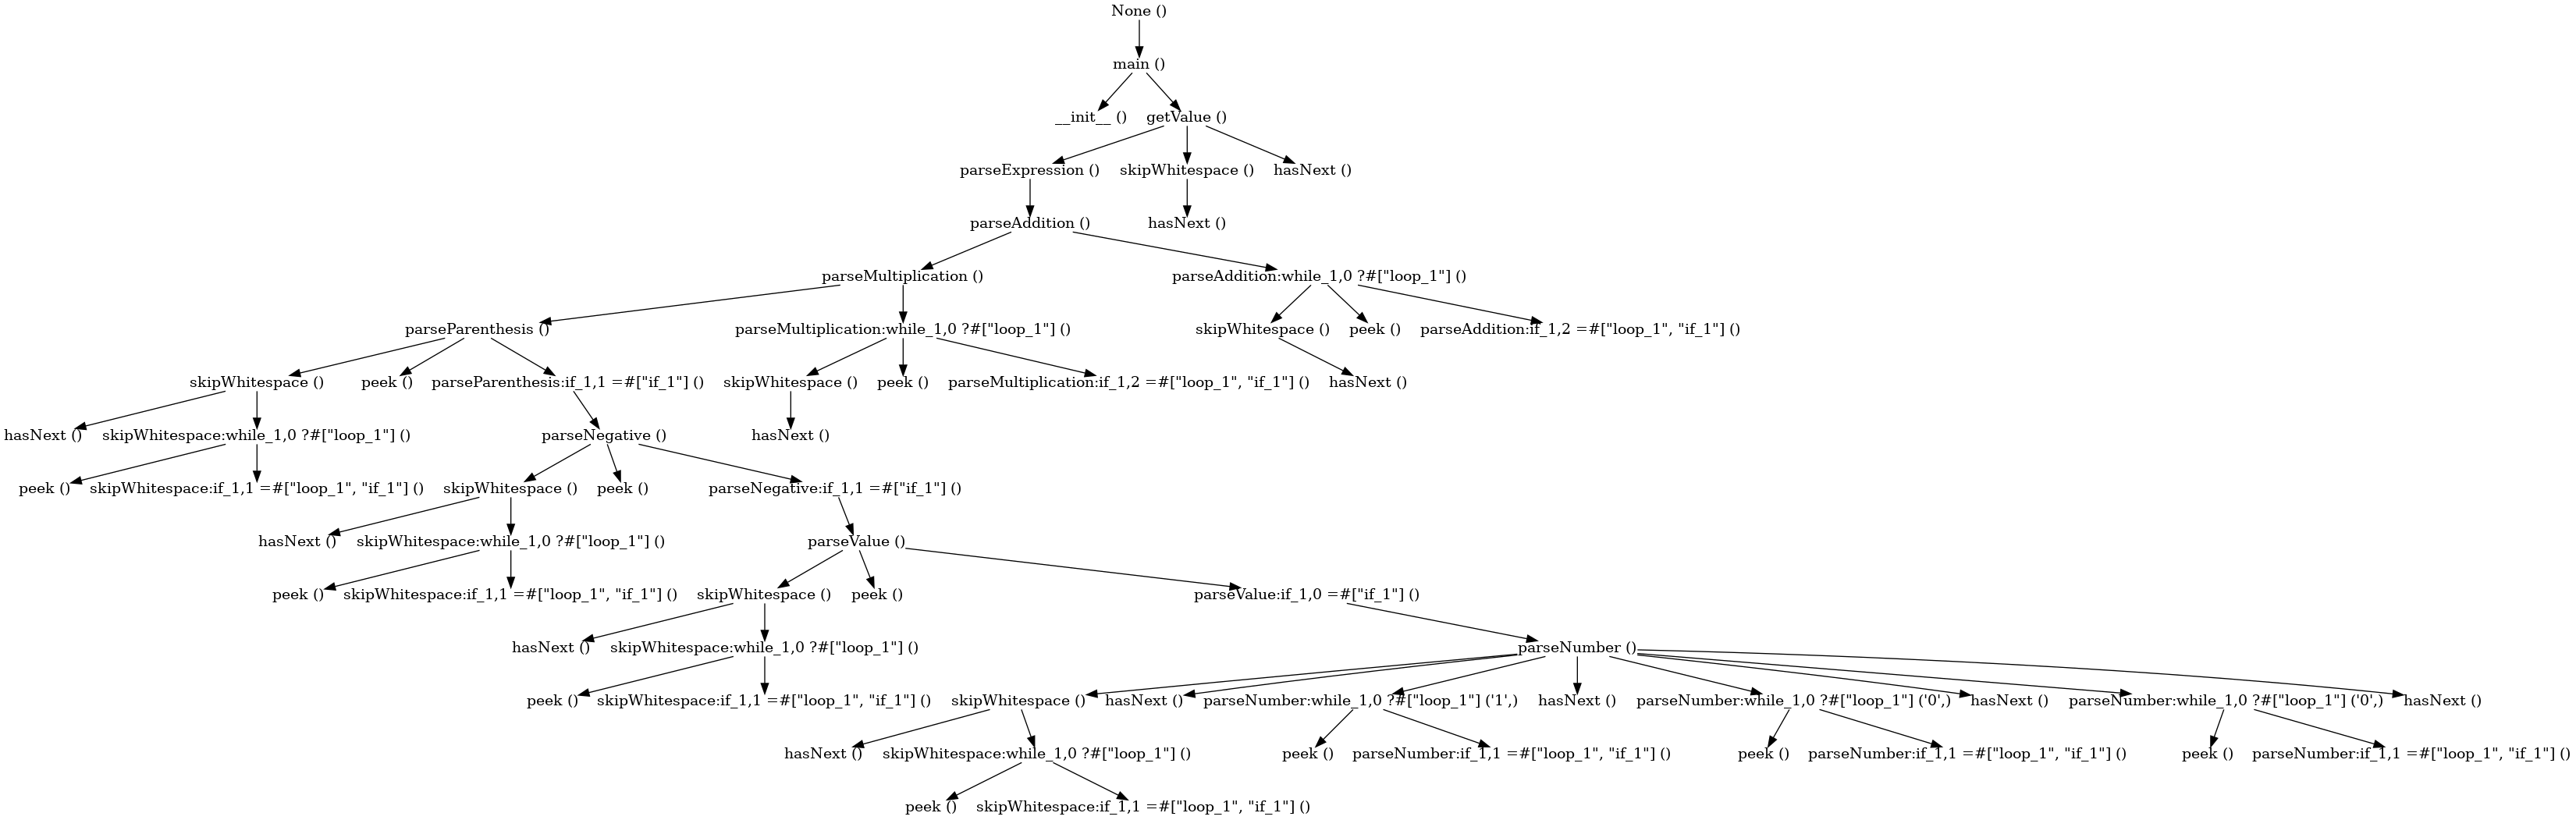

In [116]:
%top zoom(display_tree(mathexpr_method_tree1[0], extract_node=extract_node1))

We define `to_node()` a convenience function that, given a list of _contiguous_ indexes and original string, translates it to a leaf node of a tree (that corresponds to the derivation tree syntax in the Fuzzingbook) with a string, empty children, and starting node and ending node.

Convert a list of indexes to a corresponding terminal tree node

In [117]:
def to_node(idxes, my_str):
    assert len(idxes) == idxes[-1] - idxes[0] + 1
    assert min(idxes) == idxes[0]
    assert max(idxes) == idxes[-1]
    return my_str[idxes[0]:idxes[-1] + 1], [], idxes[0], idxes[-1]

Here is how one would use it.

In [118]:
for k in calc_method_tree1.keys():
    idxs = calc_method_tree1[k]['indexes']
    if idxs:
        print(k, idxs)

9 [1]
35 [9]
43 [11]
6 [0]
13 [2, 8]
23 [5]
18 [3]
20 [4]
28 [6]
30 [7]
40 [10]
48 [12]
50 [13]
52 [14]


In [119]:
%top to_node(calc_method_tree1[9]['indexes'], calc_trace[0]['inputstr'])

('-', [], 1, 1)

In [120]:
from operator import itemgetter
import itertools as it

We now need to identify the terminal (leaf) nodes. For that, we want to group contiguous letters in a node together, and call it a leaf node. So, convert our list of indexes to lists of contiguous indexes first, then convert them to terminal tree nodes. Then, return a set of one level child nodes with contiguous chars from indexes.

In [121]:
def indexes_to_children(indexes, my_str):
    lst = [
        list(map(itemgetter(1), g))
        for k, g in it.groupby(enumerate(indexes), lambda x: x[0] - x[1])
    ]

    return [to_node(n, my_str) for n in lst]

In [122]:
%top indexes_to_children(calc_method_tree1[9]['indexes'], calc_trace[0]['inputstr'])

[('-', [], 1, 1)]

Finally, we need to remove the overlap from the trees we have so far. The idea is that, given a node, each child node of that node should be uniquely responsible for a specified range of characters, with no overlap allowed between the children. The starting of the first child to ending of the last child will be the range of the node.

#### Removing Overlap
If overlap is found, the tie is biased to the later child. That is, the later child gets to keep the range, and the former child is recursively traversed to remove overlaps from its children. If a child is completely included in the overlap, the child is excised. A few convenience functions first:

In [123]:
def does_item_overlap(r, r_):
    (s, e), (s_, e_) = r, r_
    return ((s_ >= s and s_ <= e) or 
            (e_ >= s and e_ <= e) or 
            (s_ <= s and e_ >= e))

In [124]:
def is_second_item_included(r, r_):
    (s, e), (s_, e_) = r, r_
    return (s_ >= s and e_ <= e)

In [125]:
def has_overlap(ranges, r_):
    return {r for r in ranges if does_item_overlap(r, r_)}

In [126]:
def is_included(ranges, r_):
    return {r for r in ranges if is_second_item_included(r, r_)}

In [127]:
def remove_overlap_from(original_node, orange):
    node, children, start, end = original_node
    new_children = []
    if not children:
        return None
    start = -1
    end = -1
    for child in children:
        if does_item_overlap(child[2:4], orange):
            new_child = remove_overlap_from(child, orange)
            if new_child: # and new_child[1]:
                if start == -1: start = new_child[2]
                new_children.append(new_child)
                end = new_child[3]
        else:
            new_children.append(child)
            if start == -1: start = child[2]
            end = child[3]
    if not new_children:
        return None
    assert start != -1
    assert end != -1
    return (node, new_children, start, end)

Verify that there is no overlap.

In [128]:
def no_overlap(arr):
    my_ranges = {}
    for a in arr:
        _, _, s, e = a
        r = (s, e)
        included = is_included(my_ranges, r)
        if included:
            continue  # we will fill up the blanks later.
        else:
            overlaps = has_overlap(my_ranges, r) 
            if overlaps:
                # unlike include which can happen only once in a set of
                # non-overlapping ranges, overlaps can happen on multiple parts.
                # The rule is, the later child gets the say. So, we recursively
                # remove any ranges that overlap with the current one from the
                # overlapped range.
                assert len(overlaps) == 1
                oitem = list(overlaps)[0]
                v = remove_overlap_from(my_ranges[oitem], r)
                del my_ranges[oitem]
                if v:
                    my_ranges[v[2:4]] = v
                my_ranges[r] = a
            else:
                my_ranges[r] = a
    res = my_ranges.values()
    # assert no overlap, and order by starting index
    s = sorted(res, key=lambda x: x[2])
    return s

#### Generate derivation tree

Convert a mapped tree to the _fuzzingbook_ style derivation tree.

In [129]:
def to_tree(node, my_str):
    method_name = ("<%s>" % node['name']) if node['name'] is not None else '<START>'
    indexes = node['indexes']
    node_children = [to_tree(c, my_str) for c in node.get('children', [])]
    idx_children = indexes_to_children(indexes, my_str)
    children = no_overlap([c for c in node_children if c is not None] + idx_children)
    if not children:
        return None
    start_idx = children[0][2]
    end_idx = children[-1][3]
    si = start_idx
    my_children = []
    # FILL IN chars that we did not compare. This is likely due to an i + n
    # instruction.
    for c in children:
        if c[2] != si:
            sbs = my_str[si: c[2]]
            my_children.append((sbs, [], si, c[2] - 1))
        my_children.append(c)
        si = c[3] + 1

    m = (method_name, my_children, start_idx, end_idx)
    return m

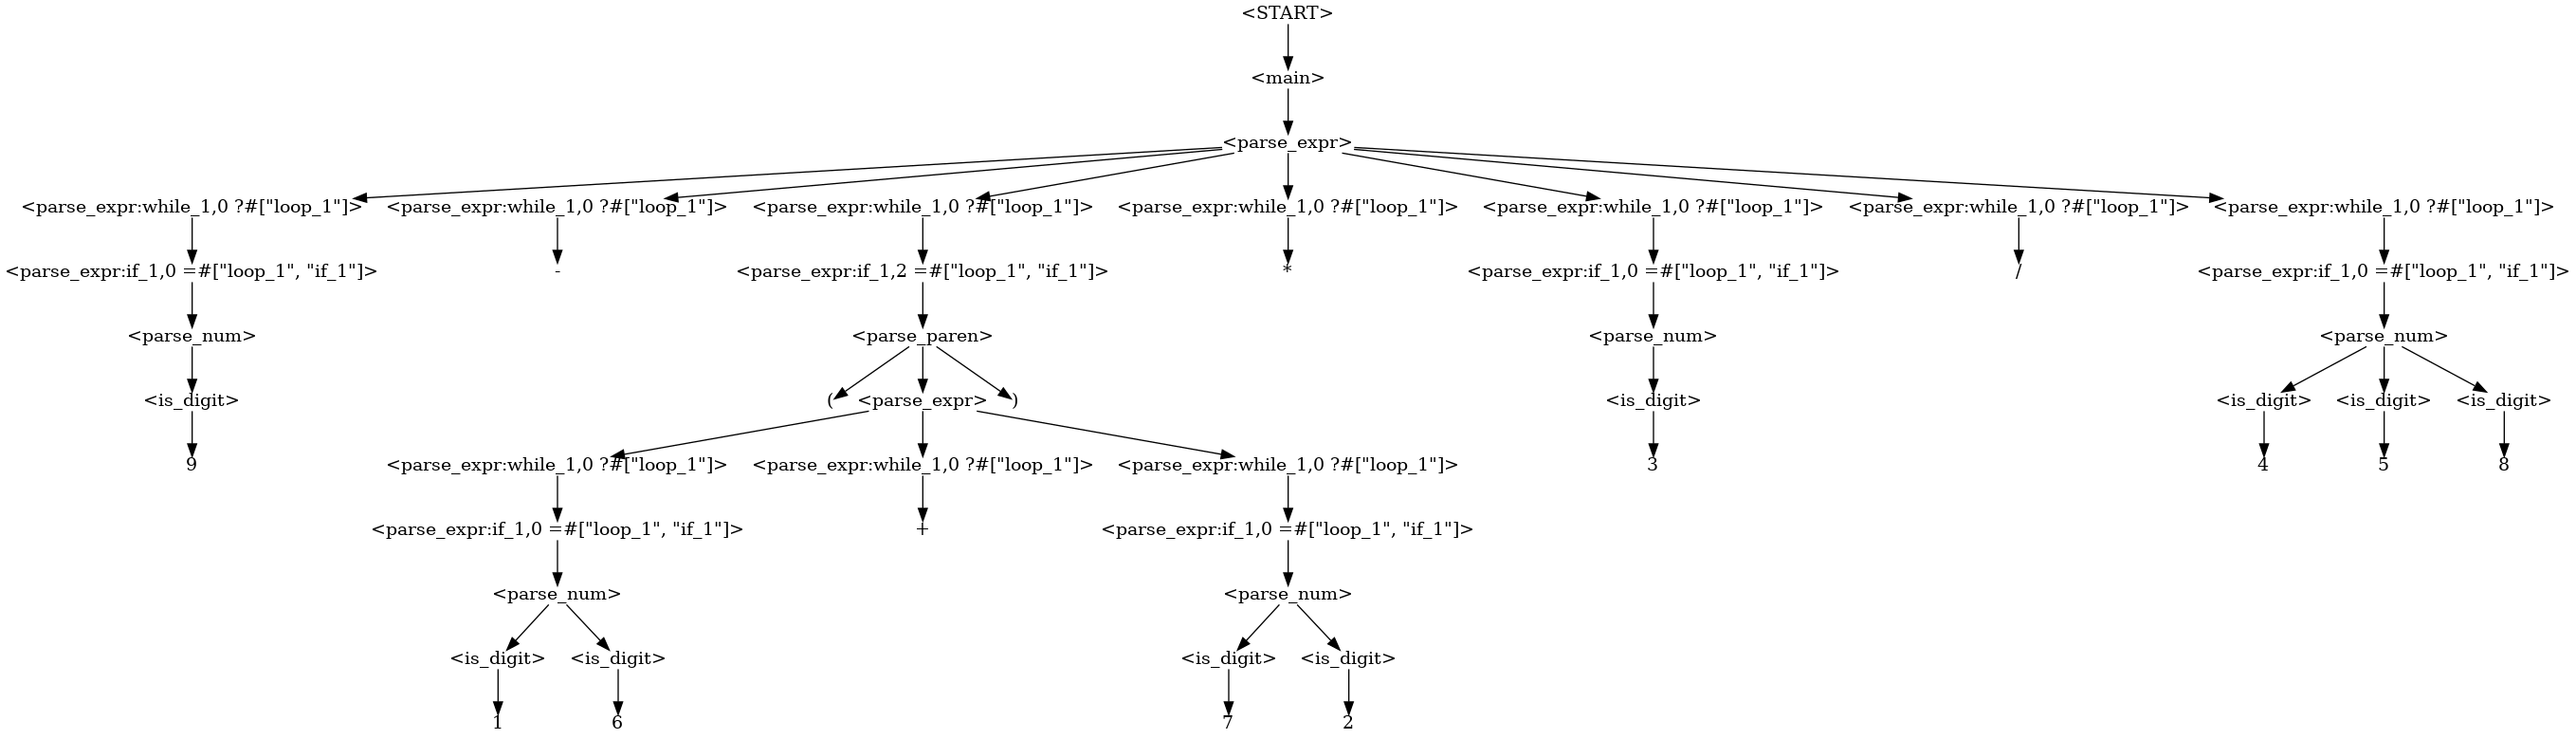

In [130]:
%top zoom(display_tree(to_tree(calc_method_tree1[0], calc_trace[0]['inputstr'])))

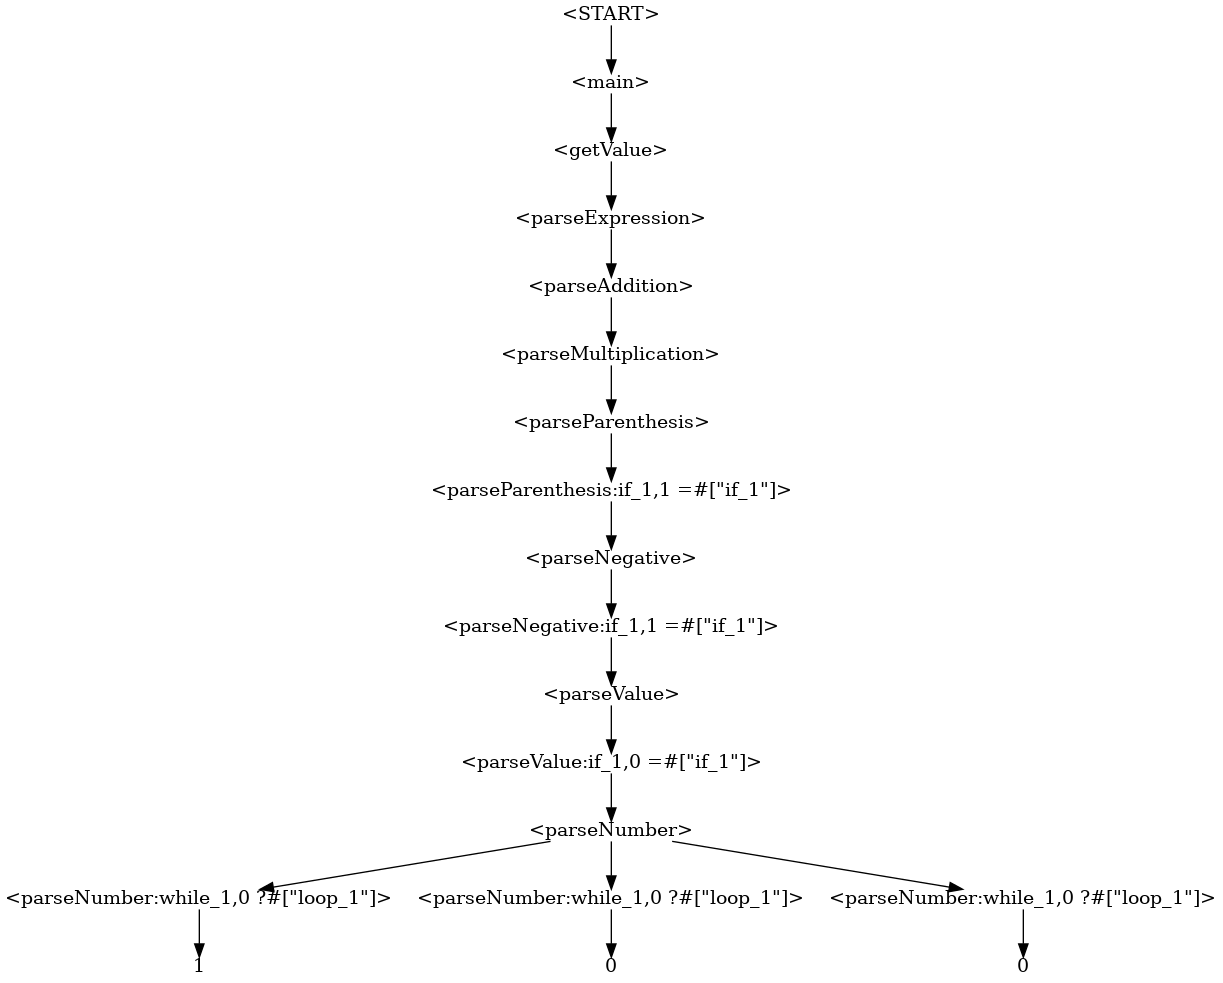

In [131]:
%top zoom(display_tree(to_tree(mathexpr_method_tree1[0], mathexpr_trace[0]['inputstr'])))

### The Complete Miner

We now put everything together. The `miner()` takes the traces, produces trees out of them, and verifies that the trees actually correspond to the input.

In [132]:
def is_nt(v):
    return len(v) > 1 and (v[0], v[-1]) == ('<', '>')

In [133]:
def tree_to_str(tree): # Non recursive
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if is_nt(key):
            to_expand = children + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

In [134]:
def miner(call_traces):
    my_trees = []
    for call_trace in call_traces:
        with open('last_trace.json', 'w+') as f:
            json.dump([call_trace], fp=f)
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']

        tree = to_tree(method_tree[first], my_str)
        my_tree = {'tree': tree, 'original': call_trace['original'], 'arg': call_trace['arg']}
        assert tree_to_str(tree) == my_str
        my_trees.append(my_tree)
    return my_trees

Using the `miner()`

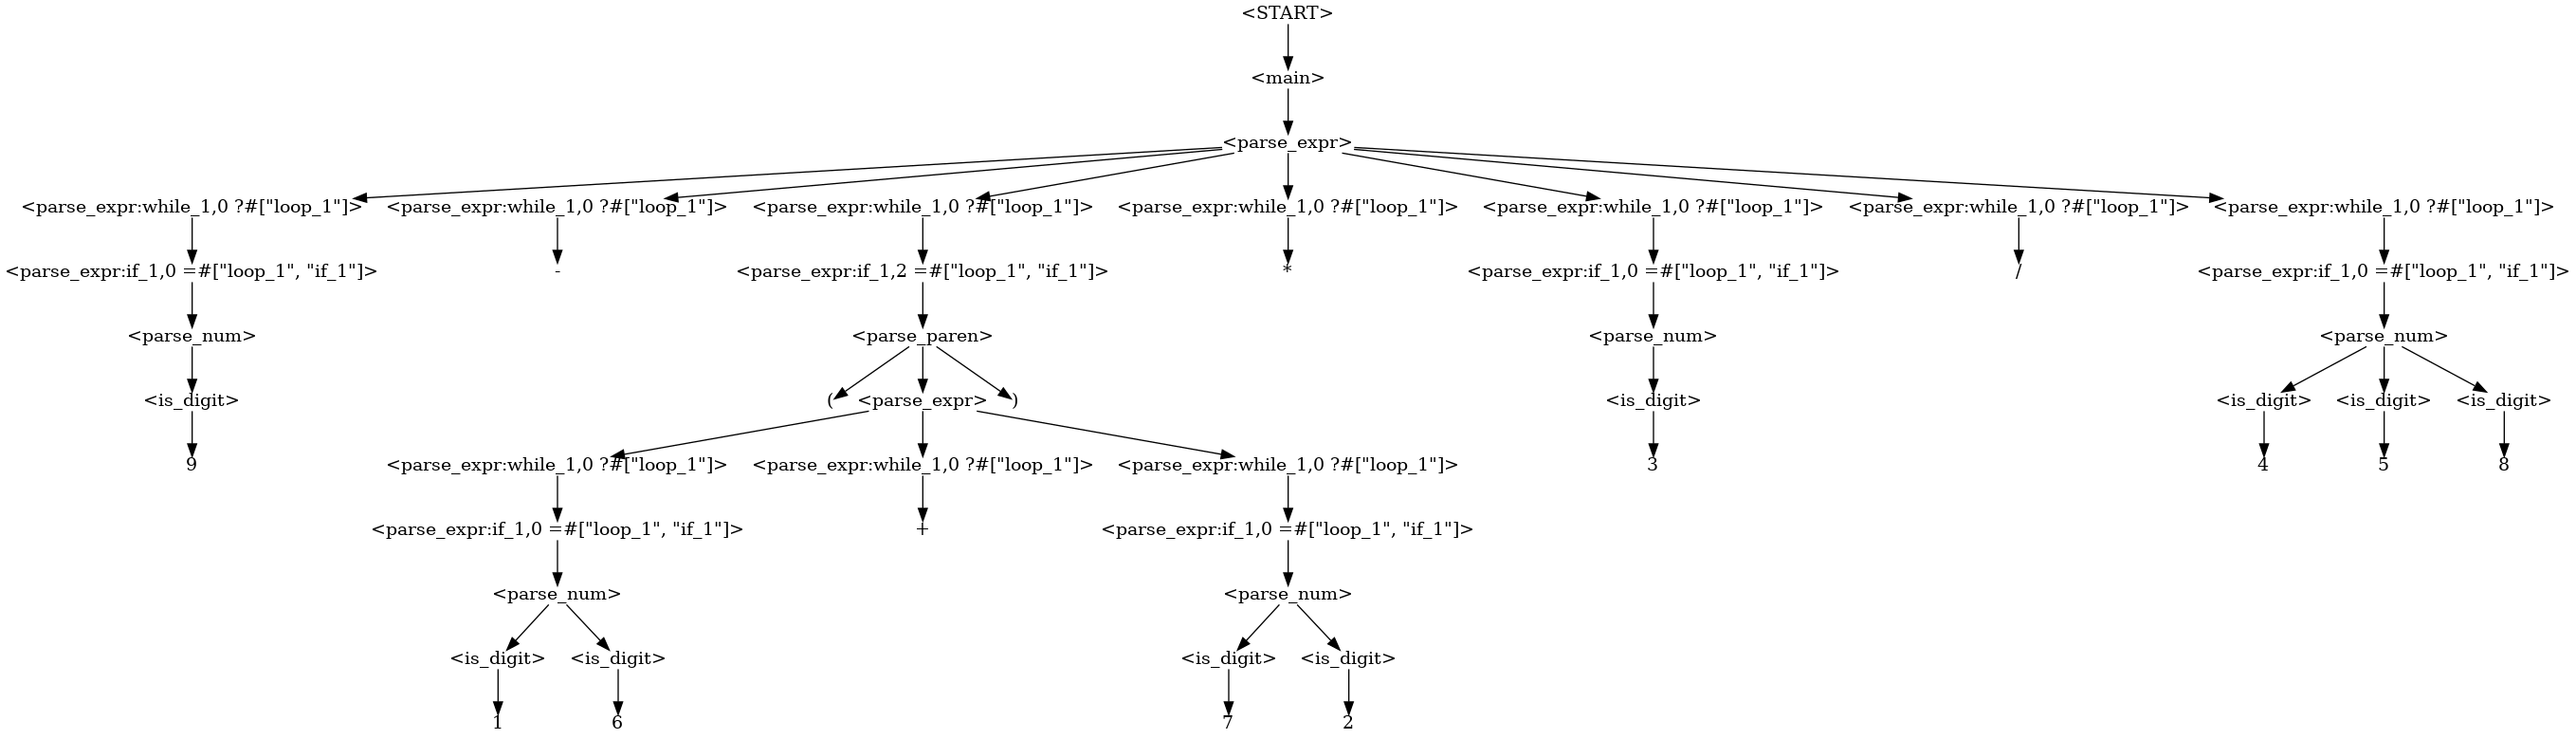

In [135]:
%top mined_calc_trees = miner(calc_trace)
%top calc_tree = mined_calc_trees[0]
%top zoom(display_tree(calc_tree['tree']))

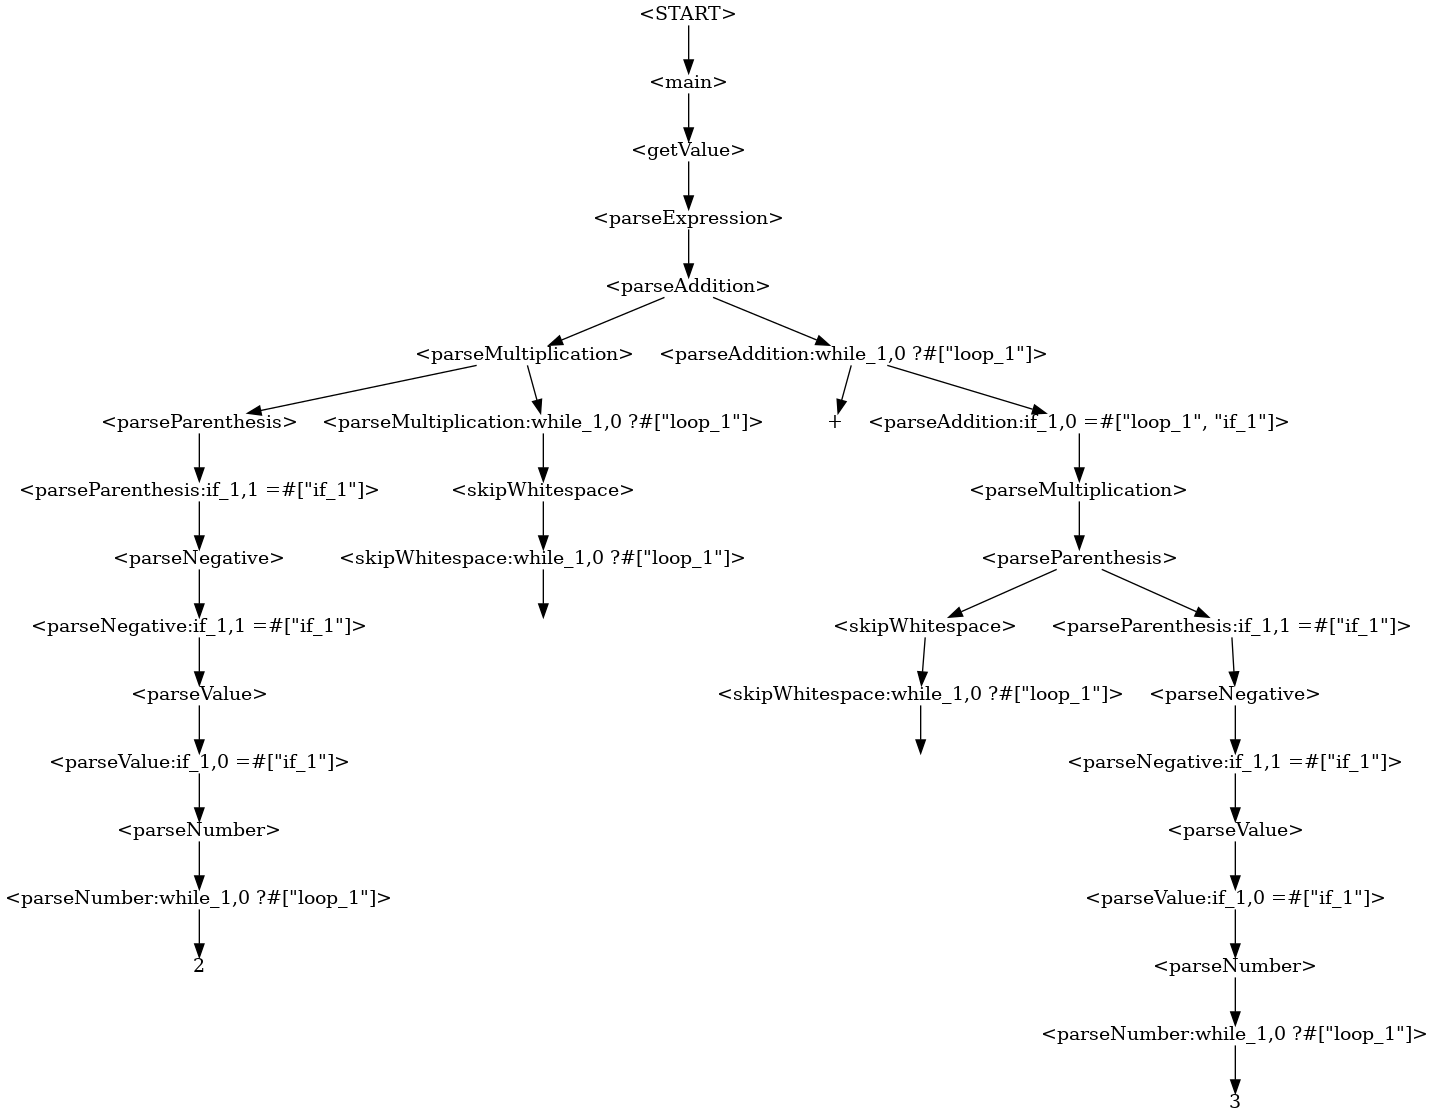

In [136]:
%top mined_mathexpr_trees = miner(mathexpr_trace)
%top mathexpr_tree = mined_mathexpr_trees[1]
%top zoom(display_tree(mathexpr_tree['tree']))

## Generalize Nodes

**TODO**: Fix this. We no longer have separate identifiers for while. The generalizer works by sampling different while nodes and comparing replacement patterns. The identifiers have also become alphanumeric.

One of the problems that you can notice in the tree generated is that each `while` iterations get a different identifier. e.g. 
```
                ('<parse_expr:while_1 ? [2]>', [('+', [], 5, 5)], 5, 5),
                ('<parse_expr:while_1 ? [3]>',
                 [('<parse_expr:if_1 + 0#[3, -1]>',
                   [('<parse_num>',
                     [('<is_digit>', [('7', [], 6, 6)], 6, 6),
                      ('<is_digit>', [('2', [], 7, 7)], 7, 7)],
                     6,
                     7)],
                   6,
                   7)],

```
The separate identifiers are intentional because we do not yet know the actual dependencies between different iterations such as closing quotes, or closing braces or parenthesis. However, this creates a problem when we mine grammar because we need to match up the compatible nodes.

Generalizer does it through actively doing surgery on the tree to see whether a node is replaceable with another.

Constants to limit our exploration. The `MAX_PROC_SAMPLES` is used to specify how many samples to match for getting a swap patter.

In [137]:
MAX_PROC_SAMPLES = 100

Caching and book keeping variables.

In [138]:
EXEC_MAP = {}
NODE_REGISTER = {}

In [139]:
def reset_generalizer():
    global EXEC_MAP
    global NODE_REGISTER
    EXEC_MAP.clear()
    NODE_REGISTER.clear()

Given that we are evaluating Python functions, we need a wrapper to make them executable.

In [140]:
%%var check_src
# [(
import sys, imp
parse_ = imp.new_module('parse_')

def init_module(src):
    with open(src) as sf:
        exec(sf.read(), parse_.__dict__)

def _check(s):
    try:
        parse_.main(s)
        return True
    except:
        return False

import sys
def main(args):
    init_module(args[0])
    if _check(args[1]):
        sys.exit(0)
    else:
        sys.exit(1)
import sys
main(sys.argv[1:])
# )]

In [141]:
# [(
with open('build/check.py', 'w+') as f:
    print(VARS['check_src'], file=f)
# )]

A small library function to convert from tuple to lists so that we can modify a tree.

In [142]:
def to_modifiable(derivation_tree):
    node, children, *rest = derivation_tree
    return [node, [to_modifiable(c) for c in children], *rest]

### Generalize Methods

The idea here is that, sometimes one finds that our central assumption -- that a fragment consumed by a function can be replaced by another fragment consumed by the same function elsewhere -- doesn't hold. This can be seen in functions that take an additional argument to specify what it should match. In such cases, we want to try and find out how to distinguish between these function invocations. 

`node_include()` is a library function that checks whether the node `j` is within the boundary of `i`.

In [143]:
def node_include(i, j):
    name_i, children_i, s_i, e_i = i
    name_j, children_j, s_j, e_j = j
    return is_second_item_included((s_i, e_i), (s_j, e_j))

The `get_ref()` takes a `node` datastructure and searches for `node_name`. It returns the first instance found. This allows us to easily swap nodes.

In [144]:
def get_ref(node, node_name):
    name, children, *rest = node
    if name == node_name:
        return node
    for child in children:
        res = get_ref(child, node_name)
        if res is not None: return res
    return None

 The `replace_nodes()` function try to replace the contents of the first node with the _contents_ of the second (That is, the tree that has these nodes will automatically be modified), collect the produced string from the tree, and reset any changes. The arguments are tuples with the following format: (node, file_name, tree)

In [145]:
def deep_copy(t): # Python deepcopy is a bit buggy
    v = json.dumps(t)
    return json.loads(v)

In [146]:
# replace the given node in a2 by the node in a1
def replace_nodes(a2, a1):
    node2, _, t2 = a2
    node1, _, t1 = a1
    str2_old = tree_to_str(t2)

    # first change the name of the node, then copy the tree.
    tmpl_name = '___cmimid___'
    old_name = node2[0]
    node2[0] = tmpl_name
    t2_new = deep_copy(t2)
    node2[0] = old_name

    # now find the reference to tmpl_name in t2_new
    node2 = get_ref(t2_new, tmpl_name)
    node2.clear()
    for n in node1:
        node2.append(n)
    str2_new = tree_to_str(t2_new)
    assert str2_old != str2_new
    return t2_new

Can a given node be replaced with another? The idea is, given two nodes (possibly from two trees), can the first node be replaced by the second, and still result in a valid string?

In [147]:
def is_a_replaceable_with_b(a1, a2, module):
    n1, f1, t1 = a1
    n2, f2, t2 = a2
    if tree_to_str(n1) == tree_to_str(n2): return True
    t_x = replace_nodes(a1, (('XXXX', []), None, t2))
    x = tree_to_str(t_x)
    updated_tree = replace_nodes(a1, a2)
    updated_string = tree_to_str(updated_tree)
    o = tree_to_str(t1)
    v = check(o, x, n1[0], updated_tree, module, tree_to_str(a1[0]), tree_to_str(a2[0]))
    return v

In [148]:
def is_compatible(a1, a2, module):
    t1 = is_a_replaceable_with_b(a1, a2, module)
    if not t1: return False
    t2 = is_a_replaceable_with_b(a2, a1, module)
    return t2

There are fundamentally, two kinds of nodes. The first kind of node is a method node, that correspond to a method call. The second is a node that corresponds to a pseudo-method -- that is, a node that represents a loop or a conditional. Below are the predicates that identify such methods, parses, and reconstructs such nodes.

In [149]:
def is_node_method(node):
    node_name = node[0]
    if (node_name[0], node_name[-1]) != ('<', '>'): return False
    return not is_node_pseudo(node)

In [150]:
def is_node_pseudo(node):
    node_name = node[0]
    if (node_name[0], node_name[-1]) != ('<', '>'): return False
    if ':if_' in node_name: return True
    if ':while_' in node_name: return True
    return False

In [151]:
def parse_pseudo_name(node_name):
    assert (node_name[0], node_name[-1]) == ('<','>')
    return decode_name(node_name[1:-1])

In [152]:
def parse_method_name(mname):
    assert (mname[0], mname[-1]) == ('<', '>')
    name = mname[1:-1]
    if '.' in name:
        nname, my_id = name.split('.')
        return nname, my_id
    else:
        return name, '0'

In [153]:
def decode_name(node_name_stack):
    node_name, mstack = node_name_stack.split('#')
    method_stack = json.loads(mstack)
    method_ctrl_alt_name, can_empty = node_name.split(' ')
    method, ctrl_cid_altid = method_ctrl_alt_name.split(':')
    ctrl, cid_altid = ctrl_cid_altid.split('_')
    assert ctrl in {'while', 'if'}
    cid, altid = cid_altid.split(',')

    if 'while' == ctrl:
        assert altid == '0'
    return method, ctrl, int(cid), altid, can_empty, method_stack

In [154]:
def unparse_pseudo_name(method, ctrl, ctrl_id, alt_num, can_empty, cstack):
    return "<%s>" % encode_name(method, ctrl, ctrl_id, alt_num, can_empty, cstack)

def unparse_method_name(mname, my_id):
    return '<%s.%s>' % (mname, my_id)

def encode_name(method, ctrl, ctrl_id, alt_num, can_empty, stack):
    assert ctrl in {'while', 'if'}
    return '%s:%s_%s,%s %s#%s' % (method, ctrl, ctrl_id, alt_num, can_empty, json.dumps(stack))

The `check()` function invokes the given subject call with the previously defined `check.py` wrapper, logs and returns the result of the call.

**TODO**: What we really want to do, is to generate a new updated tree first after doing the tree surgery. Then, convert this tree to a parenthesized tree by simply doing `tree_to_string` with additional `{}` (or other open/close symbols that does not conflict with the input) attached when joining the nodes. That is,

In [155]:
def tree_to_pstr(tree, op_='', _cl=''):
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *_), *to_expand = to_expand
        if is_nt(key):
            expanded.append(op_)
            to_expand = children + [(_cl, [])] + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

With this, when using `tree_to_string(my_tree, '{', '}')`, We will get a string that represents how the original string was parsed. For example `1+2+3` may be represented as `{{1+2}+3}`.

Next, we need to run the non-parenthesized string resulting from the tree surgery through the program, and collect the resulting tree. Again, convert this tree to the parentesized version, and compare equality.

With this, we can ensure that our tree nodes are correctly compatible, and secondly, we can ignore the return code.

In [156]:
def check(o, x, e, ut, module, sa1, sa2):
    s = tree_to_str(ut)
    if s in EXEC_MAP: return EXEC_MAP[s]
    updated_ps = tree_to_pstr(ut, op_='{', _cl='}')
    tn = "build/_test.csv"
    with open(tn, 'w+') as f: print(s, file=f)

    trace_out = do(["python3","build/%(m)s" % {'m': module}, tn] ).stdout
    val = None
    v = False
    parsed_ps = None
    try:
        val = json.loads(trace_out)
        parsed_tree = miner(val)[0]['tree']
        parsed_ps = tree_to_pstr(parsed_tree, op_='{', _cl='}')
        v = (parsed_ps == updated_ps)
    except:
        parsed_ps = 'ERROR'
        v = False
  
    with open('%s.log' % module, 'a+') as f:
        print('------------------', file=f)
        print(' '.join(["python3", "build/%s" % module, s]), file=f)
        print('Checking:',e, file=f)
        print('original:', repr(o), file=f)
        print('tmpl:', repr(x), file=f)
        print('updated:', repr(s), file=f)
        print('XXXX:', repr(sa1), file=f)
        print('REPL:', repr(sa2), file=f)
        print('ops:', repr(updated_ps), file=f)
        print('pps:', repr(parsed_ps), file=f)
        print(":=", v, file=f)
    #     print(' '.join([module, repr(s)]), file=f)
    #     print("\n", file=f)
    # v = (result.returncode == 0)
    EXEC_MAP[s] = v
    return v

We now want to collect all nodes of a particular kind together. `register_node()` correctly saves specific kinds of nodes separately as copies.

In [157]:
def register_node(node, tree, executable, input_file):
    # we want to save a copy of the tree so we can modify it later. 
    node_name = node[0]
    template_name = '__CMIMID__NODE__'
    node[0] = template_name
    new_tree = deep_copy(tree)
    node[0] = node_name
    new_node = get_ref(new_tree, template_name)
    new_node[0] = node_name
    if node_name not in NODE_REGISTER:
        NODE_REGISTER[node_name] = []
    new_elt = (new_node, new_tree, executable, input_file,
            {'inputstr': tree_to_str(new_tree), 'node':node, 'tree':tree})
    NODE_REGISTER[node_name].append(new_elt)
    return new_elt

`collect_nodes()` recursively calls `register_node()` on the tree so that all nodes are registered. The wrinkle here is that in some case such as parser combinators and peg parsers, there may be long chains of single child repetitions. i.e: `parse -> curry -> parse -> curry -> ...` etc. For them, if we have seen the first `parse` and `curry`, we do not gain anything by analyzing the remainign in the *same chain*. So, we mark such chains.

In [158]:
def collect_nodes_single(node, tree, executable, inputfile, seen):
    node_name, children, si, ei = node
    elt = None
    if is_node_method(node):
        elt = register_node(node, tree, executable, inputfile)
        if node_name in seen:
            elt[4]['seen'] = seen[node_name]
        else:
            seen[node_name] = elt
    if len(children) == 1:
        collect_nodes_single(children[0], tree, executable, inputfile, seen)
    else:
        # no longer the single inheritance line.
        for child in children:
            collect_nodes(child, tree, executable, inputfile)

In [159]:
def collect_nodes(node, tree, executable, inputfile):
    node_name, children, si, ei = node
    elt = None
    if is_node_method(node):
        elt = register_node(node, tree, executable, inputfile)
    if len(children) == 1:
        collect_nodes_single(children[0], tree, executable, inputfile, {node_name: elt})
    else:
        for child in children:
            collect_nodes(child, tree, executable, inputfile)

When looking to see which methods are swappable, the idea is to choose a small sample set for a given node name, and check the current node against that sample set (swap both ways, and check the validity). The different validity patterns we get are marked as different kinds of nodes.

Here, we identify the buckets based on one to one compatibility. Unfortunately, there is a problem here. Essentially, we assume that if `a` is compatible with `b`, and `b` is compatible with `c`, then `a` is compatible with `c`. However, this may not be true in all cases. See the limitations for instances when this assumption is invalidated. At this point, we have several options. The first is to do an $n \times n$ comparison of all items in the bucket, in which case, we will have the true compatibility but with high computational cost. The next alternative is to choose a node in one bucket, and do the bucketing procedure again with the items in the particular bucket. This produces one more bit of information, and one can continue this prodcedure for larger and larger number of bits. One may also choose a statistical sample of $k$ items in the bucket, and go for a comparison only between $n \times k$ items.

At this point, we choose the fastest option, which gets us a reasonable accuracy. We use a single level classification.

In [160]:
def identify_buckets(node_name):
    all_elts = NODE_REGISTER[node_name]
    # remove the duplicate nodes
    elts = [e for e in all_elts if 'seen' not in e[4]]
    seen_elts = [e for e in all_elts if 'seen' in e[4]]
    first, *rest = elts
    first[4]['pattern'] = 0
    buckets = [first]
    for enode in rest:
        node0, tree0, executable0, inputfile0, _info0 = enode
        a0 = node0, inputfile0, tree0
        compatible = None
        for bi, bnode in enumerate(buckets):
            node1, tree1, executable1, inputfile1, _info1 = bnode
            a1 = node1, inputfile1, tree1
            result = is_compatible(a0, a1, executable0)
            if result:
                compatible = bi
                enode[4]['pattern'] = bi
                break
        if compatible is None:
            enode[4]['pattern'] = len(buckets)
            buckets.append(enode)
            
    for e in seen_elts:
        e_seen = e[4]['seen']
        e_seen_pattern = e_seen[4]['pattern']
        e[4]['pattern'] = e_seen_pattern
    return {i:i for i,b in enumerate(buckets)}

Once we identify that a node belongs to a particular pattern identifier, we update all the pseudo-methods belonging to that node. These can be found by simply traversiing the tree until the next method is found.

In [161]:
def update_method_stack(node, old_name, new_name):
    nname, children, *rest = node
    if not (':if_' in nname or ':while_' in nname):
        return
    method, ctrl, cname, num, can_empty, cstack = parse_pseudo_name(nname)
    assert method == old_name, "%s != %s" % (method, old_name)
    name = unparse_pseudo_name(new_name, ctrl, cname, num, can_empty, cstack)
    #assert '?' not in name
    node[0] = name
    for c in node[1]:
        update_method_stack(c, old_name, new_name)

In [162]:
def update_method_name(k_m, my_id):
    # fixup k_m with what is in my_id
    original = k_m[0]
    method, old_id = parse_method_name(original)
    name = unparse_method_name(method, my_id)
    k_m[0] = name

    for c in k_m[1]:
        update_method_stack(c, original[1:-1], name[1:-1])

    return name, k_m

In [163]:
def update_original_method_names(node_name):
    registered_xnodes = NODE_REGISTER[node_name]
    for xnode in registered_xnodes:
        # name it according to its pattern
        nodeX, treeX, executableX, inputfileX, infoX = xnode
        pattern = infoX['pattern']
        update_method_name(infoX['node'], pattern)

The idea is to first collect and register all nodes by their names.
Next, we sample N of these, and use the pattern of matches
(**TODO**: Do we simply use the pattern of compatibility or the pattern
of left to right replaceability -- that is, a is replaceable with b
but b is not replaceable with a is 10 while full compatibility would
be 11 -> 1)

In [164]:
def generalize_method_trees(jtrees, log=False):
    my_trees = []
    for i,j in enumerate(jtrees):
        tree = to_modifiable(j['tree']) # The tree ds.
        executable = j['original']
        inputfile = j['arg']
        # we skip START
        node_name, children, *rest = tree
        assert node_name == '<START>'
        for child in children:
            collect_nodes(tree, tree, executable, inputfile)
        my_trees.append({'tree':tree, 'original': executable, 'arg': inputfile})

    for k in NODE_REGISTER:
        identify_buckets(k)

    # finally, update the original names.
    for k in NODE_REGISTER:
        if k == '<START>': continue
        update_original_method_names(k)
    return my_trees

Here is how we use it.

In [165]:
%top reset_generalizer()
%top mg_calc_trees = generalize_method_trees(mined_calc_trees)

In [166]:
%top reset_generalizer()
%top mg_mathexpr_trees = generalize_method_trees(mined_mathexpr_trees)

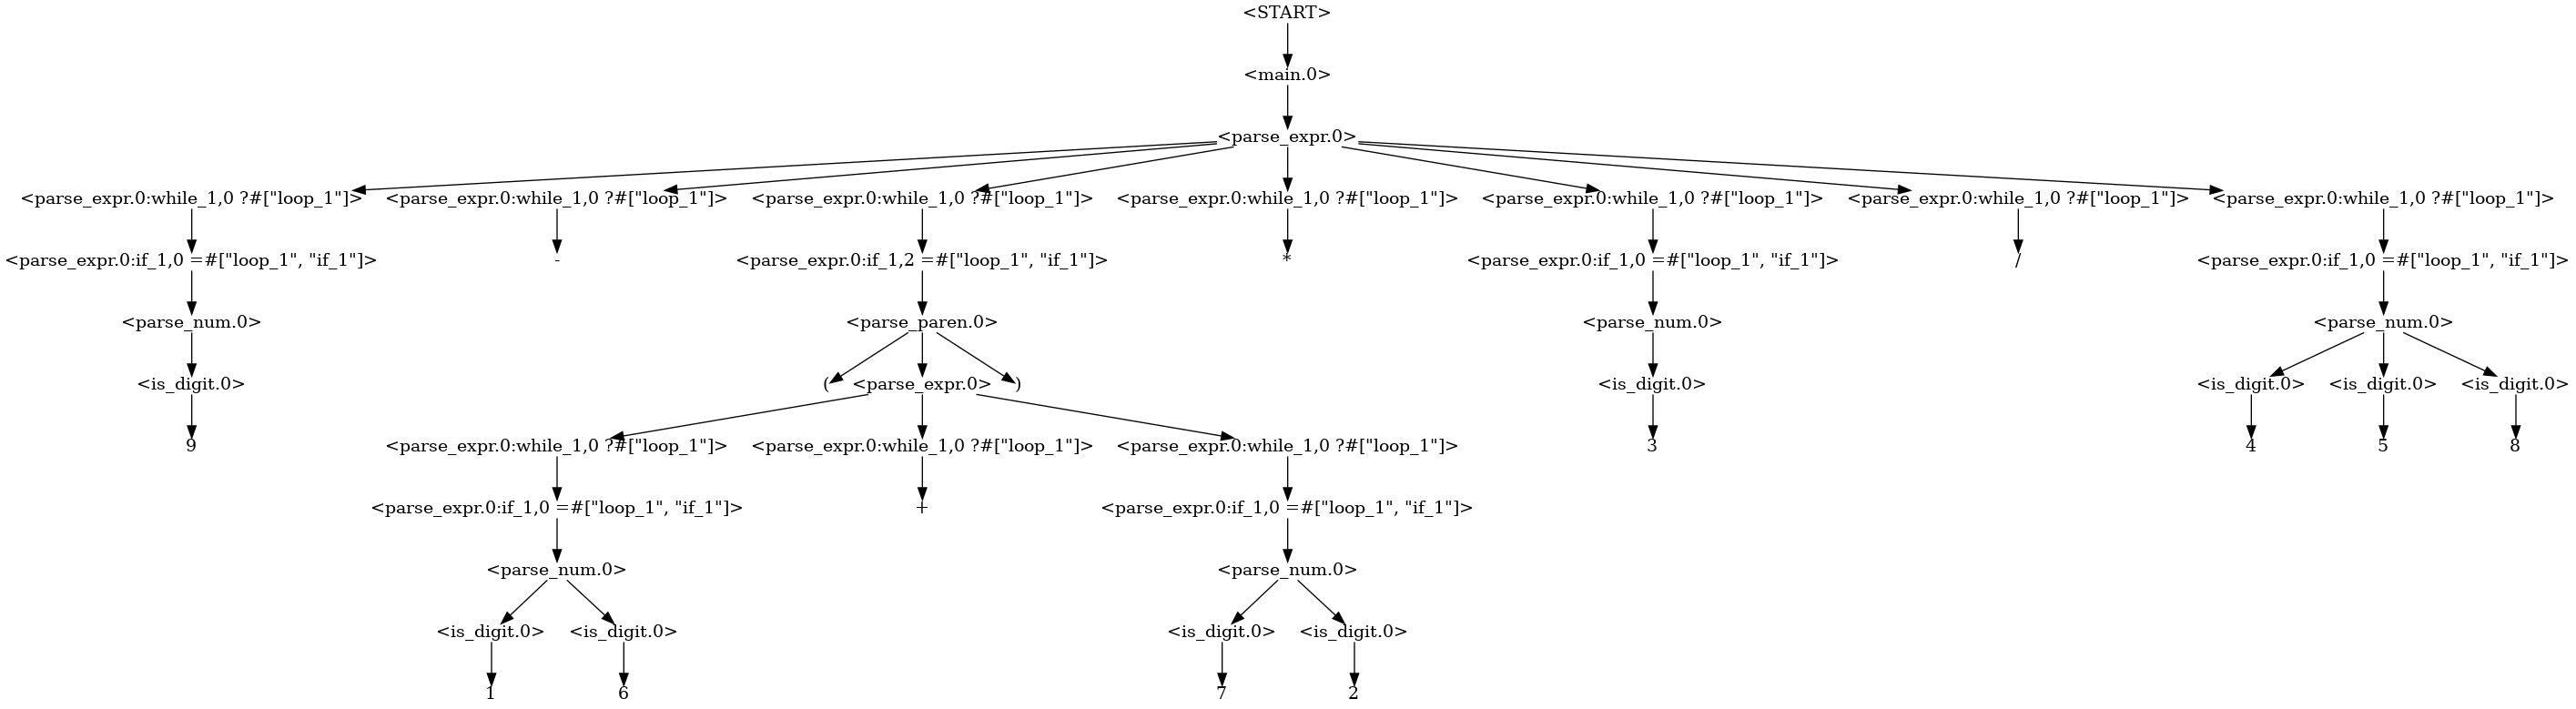

In [167]:
%top zoom(display_tree(mg_calc_trees[0]['tree']))

### Generalize Loops

We now define how to update a pseudoname to a new id (when we detect a new pattern).

In [168]:
def update_pseudo_name(k_m, my_id):
    # fixup k_m with what is in my_id
    original = k_m[0]
    method, ctrl, cid, altid, can_empty, method_stack = parse_pseudo_name(original)
    if ctrl == 'if':
        name = unparse_pseudo_name(method, ctrl, cid, "%s.%d" % (altid, my_id), can_empty, method_stack)
    elif ctrl == 'while':
        assert altid == '0'
        name = unparse_pseudo_name(method, ctrl, cid, my_id, can_empty, method_stack)
    else:
        assert False
    k_m[0] = name
    return name, k_m

def update_original_pseudo_names(node_name):
    registered_xnodes = NODE_REGISTER[node_name]
    for xnode in registered_xnodes:
        # name it according to its pattern
        nodeX, treeX, executableX, inputfileX, infoX = xnode
        pattern = infoX['pattern']
        update_pseudo_name(infoX['node'], pattern)

For generalizing pseudonodes, we need to collect them just like we did for methods.

In [169]:
def collect_pseudo_nodes(node, tree, executable, inputfile):
    node_name, children, si, ei = node
    if is_node_pseudo(node):
        register_node(node, tree, executable, inputfile)

    for child in children:
        collect_pseudo_nodes(child, tree, executable, inputfile)

For loops, we have a special processing that checks whether it can be deleted. If so, we would place `*` after their name. Else it is `+`

In [170]:
def can_the_loop_be_deleted(pattern, k, executable):
    xnodes = [xnode for xnode in NODE_REGISTER[k] if xnode[-1]['pattern'] == pattern]
    can_be_deleted = True
    for xnode in xnodes:
        node0, tree0, executable0, inputfile0, _info = xnode
        a = is_a_replaceable_with_b((node0, '', tree0), (['', [], 0, 0], '', tree0), executable)
        if not a:
            can_be_deleted = False
            break
    for xnode in xnodes:
        node0, tree0, executable0, inputfile0, info = xnode
        method1, ctrl1, cname1, num1, can_empty, cstack1 = parse_pseudo_name(node0[0])
        name = unparse_pseudo_name(method1, ctrl1, cname1, num1, Epsilon if can_be_deleted else NoEpsilon, cstack1)
        info['node'][0] = name

The main `generalize_loop_trees()` generalizes loops.

In [171]:
def generalize_loop_trees(jtrees, log=False):
    my_trees = []
    for j in jtrees:
        tree = to_modifiable(j['tree']) # The tree ds.
        executable = j['original']
        inputfile = j['arg']
        # we skip START
        node_name, children, *rest = tree
        assert node_name == '<START>'
        for child in children:
            collect_pseudo_nodes(tree, tree, executable, inputfile)
        my_trees.append({'tree':tree, 'original': executable, 'arg': inputfile})

    for k in NODE_REGISTER:
        patterns = identify_buckets(k)
        for p in patterns:
            can_the_loop_be_deleted(patterns[p], k, executable)

    # finally, update the original names.
    for k in NODE_REGISTER:
        if k == '<START>': continue
        update_original_pseudo_names(k)
    return my_trees

It is used as follows:

In [172]:
%top reset_generalizer()
%top lg_calc_trees = generalize_loop_trees(mg_calc_trees)

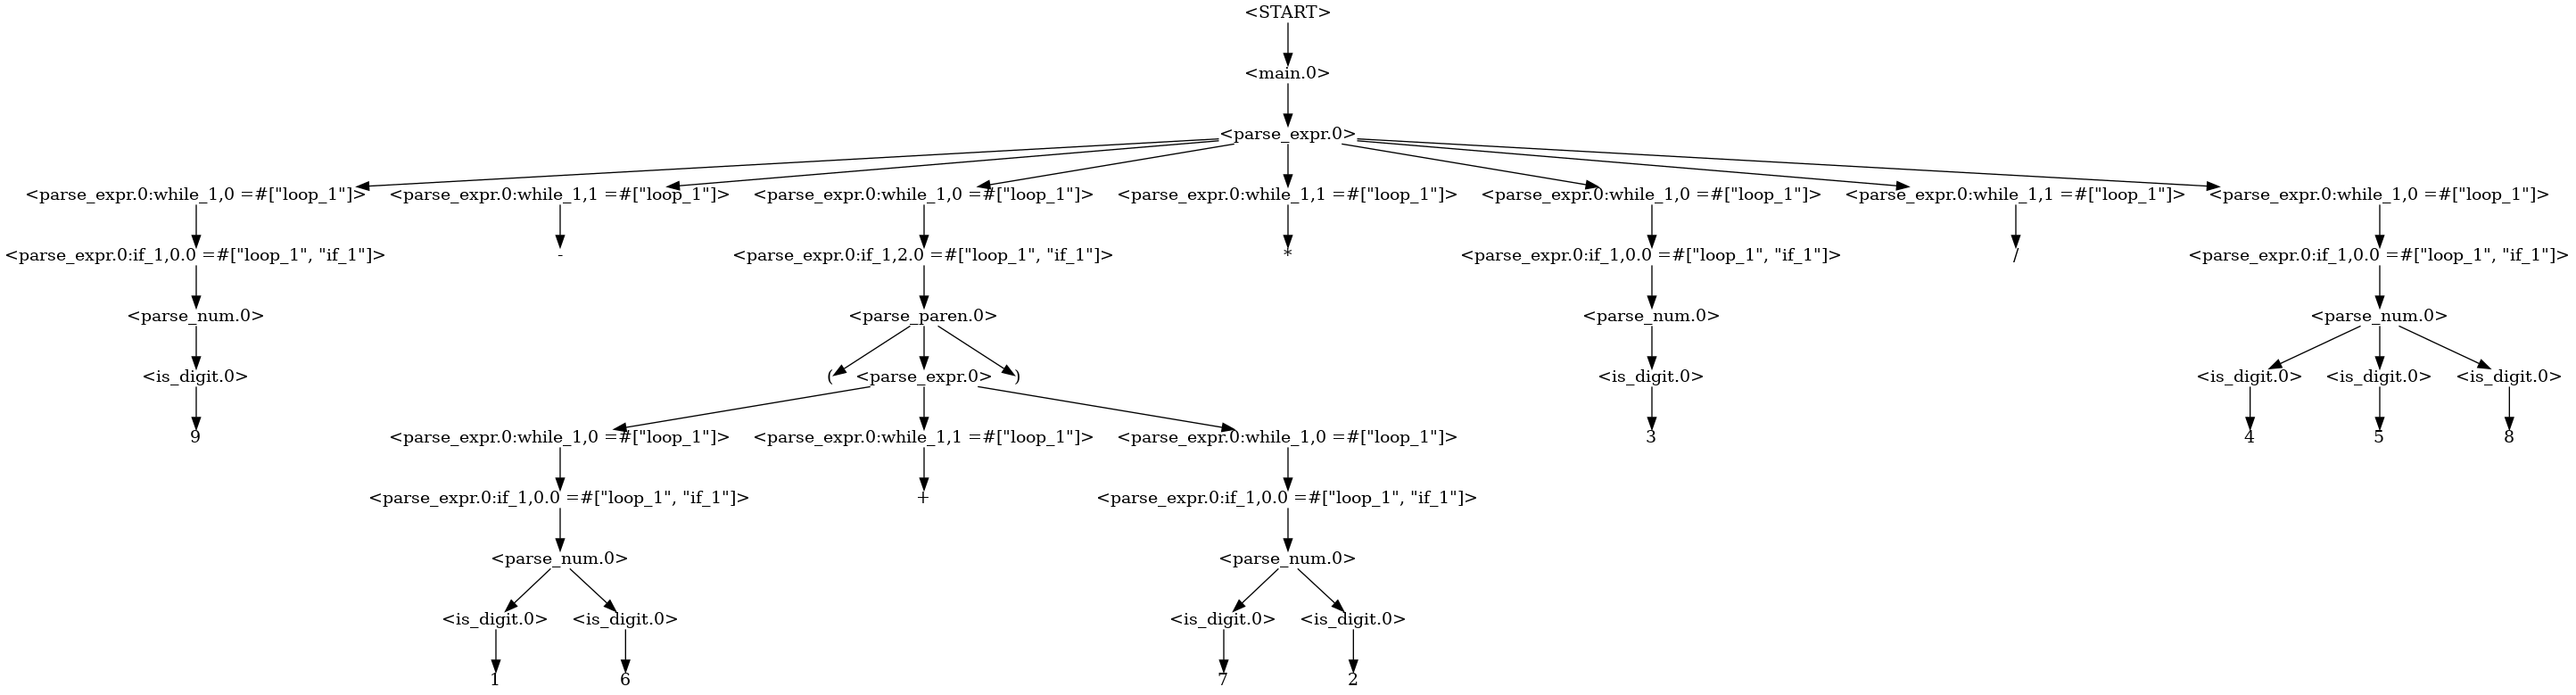

In [173]:
%top zoom(display_tree(lg_calc_trees[0]['tree']))

In [174]:
from fuzzingbook.GrammarFuzzer import extract_node as extract_node_o

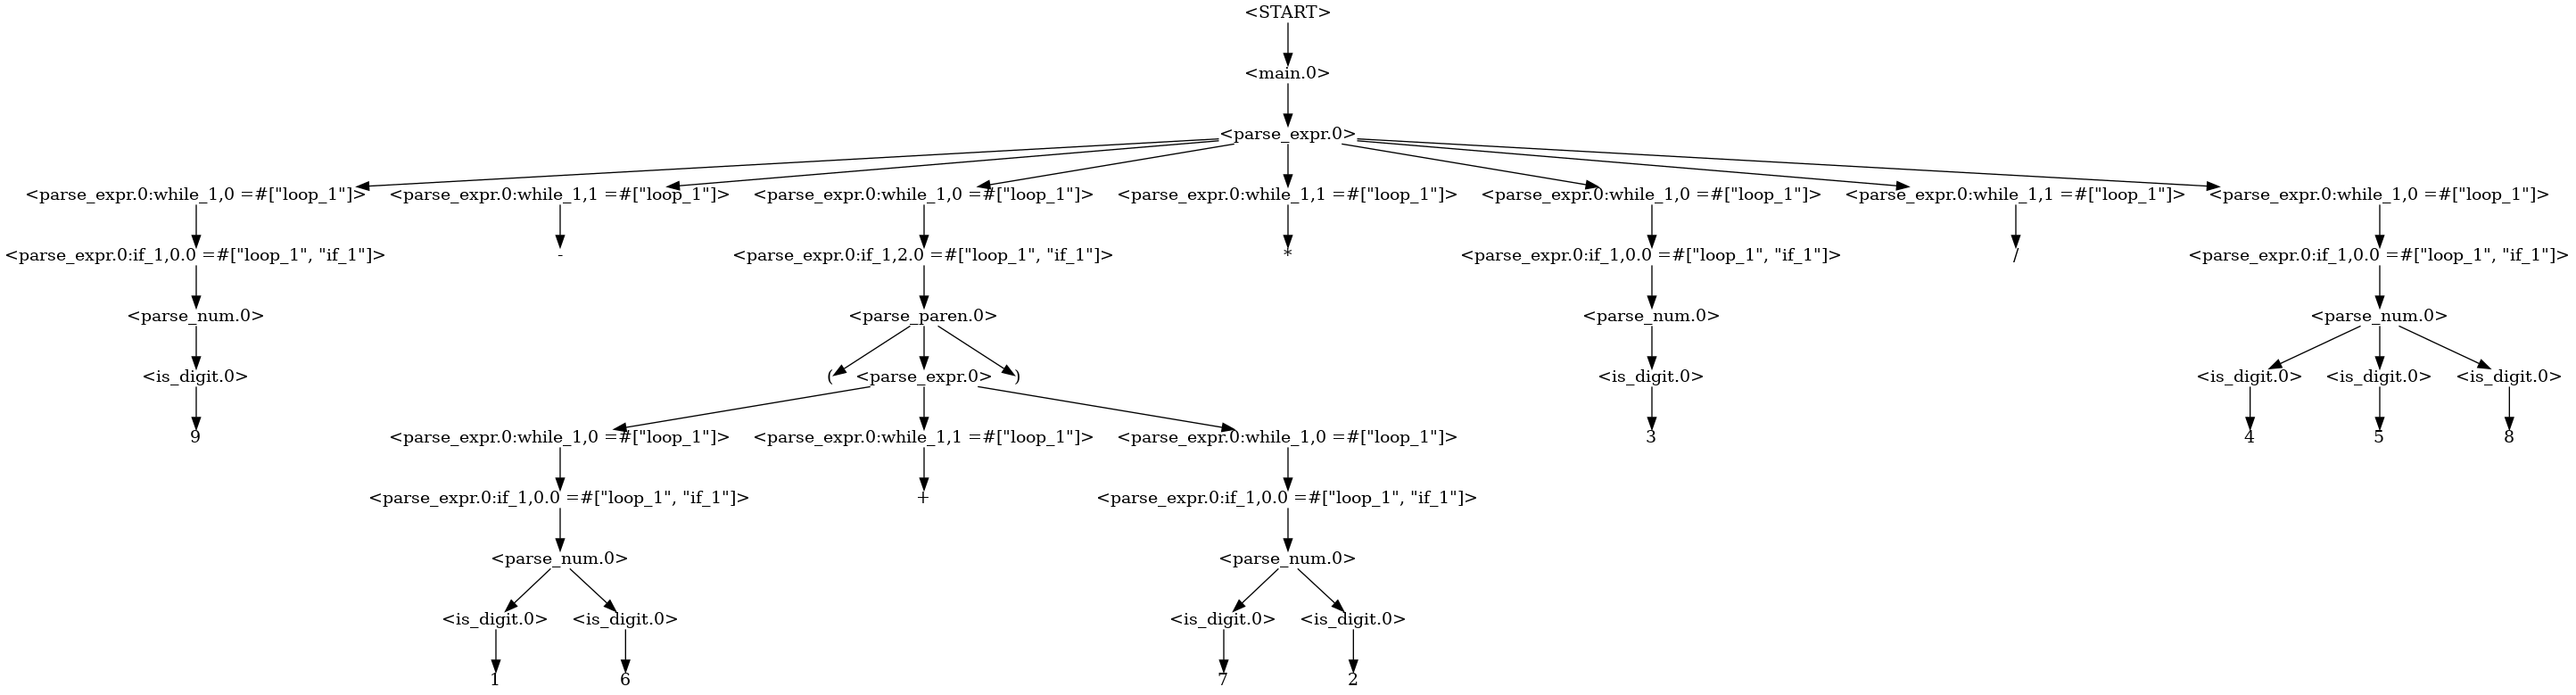

In [175]:
%top reset_generalizer()
%top generalized_calc_trees = generalize_loop_trees(mg_calc_trees)
%top zoom(display_tree(generalized_calc_trees[0]['tree'], extract_node=extract_node_o))

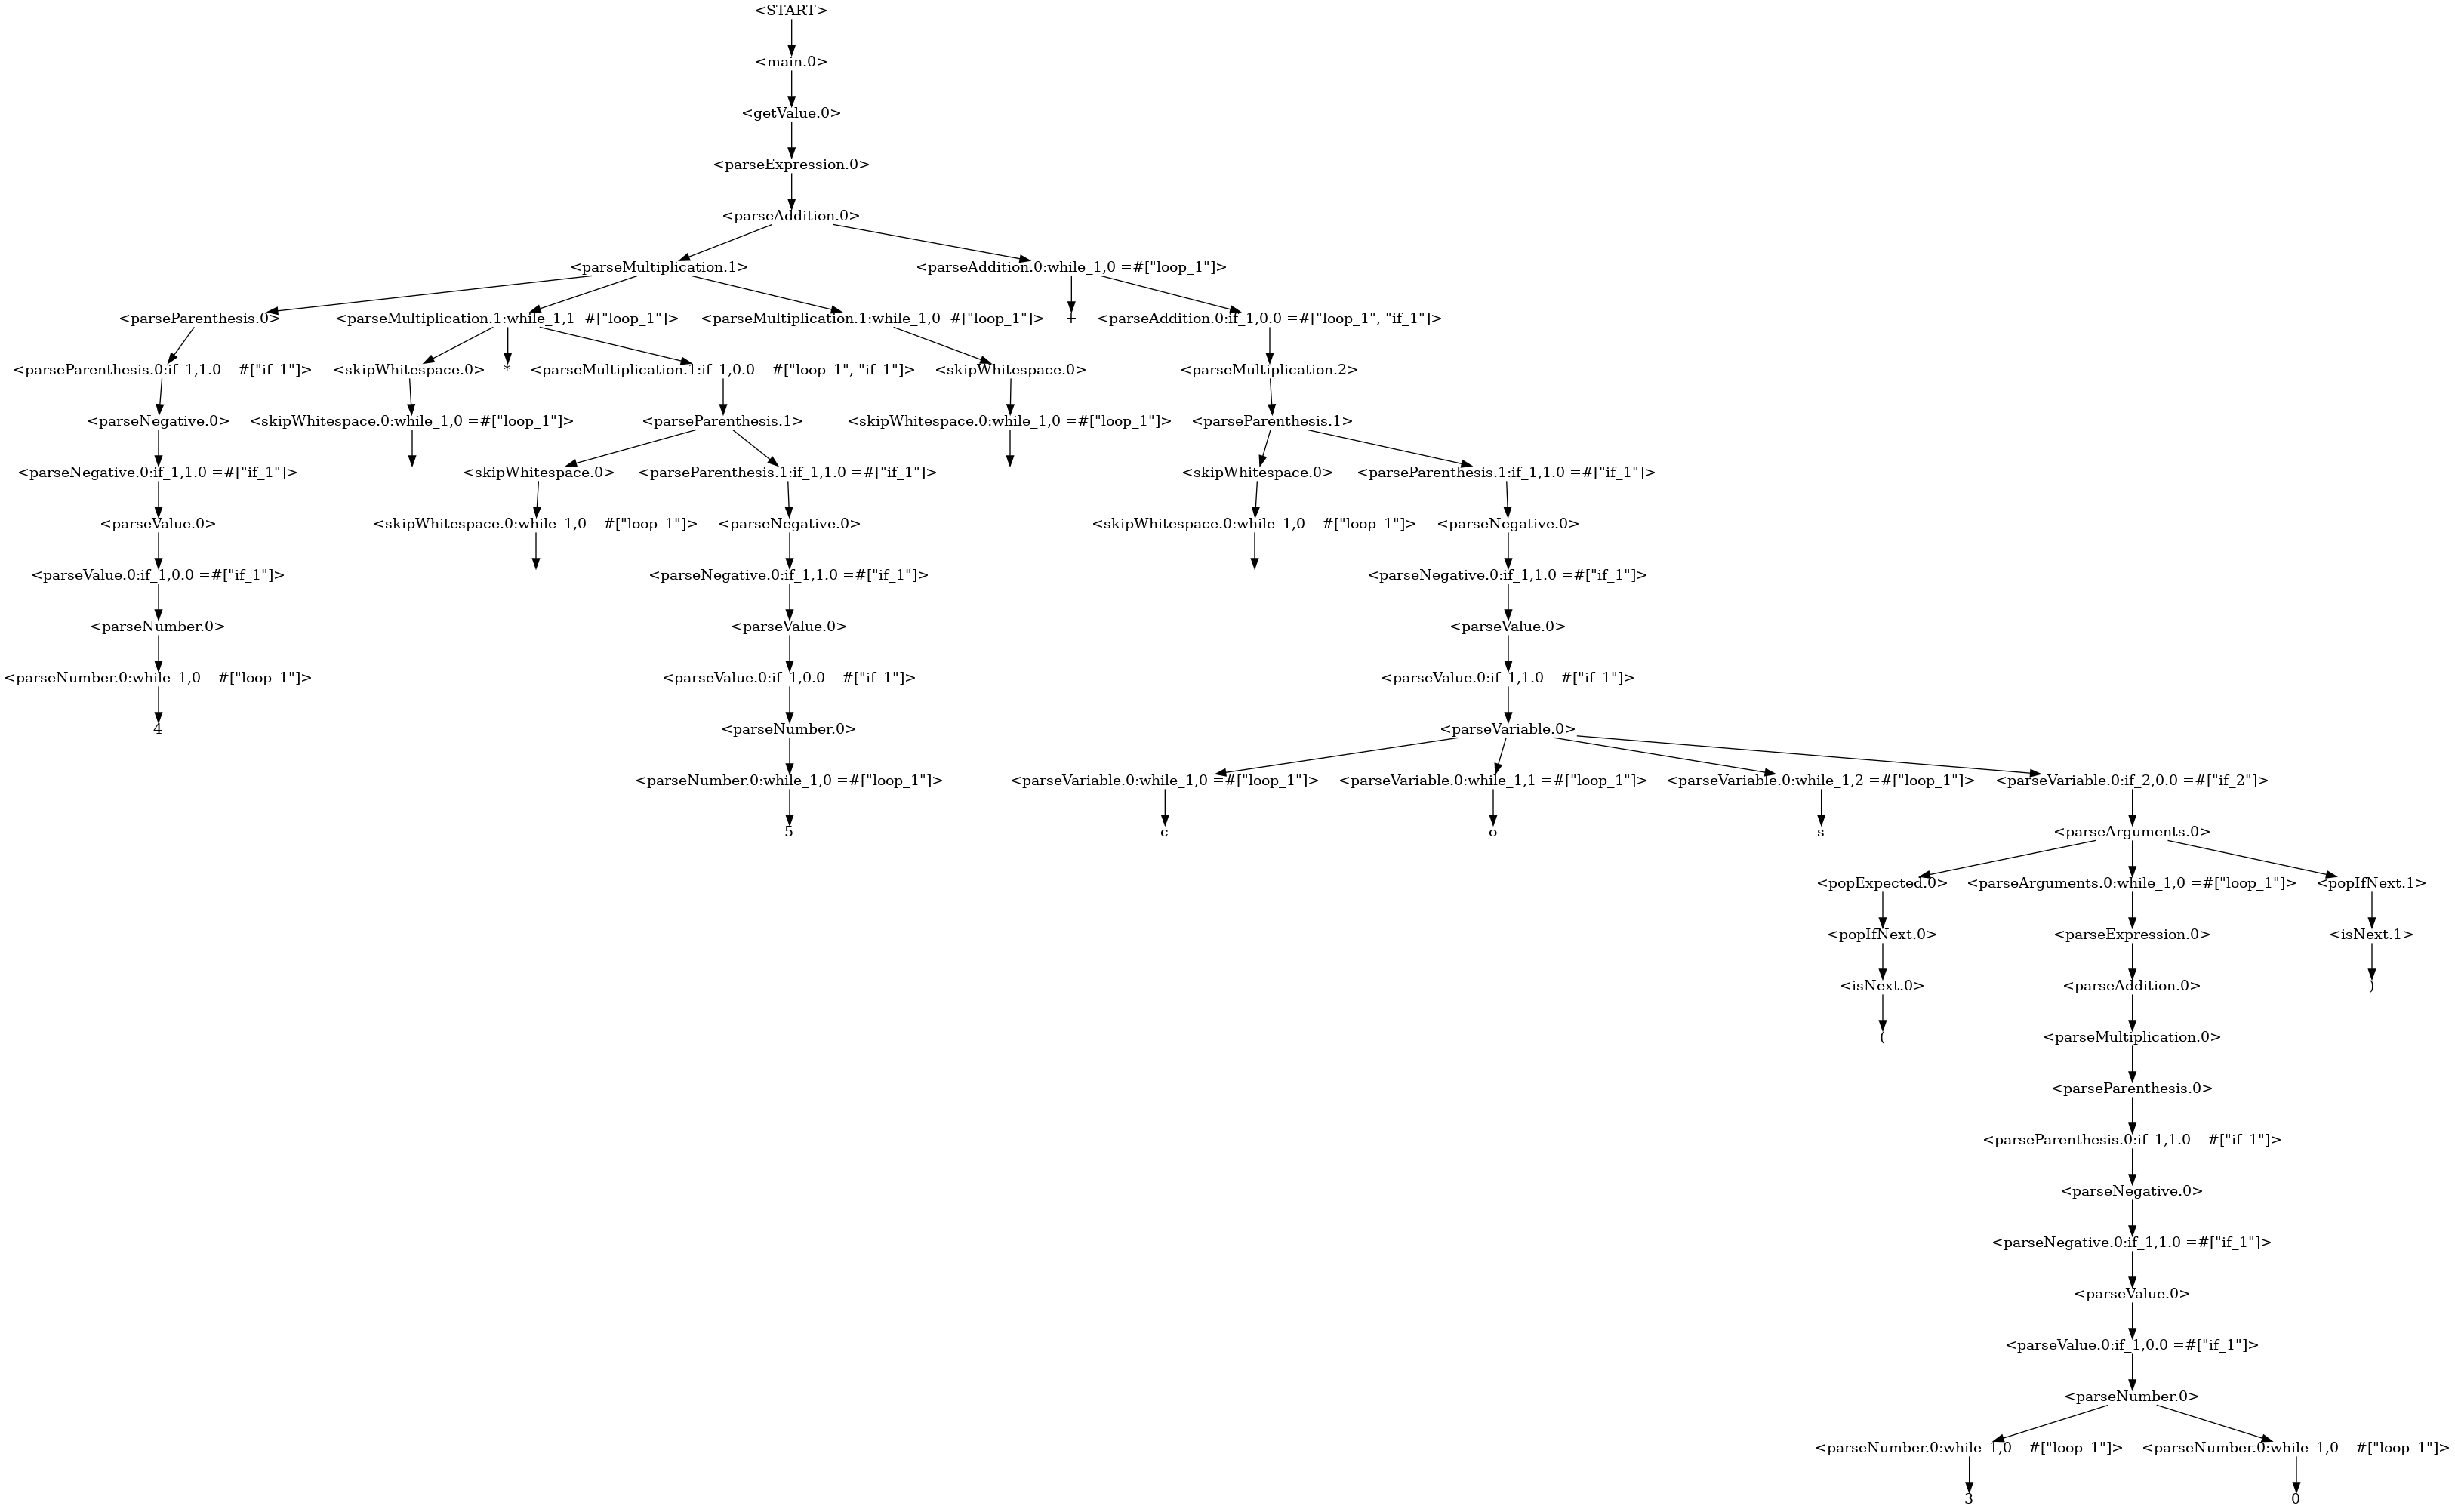

In [176]:
%top reset_generalizer()
%top generalized_mathexpr_trees = generalize_loop_trees(mg_mathexpr_trees)
%top zoom(display_tree(generalized_mathexpr_trees[2]['tree'], extract_node=extract_node_o))

## Generating a Grammar

Generating a grammar from the generalized derivation trees is pretty simple. Start at the start node, and any node that represents a method or a pseudo method becomes a nonterminal. The children forms alternate expansions for the nonterminal. Since all the keys are compatible, merging the grammar is simply merging the hash map.

First, we define a pretty printer for grammar.

In [177]:
import re
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

In [178]:
def recurse_grammar(grammar, key, order, canonical):
    rules = sorted(grammar[key])
    old_len = len(order)
    for rule in rules:
        if not canonical:
            res =  re.findall(RE_NONTERMINAL, rule)
        else:
            res = rule
        for token in res:
            if token.startswith('<') and token.endswith('>'):
                if token not in order:
                    order.append(token)
    new = order[old_len:]
    for ckey in new:
        recurse_grammar(grammar, ckey, order, canonical)

In [179]:
def show_grammar(grammar, start_symbol='<START>', canonical=True):
    order = [start_symbol]
    recurse_grammar(grammar, start_symbol, order, canonical)
    if len(order) != len(grammar.keys()):
        assert len(order) < len(grammar.keys())
    return {k: sorted(grammar[k]) for k in order}

### Trees to grammar

In [180]:
def to_grammar(tree, grammar):
    node, children, _, _ = tree
    if not children: return grammar
    tokens = []
    if node not in grammar:
        grammar[node] = list()
    for c in children:
        tokens.append(c[0])
        to_grammar(c, grammar)
    grammar[node].append(tuple(tokens))
    return grammar

In [181]:
def merge_grammar(g1, g2):
    all_keys = set(list(g1.keys()) + list(g2.keys()))
    merged = {}
    for k in all_keys:
        alts = set(g1.get(k, []) + g2.get(k, []))
        merged[k] = alts
    return {k:[l for l in merged[k]] for k in merged}

In [182]:
def convert_to_grammar(my_trees):
    grammar = {}
    ret = []
    for my_tree in my_trees:
        tree = my_tree['tree']
        start = tree[0]
        src_file = my_tree['original']
        arg_file = my_tree['arg']
        ret.append((start, src_file, arg_file))
        g = to_grammar(tree, grammar)
        grammar = merge_grammar(grammar, g)
    return grammar

In [183]:
%top calc_grammar = convert_to_grammar(generalized_calc_trees)
%top show_grammar(calc_grammar)

{'<START>': [('<main.0>',)],
 '<main.0>': [('<parse_expr.0>',)],
 '<parse_expr.0>': [('<parse_expr.0:while_1,0 =#["loop_1"]>',),
  ('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>'),
  ('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>'),
  ('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>')],
 '<parse_expr.0:while_1,0 =#["loop_1"]>': [('<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]>',),
  ('<parse_expr.0:if_1,2.0 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,1 =#["loop_1"]>': [('*',), ('+',), 

In [184]:
%top mathexpr_grammar = convert_to_grammar(generalized_mathexpr_trees)
%top show_grammar(mathexpr_grammar)

{'<START>': [('<main.0>',)],
 '<main.0>': [('<getValue.0>',)],
 '<getValue.0>': [('<parseExpression.0>',)],
 '<parseExpression.0>': [('<parseAddition.0>',)],
 '<parseAddition.0>': [('<parseMultiplication.0>',),
  ('<parseMultiplication.1>', '<parseAddition.0:while_1,0 =#["loop_1"]>')],
 '<parseMultiplication.0>': [('<parseParenthesis.0>',)],
 '<parseMultiplication.1>': [('<parseParenthesis.0>',
   '<parseMultiplication.1:while_1,0 -#["loop_1"]>'),
  ('<parseParenthesis.0>',
   '<parseMultiplication.1:while_1,1 -#["loop_1"]>',
   '<parseMultiplication.1:while_1,0 -#["loop_1"]>')],
 '<parseAddition.0:while_1,0 =#["loop_1"]>': [('+',
   '<parseAddition.0:if_1,0.0 =#["loop_1", "if_1"]>')],
 '<parseParenthesis.0>': [('<parseParenthesis.0:if_1,1.0 =#["if_1"]>',)],
 '<parseParenthesis.0:if_1,1.0 =#["if_1"]>': [('<parseNegative.0>',)],
 '<parseNegative.0>': [('<parseNegative.0:if_1,1.0 =#["if_1"]>',)],
 '<parseNegative.0:if_1,1.0 =#["if_1"]>': [('<parseValue.0>',)],
 '<parseValue.0>': [('<pars

In [185]:
%%top
# [(
gf = LimitFuzzer(mathexpr_grammar)
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

5 + 105
42 + 15
22 * 255 + 2
33
250 * 5 + 40
031
352 * 31 + 353
4 * 5 + 204
003
43 + 52


### Inserting Empty Alternatives for IF and Loops

Next, we want to insert empty rules for those loops and conditionals that can be skipped. For loops, the entire sequence has to contain the empty marker.

In [186]:
def check_empty_rules(grammar):
    new_grammar = {}
    for k in grammar:
        if k in ':if_':
            name, marker = k.split('#')
            if name.endswith(' *'):
                new_grammar[k] = grammar[k].add(('',))
            else:
                new_grammar[k] = grammar[k]
        elif k in ':while_':
            # TODO -- we have to check the rules for sequences of whiles.
            # for now, ignore.
            new_grammar[k] = grammar[k]
        else:
            new_grammar[k] = grammar[k]
    return new_grammar

In [187]:
%top ne_calc_grammar = check_empty_rules(calc_grammar)
%top show_grammar(ne_calc_grammar)

{'<START>': [('<main.0>',)],
 '<main.0>': [('<parse_expr.0>',)],
 '<parse_expr.0>': [('<parse_expr.0:while_1,0 =#["loop_1"]>',),
  ('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>'),
  ('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>'),
  ('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,0 =#["loop_1"]>')],
 '<parse_expr.0:while_1,0 =#["loop_1"]>': [('<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]>',),
  ('<parse_expr.0:if_1,2.0 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,1 =#["loop_1"]>': [('*',), ('+',), 

In [188]:
%%top
# [(
gf = LimitFuzzer(ne_calc_grammar)
for i in range(10):
    print(repr(gf.fuzz(key='<START>')))
# )]

'(0*(79-3-09/3)*(43*185)-(19*71*028))+(867/56*(66))+((6+7-706*203)*(04-480+5*8))'
'((0*37-98))*487'
'931*((5*21-97/46)/95)+20*28'
'269*9*603'
'(88)-(524)+(815*(12/5/1)*5-(206+00-511))*928'
'(966/(355/81*778)+288-687)/(4)/((32-90))'
'647'
'54/46+858+((46-6)+(2-0/3-11)*7/(0*9))'
'2'
'72'


In [189]:
%top ne_mathexpr_grammar = check_empty_rules(mathexpr_grammar)
%top show_grammar(ne_mathexpr_grammar)

{'<START>': [('<main.0>',)],
 '<main.0>': [('<getValue.0>',)],
 '<getValue.0>': [('<parseExpression.0>',)],
 '<parseExpression.0>': [('<parseAddition.0>',)],
 '<parseAddition.0>': [('<parseMultiplication.0>',),
  ('<parseMultiplication.1>', '<parseAddition.0:while_1,0 =#["loop_1"]>')],
 '<parseMultiplication.0>': [('<parseParenthesis.0>',)],
 '<parseMultiplication.1>': [('<parseParenthesis.0>',
   '<parseMultiplication.1:while_1,0 -#["loop_1"]>'),
  ('<parseParenthesis.0>',
   '<parseMultiplication.1:while_1,1 -#["loop_1"]>',
   '<parseMultiplication.1:while_1,0 -#["loop_1"]>')],
 '<parseAddition.0:while_1,0 =#["loop_1"]>': [('+',
   '<parseAddition.0:if_1,0.0 =#["loop_1", "if_1"]>')],
 '<parseParenthesis.0>': [('<parseParenthesis.0:if_1,1.0 =#["if_1"]>',)],
 '<parseParenthesis.0:if_1,1.0 =#["if_1"]>': [('<parseNegative.0>',)],
 '<parseNegative.0>': [('<parseNegative.0:if_1,1.0 =#["if_1"]>',)],
 '<parseNegative.0:if_1,1.0 =#["if_1"]>': [('<parseValue.0>',)],
 '<parseValue.0>': [('<pars

In [190]:
%%top
# [(
gf = LimitFuzzer(ne_mathexpr_grammar)
for i in range(10):
    print(repr(gf.fuzz(key='<START>')))
# )]

'431'
'05 * 01 + 4'
'11'
'02 + 444'
'153 * 135 + 22'
'34'
'2'
'332'
'315 + 1'
'222 + 541'


### Learning Regular Expressions

We now need to generalize the loops. The idea is to look for patterns exclusively in the similarly named while loops using any of the regular expression learners. For the prototype, we replaced the modified Sequitur with the modified Fernau which gave us better regular expressions than before. The main constraint we have is that we want to avoid repeated execution of program if possible. Fernau algorithm can recover a reasonably approximate regular exression based only on positive data.

#### The modified Fernau algorithm

The Fernau algorithm is from _Algorithms for learning regular expressions from positive data_ by _HenningFernau_. Our algorithm uses a modified form of the Prefix-Tree-Acceptor from Fernau. First we define an LRF buffer of a given size.

In [191]:
class Buf:
    def __init__(self, size):
        self.size = size
        self.items = [None] * self.size

The `add1()` takes in an array, and transfers the first element of the array into the end of current buffer, and simultaneously drops the first element of the buffer.

In [192]:
class Buf(Buf):
    def add1(self, items):
        self.items.append(items.pop(0))
        return self.items.pop(0)

For equality between the buffer and an array, we only compare when both the array and the items are actually elements and not chunked arrays.

In [193]:
class Buf(Buf):
    def __eq__(self, items):
        if any(isinstance(i, dict) for i in self.items): return False
        if any(isinstance(i, dict) for i in items): return False
        return items == self.items

The `detect_chunks()` detects any repeating portions of a list of `n` size.

In [194]:
def detect_chunks(n, lst_):
    lst = list(lst_)
    chunks = set()
    last = Buf(n)
    # check if the next_n elements are repeated.
    for _ in range(len(lst) - n):
        lnext_n = lst[0:n]
        if last == lnext_n:
            # found a repetition.
            chunks.add(tuple(last.items))
        else:
            pass
        last.add1(lst)
    return chunks

Once we have detected plausible repeating sequences, we gather all similar sequences into arrays.

In [195]:
def chunkify(lst_,n , chunks):
    lst = list(lst_)
    chunked_lst = []
    while len(lst) >= n:
        lnext_n = lst[0:n]
        if (not any(isinstance(i, dict) for i in lnext_n)) and tuple(lnext_n) in chunks:
            chunked_lst.append({'_':lnext_n})
            lst = lst[n:]
        else:
            chunked_lst.append(lst.pop(0))
    chunked_lst.extend(lst)
    return chunked_lst

The `identify_chunks()` simply calls the `detect_chunks()` on all given lists, and then converts all chunks identified into arrays.

In [196]:
def identify_chunks(my_lsts):
    # initialize
    all_chunks = {}
    maximum = max(len(lst) for lst in my_lsts)
    for i in range(1, maximum//2+1):
        all_chunks[i] = set()

    # First, identify chunks in each list.
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = detect_chunks(i, lst)
            all_chunks[i] |= chunks

    # Then, chunkify
    new_lsts = []
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = all_chunks[i]
            lst = chunkify(lst, i, chunks)
        new_lsts.append(lst)
    return new_lsts

##### Prefix tree acceptor

The prefix tree acceptor is a way to represent positive data. The `Node` class holds a single node in the prefix tree acceptor.

In [197]:
class Node:
    # Each tree node gets its unique id.
    _uid = 0
    def __init__(self, item):
        # self.repeats = False
        self.count = 1 # how many repetitions.
        self.counters = set()
        self.last = False
        self.children = []
        self.item = item
        self.uid = Node._uid
        Node._uid += 1

    def update_counters(self):
        self.counters.add(self.count)
        self.count = 0
        for c in self.children:
            c.update_counters()

    def __repr__(self):
        return str(self.to_json())

    def __str__(self):
        return str("(%s, [%s])", (self.item, ' '.join([str(i) for i in self.children])))

    def to_json(self):
        s = ("(%s)" % ' '.join(self.item['_'])) if isinstance(self.item, dict) else str(self.item)
        return (s, tuple(self.counters), [i.to_json() for i in self.children])

    def inc_count(self):
        self.count += 1

    def add_ref(self):
        self.count = 1

    def get_child(self, c):
        for i in self.children:
            if i.item == c: return i
        return None

    def add_child(self, c):
        # first check if it is the current node. If it is, increment
        # count, and return ourselves.
        if c == self.item:
            self.inc_count()
            return self
        else:
            # check if it is one of the children. If it is a child, then
            # preserve its original count.
            nc = self.get_child(c)
            if nc is None:
                nc = Node(c)
                self.children.append(nc)
            else:
                nc.add_ref()
            return nc

The `update_tree()` essentially transforms a list of nodes to a chain of nodes starting at `root` if the `root` is an empty tree. If the `root` already contains a tree, the `update_tree()` traverses the path represented by `lst_` and makes a new child branch where the path specified doesn't exist in the tree.

In [198]:
def update_tree(lst_, root):
    lst = list(lst_)
    branch = root
    while lst:
        first, *lst = lst
        branch = branch.add_child(first)
    branch.last = True
    return root

Given a number of lists, the `create_tree_with_lists()` creates an actual tree out of these lists.

In [199]:
def create_tree_with_lsts(lsts):
    Node._uid = 0
    root =  Node(None)
    for lst in lsts:
        root.count = 1 # there is at least one element.
        update_tree(lst, root)
        root.update_counters()
    return root

Given a node, and a key, return the key and alts as a dict.

In [200]:
def get_star(node, key):
    if node.item is None:
        return [], {}
    if isinstance(node.item, dict):
        # take care of counters
        elements = node.item['_']
        my_key = "<%s-%d-s>" % (key, node.uid)
        alts = [elements]
        if len(node.counters) > 1: # repetition
            alts.append(elements + [my_key])
        return [my_key], {my_key:alts}
    else:
        return [str(node.item)], {}

In [201]:
def node_to_grammar(node, grammar, key):
    rule = []
    alts = [rule]
    if node.uid == 0:
        my_key = "<%s>" % key
    else:
        my_key = "<%s-%d>" % (key, node.uid)
    grammar[my_key] = alts
    if node.item is not None:
        mk, g = get_star(node, key)
        rule.extend(mk)
        grammar.update(g)
    # is the node last?
    if node.last:
        assert node.item is not None
        # add a duplicate rule that ends here.
        ending_rule = list(rule)
        # if there are no children, the current rule is
        # any way ending.
        if node.children:
            alts.append(ending_rule)

    if node.children:
        if len(node.children) > 1:
            my_ckey = "<%s-%d-c>" % (key, node.uid)
            rule.append(my_ckey)
            grammar[my_ckey] = [ ["<%s-%d>" % (key, c.uid)] for c in node.children]
        else:
            my_ckey = "<%s-%d>" % (key, node.children[0].uid)
            rule.append(my_ckey)
    else:
        pass
    for c in node.children:
        node_to_grammar(c, grammar, key)
    return grammar

def generate_grammar(lists, key):
    lsts = identify_chunks(lists)
    tree = create_tree_with_lsts(lsts)
    grammar = {}
    node_to_grammar(tree, grammar, key)
    return grammar

Given a rule, determine the abstraction for it.

In [202]:
def collapse_alts(rules, k):
    ss = [[str(r) for r in rule] for rule in rules]
    x = generate_grammar(ss, k[1:-1])
    return x

In [203]:
def collapse_rules(grammar):
    r_grammar = {}
    for k in grammar:
        new_grammar = collapse_alts(grammar[k], k)
        # merge the new_grammar with r_grammar
        # we know none of the keys exist in r_grammar because
        # new keys are k prefixed.
        for k_ in new_grammar:
            r_grammar[k_] = new_grammar[k_]
    return r_grammar

In [204]:
%top collapsed_calc_grammar = collapse_rules(ne_calc_grammar)
%top show_grammar(collapsed_calc_grammar)

{'<START>': [['<START-1>']],
 '<START-1>': [['<main.0>']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<parse_expr.0>']],
 '<parse_expr.0>': [['<parse_expr.0-0-c>']],
 '<parse_expr.0-0-c>': [['<parse_expr.0-1>'], ['<parse_expr.0-3>']],
 '<parse_expr.0-1>': [['<parse_expr.0-1-s>', '<parse_expr.0-2>']],
 '<parse_expr.0-3>': [['<parse_expr.0:while_1,0 =#["loop_1"]>']],
 '<parse_expr.0-1-s>': [['<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>'],
  ['<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0-1-s>']],
 '<parse_expr.0-2>': [['<parse_expr.0:while_1,0 =#["loop_1"]>']],
 '<parse_expr.0:while_1,0 =#["loop_1"]>': [['<parse_expr.0:while_1,0 =#["loop_1"]-0-c>']],
 '<parse_expr.0:while_1,1 =#["loop_1"]>': [['<parse_expr.0:while_1,1 =#["loop_1"]-0-c>']],
 '<parse_expr.0:while_1,0 =#["loop_1"]-0-c>': [['<parse_expr.0:while_1,0 =#["loop_1"]-1>'],
  ['<parse_expr.0:while_1,0 =#["loop_1"]-2>']],
 '<parse_exp

In [205]:
%%top
# [(
gf = LimitFuzzer(ne_mathexpr_grammar)
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

113 * 53 + 1
512 + 15
2
400 * 3 + 5
22
1 + 5
4
42 * 103 + 003
305
3


In [206]:
%top collapsed_mathexpr_grammar = collapse_rules(ne_mathexpr_grammar)
%top show_grammar(collapsed_mathexpr_grammar)

{'<START>': [['<START-1>']],
 '<START-1>': [['<main.0>']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<getValue.0>']],
 '<getValue.0>': [['<getValue.0-1>']],
 '<getValue.0-1>': [['<parseExpression.0>']],
 '<parseExpression.0>': [['<parseExpression.0-1>']],
 '<parseExpression.0-1>': [['<parseAddition.0>']],
 '<parseAddition.0>': [['<parseAddition.0-0-c>']],
 '<parseAddition.0-0-c>': [['<parseAddition.0-1>'], ['<parseAddition.0-3>']],
 '<parseAddition.0-1>': [['<parseMultiplication.1>', '<parseAddition.0-2>']],
 '<parseAddition.0-3>': [['<parseMultiplication.0>']],
 '<parseMultiplication.1>': [['<parseMultiplication.1-1>']],
 '<parseAddition.0-2>': [['<parseAddition.0:while_1,0 =#["loop_1"]>']],
 '<parseMultiplication.1-1>': [['<parseParenthesis.0>',
   '<parseMultiplication.1-1-c>']],
 '<parseParenthesis.0>': [['<parseParenthesis.0-1>']],
 '<parseMultiplication.1-1-c>': [['<parseMultiplication.1-2>'],
  ['<parseMultiplication.1-3>']],
 '<parseParenthesis.0-1>': [['<parseParenthesi

In [207]:
%%top
# [(
gf = LimitFuzzer(collapsed_mathexpr_grammar)
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

4 + 0
4 + 0
3
3
2 + 2
4 + 1
4 + 5
1
4 + 5
1


In [208]:
%%top
# [(
gf = LimitFuzzer(collapsed_calc_grammar)
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

4
(2)
9
(9)/0*0/8-(4)
(3)
(5)
(8*3)-7-6-7+5-8+(9+1/3)
(2)
1+(9)
6


In [209]:
def convert_spaces_in_keys(grammar):
    keys = {key: key.replace(' ', '_') for key in grammar}
    new_grammar = {}
    for key in grammar:
        new_alt = []
        for rule in grammar[key]:
            new_rule = []
            for t in rule:
                for k in keys:
                    t = t.replace(k, keys[k])
                new_rule.append(t)
            new_alt.append(new_rule)
        new_grammar[keys[key]] = new_alt
    return new_grammar

In [210]:
%top calc_grammar = convert_spaces_in_keys(collapsed_calc_grammar)
%top show_grammar(calc_grammar, canonical=True)

{'<START>': [['<START-1>']],
 '<START-1>': [['<main.0>']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<parse_expr.0>']],
 '<parse_expr.0>': [['<parse_expr.0-0-c>']],
 '<parse_expr.0-0-c>': [['<parse_expr.0-1>'], ['<parse_expr.0-3>']],
 '<parse_expr.0-1>': [['<parse_expr.0-1-s>', '<parse_expr.0-2>']],
 '<parse_expr.0-3>': [['<parse_expr.0:while_1,0_=#["loop_1"]>']],
 '<parse_expr.0-1-s>': [['<parse_expr.0:while_1,0_=#["loop_1"]>',
   '<parse_expr.0:while_1,1_=#["loop_1"]>'],
  ['<parse_expr.0:while_1,0_=#["loop_1"]>',
   '<parse_expr.0:while_1,1_=#["loop_1"]>',
   '<parse_expr.0-1-s>']],
 '<parse_expr.0-2>': [['<parse_expr.0:while_1,0_=#["loop_1"]>']],
 '<parse_expr.0:while_1,0_=#["loop_1"]>': [['<parse_expr.0:while_1,0_=#["loop_1"]-0-c>']],
 '<parse_expr.0:while_1,1_=#["loop_1"]>': [['<parse_expr.0:while_1,1_=#["loop_1"]-0-c>']],
 '<parse_expr.0:while_1,0_=#["loop_1"]-0-c>': [['<parse_expr.0:while_1,0_=#["loop_1"]-1>'],
  ['<parse_expr.0:while_1,0_=#["loop_1"]-2>']],
 '<parse_exp

In [211]:
from fuzzingbook import GrammarMiner, Parser

In [212]:
%top gf = LimitFuzzer(calc_grammar)

In [213]:
%%top
# [(
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

1-9
1
(3+9*9-1)*5/(4-9+1)
5*6-9/8
9-9*(2)
2/4
(5/7)
9
5+2-(4)
(5)


In [214]:
%top mathexpr_grammar = convert_spaces_in_keys(collapsed_mathexpr_grammar)
%top show_grammar(mathexpr_grammar)

{'<START>': [['<START-1>']],
 '<START-1>': [['<main.0>']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<getValue.0>']],
 '<getValue.0>': [['<getValue.0-1>']],
 '<getValue.0-1>': [['<parseExpression.0>']],
 '<parseExpression.0>': [['<parseExpression.0-1>']],
 '<parseExpression.0-1>': [['<parseAddition.0>']],
 '<parseAddition.0>': [['<parseAddition.0-0-c>']],
 '<parseAddition.0-0-c>': [['<parseAddition.0-1>'], ['<parseAddition.0-3>']],
 '<parseAddition.0-1>': [['<parseMultiplication.1>', '<parseAddition.0-2>']],
 '<parseAddition.0-3>': [['<parseMultiplication.0>']],
 '<parseMultiplication.1>': [['<parseMultiplication.1-1>']],
 '<parseAddition.0-2>': [['<parseAddition.0:while_1,0_=#["loop_1"]>']],
 '<parseMultiplication.1-1>': [['<parseParenthesis.0>',
   '<parseMultiplication.1-1-c>']],
 '<parseParenthesis.0>': [['<parseParenthesis.0-1>']],
 '<parseMultiplication.1-1-c>': [['<parseMultiplication.1-2>'],
  ['<parseMultiplication.1-3>']],
 '<parseParenthesis.0-1>': [['<parseParenthesi

In [215]:
%top gf = LimitFuzzer(mathexpr_grammar)

In [216]:
%%top
# [(
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

2 + 2
0 + 1
2 + 5
2 + 5
1
5
1
0
1 + 5
5


### Remove duplicate and redundant entries

**IMPORTANT** we indicate things that operate on canonical by _c, and those that operate on fuzzable by _f, and both by _cf

In [217]:
def first_in_chain(token, chain):
    while True:
        if token in chain:
            token = chain[token]
            assert isinstance(token, str)
        else:
            break
    return token

Return a new symbol for `grammar` based on `symbol_name`.

In [218]:
def new_symbol(grammar, symbol_name="<symbol>"):
    if symbol_name not in grammar:
        return symbol_name

    count = 1
    while True:
        tentative_symbol_name = symbol_name[:-1] + "-" + repr(count) + ">"
        if tentative_symbol_name not in grammar:
            return tentative_symbol_name
        count += 1

Replace keys that have a single token definition with the token in the defition.

In [219]:
def replacement_candidate_chains(grammar, ignores):
    to_replace = {}
    for k in grammar:
        if k in ignores: continue
        if len(grammar[k]) != 1: continue
        rule = grammar[k][0]
        if len(rule) != 1: continue
        if is_nt(rule[0]):
            to_replace[k] = rule[0]
        else:
            pass
    return to_replace

In [220]:
def replace_key_by_new_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        new_rules = []
        for rule in grammar[key]:
            new_rule = [keys_to_replace.get(token, token)
                        for token in rule]
            new_rules.append(new_rule)
        new_grammar[keys_to_replace.get(key, key)] = new_rules
    assert len(grammar) == len(new_grammar)
    return new_grammar

In [221]:
def replace_key_by_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue
        new_rules = []
        for rule in grammar[key]:
            for t in rule:
                assert isinstance(t, str)
            new_rule = [first_in_chain(token, keys_to_replace) for token in rule]
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

In [222]:
def remove_single_entries(grammar):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

Remove keys that have similar rules.

In [223]:
def collect_duplicate_rule_keys(grammar):
    collect = {}
    for k in grammar:
        salt = str(sorted(grammar[k]))
        if salt not in collect:
            collect[salt] = (k, set())
        else:
            collect[salt][1].add(k)
    return collect

In [224]:
def remove_duplicate_rule_keys(grammar):
    g = grammar
    while True:
        collect = collect_duplicate_rule_keys(g)
        keys_to_replace = {}
        for salt in collect:
            k, st = collect[salt]
            for s in st:
                keys_to_replace[s] = k
        if not keys_to_replace:
            break
        g = replace_key_by_key(g, keys_to_replace)
    return g

Remove all the control flow vestiges from names, and simply name them sequentially.

In [225]:
def collect_replacement_keys(grammar):
    g = deep_copy(grammar)
    to_replace = {}
    for k in grammar:
        if ':' in k:
            first, rest = k.split(':')
            sym = new_symbol(g, symbol_name=first + '>')
            assert sym not in g
            g[sym] = None
            to_replace[k] = sym
        else:
            continue
    return to_replace

Remove keys that are referred to only from a single rule, and which have a single alternative.
Import. This can't work on canonical representation. First, given a key, we figure out its distance to `<START>`.

This is different from `remove_single_entries()` in that, there we do not care if the key is being used multiple times. Here, we only replace keys that are referred to only once.

In [226]:
import math

In [227]:
def len_to_start(item, parents, start_symbol, seen=None):
    if seen is None: seen = set()
    if item in seen: return math.inf
    seen.add(item)
    if item == start_symbol: return 0
    else: return 1 + min(len_to_start(p, parents, start_symbol, seen)
                         for p in parents[item])

In [228]:
def order_by_length_to_start(items, parent_map, start_symbol):
    return sorted(items, key=lambda i: len_to_start(i, parent_map, start_symbol))

Next, we generate a map of `child -> [parents]`.

In [229]:
def get_parents_of_tokens(grammar, key, seen=None, parents=None):
    if parents is None: parents, seen = {}, set()
    if key in seen: return parents
    seen.add(key)
    for res in grammar[key]:
        for token in res:
            if not is_nt(token): continue
            parents.setdefault(token, []).append(key)
    for ckey in {i for i in  grammar if i not in seen}:
        get_parents_of_tokens(grammar, ckey, seen, parents)
    return parents

In [230]:
def remove_references(keys_to_replace):
    to_process = list(keys_to_replace.keys())
    updated_dict = {}
    references = {}
    order = []
    while to_process:
        key, *to_process = to_process
        rule = keys_to_replace[key]
        new_rule = []
        skip = False
        for token in rule:
            if token not in updated_dict:
                if token in to_process:
                    # so this token will get defined later. We simply postpone
                    # the processing of this key until that key is defined.
                    # TODO: check for cycles.
                    to_process.append(key)
                    references.setdefault(token, set()).add(key)
                    skip = True
                    break
                else:
                    new_rule.append(token)
            else:
                new_rule.extend(updated_dict[token])
        if not skip:
            order.append(key)
            updated_dict[key] = new_rule
    return updated_dict

In [231]:
def replace_keys_by_rule(grammar, keys_to_replace):
    # we now need to verify that none of the keys are part of the sequences.
    keys_to_replace = remove_references(keys_to_replace)

    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue

        new_rules = []
        for rule in grammar[key]:
            new_rule = []
            for token in rule:
                if token in keys_to_replace:
                    new_rule.extend(keys_to_replace[token])
                else:
                    new_rule.append(token)
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

Now, all together.

In [232]:
def remove_single_alts(grammar, start_symbol):
    single_alts = {p for p in grammar if len(grammar[p]) == 1 and p != start_symbol}

    child_parent_map = get_parents_of_tokens(grammar, start_symbol)
    assert len(child_parent_map) < len(grammar)

    single_refs = {p:child_parent_map[p] for p in single_alts if len(child_parent_map[p]) <= 1}

    ordered = order_by_length_to_start(single_refs, child_parent_map, start_symbol)

    for p in ordered:
        assert len(grammar[p]) == 1
        if not isinstance(grammar[p][0], str):
            print(p, grammar[p][0])

    keys_to_replace = {p:grammar[p][0] for p in ordered}
    g =  replace_keys_by_rule(grammar, keys_to_replace)
    return g

remove similar rules from under a single key

In [233]:
def len_rule(r): return len(r)
def len_definition(d): return sum([len_rule(r) for r in d])
def len_grammar(g): return sum([len_definition(g[k]) for k in g])

In [234]:
def remove_duplicate_rules_in_a_key(g):
    g_ = {}
    for k in g:
        s = {str(r):r for r in g[k]}
        g_[k] = list(sorted(list(s.values())))
    return g_

In [235]:
def grammar_gc(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sorted(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    assert len(order) == len(grammar.keys())
    g = {k: sorted(grammar[k]) for k in order}
    for k in g:
        for r in g[k]:
            for t in r:
                assert isinstance(t, str)
    return g

In [236]:
def cleanup_grammar(g, start_symbol):
    g = grammar_gc(g, start_symbol)
    g1 = check_empty_rules(g) # add optional rules
    g1 = grammar_gc(g1, start_symbol)
 
    g2 = collapse_rules(g1) # learn regex
    g2 = grammar_gc(g2, start_symbol)

    g3 = convert_spaces_in_keys(g2) # fuzzable grammar
    g3 = grammar_gc(g3, start_symbol)
    return g3

In [237]:
def remove_single_entry_chains(grammar, start_symbol):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

In [238]:
def cleanup_token_names(grammar):
    keys_to_replace = collect_replacement_keys(grammar)
    g = replace_key_by_new_key(grammar, keys_to_replace)
    return g

In [239]:
def remove_self_definitions(g):
    g_ = {}
    for k in g:
        rs_ = []
        for r in g[k]:
            assert not isinstance(r, str)
            if len(r) == 1 and r[0] == k: continue
            rs_.append(r)
        g_[k] = rs_
    return g_

In [240]:
def compact_grammar(e, start_symbol):
    assert start_symbol in e
    l = len_grammar(e)
    diff = 1
    while diff > 0:
        assert start_symbol in e
        e = remove_single_entry_chains(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rule_keys(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = cleanup_token_names(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_single_alts(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rules_in_a_key(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_self_definitions(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        l_ = len_grammar(e)
        diff = l - l_
        l = l_
    e = grammar_gc(e, start_symbol)
    return e

## Accio Grammar

In [241]:
import os
import hashlib

In [242]:
from fuzzingbook.Parser import non_canonical, canonical

In [243]:
def accio_grammar(fname, src, samples, cache=True):
    hash_id = hashlib.md5(json.dumps(samples).encode()).hexdigest()
    cache_file = "build/%s_%s_generalized_tree.json" % (fname, hash_id)
    if os.path.exists(cache_file) and cache:
        with open(cache_file) as f:
            generalized_tree = json.load(f)
    else:
    # regenerate the program
        program_src[fname] = src
        with open('subjects/%s' % fname, 'w+') as f:
            print(src, file=f) 
        resrc = rewrite(src, fname)
        with open('build/%s' % fname, 'w+') as f:
            print(resrc, file=f)
        os.makedirs('samples/%s' % fname, exist_ok=True)
        sample_files = {("samples/%s/%d.csv"%(fname,i)):s for i,s in enumerate(samples)}
        for k in sample_files:
            with open(k, 'w+') as f:
                print(sample_files[k], file=f)

        call_trace = []
        for i in sample_files:
            thash_id = hashlib.md5(json.dumps(sample_files[i]).encode()).hexdigest()
            trace_cache_file = "build/%s_%s_trace.json" % (fname, thash_id)
            if os.path.exists(trace_cache_file) and cache:
                with open(trace_cache_file) as f:
                    my_tree = f.read()
            else:
                my_tree = do(["python3", "./build/%s" % fname, i]).stdout
                with open(trace_cache_file, 'w+') as f:
                    print(my_tree, file=f)
            call_trace.append(json.loads(my_tree)[0])

        mined_tree = miner(call_trace)
        reset_generalizer()
        generalized_m_tree = generalize_method_trees(mined_tree)
        reset_generalizer()
        generalized_tree = generalize_loop_trees(generalized_m_tree)
        reset_generalizer()
        # costly data structure.
        with open(cache_file, 'w+') as f:
            json.dump(generalized_tree, f)
    g0 = convert_to_grammar(generalized_tree)
    with open('build/%s_grammar_0.json' % fname, 'w+') as f:
        json.dump(g0, f)
    assert '<START>' in g0
    g = cleanup_grammar(g0, start_symbol='<START>')
    with open('build/%s_grammar_first.json' % fname, 'w+') as f:
        json.dump(g, f)
    g = compact_grammar(g, start_symbol='<START>')
    with open('build/%s_grammar.json' % fname, 'w+') as f:
        json.dump(g, f)
    return show_grammar(non_canonical(g), canonical=False)

In [244]:
def display_grammar_cf(g):
    for k in sorted(g):
        print(k, "\n\t", list(sorted(g[k])))

In [245]:
%top  calc_grammar = accio_grammar('calculator.py', VARS['calc_src'], ['(1+2)-2', '11'])

<parse_expr.0-2> ['<parse_expr.0-3>', '<parse_expr.0>']
<parse_paren.0-1> ['(', '<parse_paren.0-2>']
<parse_expr.0-4> ['+']
<parse_expr.0-5> ['-']
<is_digit.0-2> ['2']
<parse_paren.0-2> ['<parse_expr.0-1>', '<parse_paren.0-3>']
<is_digit.0-1> ['1']
<parse_paren.0-3> [')']


In [246]:
%top display_grammar_cf(calc_grammar)

<START> 
	 ['<parse_expr.0-1>']
<is_digit.0-0-c> 
	 ['1', '2']
<parse_expr.0-1> 
	 ['<parse_expr.0>', '<parse_expr.0><parse_expr.0-3><parse_expr.0>']
<parse_expr.0-3> 
	 ['+', '-']
<parse_expr.0> 
	 ['(<parse_expr.0-1>)', '<is_digit.0-0-c>']


In [247]:
%top gf = LimitFuzzer(canonical(calc_grammar))

In [248]:
%%top
# [(
for i in range(10):
    print(gf.fuzz(key='<START>'))
# )]

2
((((1+2))))-2
((((1)-1)+1))+((2))
(2)+(1+(1))
(((1)))+2
2
(2)-1
2-2
(((2)+(1+(2)))+1)
(1-(2))


## Libraries

We need a few instrumented supporting libraries.

### StringIO replacement

In [249]:
%%var myio_src
# [(
r"""File-like objects that read from or write to a string buffer.

This implements (nearly) all stdio methods.

f = StringIO()      # ready for writing
f = StringIO(buf)   # ready for reading
f.close()           # explicitly release resources held
flag = f.isatty()   # always false
pos = f.tell()      # get current position
f.seek(pos)         # set current position
f.seek(pos, mode)   # mode 0: absolute; 1: relative; 2: relative to EOF
buf = f.read()      # read until EOF
buf = f.read(n)     # read up to n bytes
buf = f.readline()  # read until end of line ('\n') or EOF
list = f.readlines()# list of f.readline() results until EOF
f.truncate([size])  # truncate file at to at most size (default: current pos)
f.write(buf)        # write at current position
f.writelines(list)  # for line in list: f.write(line)
f.getvalue()        # return whole file's contents as a string

Notes:
- Using a real file is often faster (but less convenient).
- There's also a much faster implementation in C, called cStringIO, but
  it's not subclassable.
- fileno() is left unimplemented so that code which uses it triggers
  an exception early.
- Seeking far beyond EOF and then writing will insert real null
  bytes that occupy space in the buffer.
- There's a simple test set (see end of this file).
"""
try:
    from errno import EINVAL
except ImportError:
    EINVAL = 22

__all__ = ["StringIO"]

def _complain_ifclosed(closed):
    if closed:
        raise ValueError("I/O operation on closed file")

class StringIO:
    """class StringIO([buffer])

    When a StringIO object is created, it can be initialized to an existing
    string by passing the string to the constructor. If no string is given,
    the StringIO will start empty.

    The StringIO object can accept either Unicode or 8-bit strings, but
    mixing the two may take some care. If both are used, 8-bit strings that
    cannot be interpreted as 7-bit ASCII (that use the 8th bit) will cause
    a UnicodeError to be raised when getvalue() is called.
    """
    def __init__(self, buf = ''):
        # Force self.buf to be a string or unicode
        if not isinstance(buf, str):
            buf = str(buf)
        self.buf = buf
        self.len = len(buf)
        self.buflist = []
        self.pos = 0
        self.closed = False
        self.softspace = 0

    def __iter__(self):
        return self

    def __next__(self):
        """A file object is its own iterator, for example iter(f) returns f
        (unless f is closed). When a file is used as an iterator, typically
        in a for loop (for example, for line in f: print line), the next()
        method is called repeatedly. This method returns the next input line,
        or raises StopIteration when EOF is hit.
        """
        _complain_ifclosed(self.closed)
        r = self.readline()
        if not r:
            raise StopIteration
        return r

    def close(self):
        """Free the memory buffer.
        """
        if not self.closed:
            self.closed = True
            del self.buf, self.pos

    def isatty(self):
        """Returns False because StringIO objects are not connected to a
        tty-like device.
        """
        _complain_ifclosed(self.closed)
        return False

    def seek(self, pos, mode = 0):
        """Set the file's current position.

        The mode argument is optional and defaults to 0 (absolute file
        positioning); other values are 1 (seek relative to the current
        position) and 2 (seek relative to the file's end).

        There is no return value.
        """
        _complain_ifclosed(self.closed)
        if self.buflist:
            self.buf += ''.join(self.buflist)
            self.buflist = []
        if mode == 1:
            pos += self.pos
        elif mode == 2:
            pos += self.len
        self.pos = max(0, pos)

    def tell(self):
        """Return the file's current position."""
        _complain_ifclosed(self.closed)
        return self.pos

    def read(self, n = -1):
        """Read at most size bytes from the file
        (less if the read hits EOF before obtaining size bytes).

        If the size argument is negative or omitted, read all data until EOF
        is reached. The bytes are returned as a string object. An empty
        string is returned when EOF is encountered immediately.
        """
        _complain_ifclosed(self.closed)
        if self.buflist:
            self.buf += ''.join(self.buflist)
            self.buflist = []
        if n is None or n < 0:
            newpos = self.len
        else:
            newpos = min(self.pos+n, self.len)
        r = self.buf[self.pos:newpos]
        self.pos = newpos
        return r

    def readline(self, length=None):
        r"""Read one entire line from the file.

        A trailing newline character is kept in the string (but may be absent
        when a file ends with an incomplete line). If the size argument is
        present and non-negative, it is a maximum byte count (including the
        trailing newline) and an incomplete line may be returned.

        An empty string is returned only when EOF is encountered immediately.

        Note: Unlike stdio's fgets(), the returned string contains null
        characters ('\0') if they occurred in the input.
        """
        _complain_ifclosed(self.closed)
        if self.buflist:
            self.buf += ''.join(self.buflist)
            self.buflist = []
        i = self.buf.find('\n', self.pos)
        if i < 0:
            newpos = self.len
        else:
            newpos = i+1
        if length is not None and length > 0:
            if self.pos + length < newpos:
                newpos = self.pos + length
        r = self.buf[self.pos:newpos]
        self.pos = newpos
        return r

    def readlines(self, sizehint = 0):
        """Read until EOF using readline() and return a list containing the
        lines thus read.

        If the optional sizehint argument is present, instead of reading up
        to EOF, whole lines totalling approximately sizehint bytes (or more
        to accommodate a final whole line).
        """
        total = 0
        lines = []
        line = self.readline()
        while line:
            lines.append(line)
            total += len(line)
            if 0 < sizehint <= total:
                break
            line = self.readline()
        return lines

    def truncate(self, size=None):
        """Truncate the file's size.

        If the optional size argument is present, the file is truncated to
        (at most) that size. The size defaults to the current position.
        The current file position is not changed unless the position
        is beyond the new file size.

        If the specified size exceeds the file's current size, the
        file remains unchanged.
        """
        _complain_ifclosed(self.closed)
        if size is None:
            size = self.pos
        elif size < 0:
            raise IOError(EINVAL, "Negative size not allowed")
        elif size < self.pos:
            self.pos = size
        self.buf = self.getvalue()[:size]
        self.len = size

    def write(self, s):
        """Write a string to the file.

        There is no return value.
        """
        _complain_ifclosed(self.closed)
        if not s: return
        # Force s to be a string or unicode
        if not isinstance(s, str):
            s = str(s)
        spos = self.pos
        slen = self.len
        if spos == slen:
            self.buflist.append(s)
            self.len = self.pos = spos + len(s)
            return
        if spos > slen:
            self.buflist.append('\0'*(spos - slen))
            slen = spos
        newpos = spos + len(s)
        if spos < slen:
            if self.buflist:
                self.buf += ''.join(self.buflist)
            self.buflist = [self.buf[:spos], s, self.buf[newpos:]]
            self.buf = ''
            if newpos > slen:
                slen = newpos
        else:
            self.buflist.append(s)
            slen = newpos
        self.len = slen
        self.pos = newpos

    def writelines(self, iterable):
        """Write a sequence of strings to the file. The sequence can be any
        iterable object producing strings, typically a list of strings. There
        is no return value.

        (The name is intended to match readlines(); writelines() does not add
        line separators.)
        """
        write = self.write
        for line in iterable:
            write(line)

    def flush(self):
        """Flush the internal buffer
        """
        _complain_ifclosed(self.closed)

    def getvalue(self):
        """
        Retrieve the entire contents of the "file" at any time before
        the StringIO object's close() method is called.

        The StringIO object can accept either Unicode or 8-bit strings,
        but mixing the two may take some care. If both are used, 8-bit
        strings that cannot be interpreted as 7-bit ASCII (that use the
        8th bit) will cause a UnicodeError to be raised when getvalue()
        is called.
        """
        if self.buflist:
            self.buf += ''.join(self.buflist)
            self.buflist = []
        return self.buf
# )]

In [250]:
# [(
with open('build/myio.py', 'w+') as f:
    print(VARS['myio_src'], file=f)
# )]

### ShLex Replacement

In [251]:
%%var mylex_src
# [(
"""A lexical analyzer class for simple shell-like syntaxes."""

# Module and documentation by Eric S. Raymond, 21 Dec 1998
# Input stacking and error message cleanup added by ESR, March 2000
# push_source() and pop_source() made explicit by ESR, January 2001.
# Posix compliance, split(), string arguments, and
# iterator interface by Gustavo Niemeyer, April 2003.
# changes to tokenize more like Posix shells by Vinay Sajip, July 2016.

import os
import re
import sys
from collections import deque

from myio import StringIO

__all__ = ["shlex", "split", "quote"]

class shlex:
    "A lexical analyzer class for simple shell-like syntaxes."
    def __init__(self, instream=None, infile=None, posix=False,
                 punctuation_chars=False):
        if isinstance(instream, str):
            instream = StringIO(instream)
        if instream is not None:
            self.instream = instream
            self.infile = infile
        else:
            self.instream = sys.stdin
            self.infile = None
        self.posix = posix
        if posix:
            self.eof = None
        else:
            self.eof = ''
        self.commenters = '#'
        self.wordchars = ('abcdfeghijklmnopqrstuvwxyz'
                          'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_')
        if self.posix:
            self.wordchars += ('ßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ'
                               'ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞ')
        self.whitespace = ' \t\r\n'
        self.whitespace_split = False
        self.quotes = '\'"'
        self.escape = '\\'
        self.escapedquotes = '"'
        self.state = ' '
        self.pushback = deque()
        self.lineno = 1
        self.debug = 0
        self.token = ''
        self.filestack = deque()
        self.source = None
        if not punctuation_chars:
            punctuation_chars = ''
        elif punctuation_chars is True:
            punctuation_chars = '();<>|&'
        self.punctuation_chars = punctuation_chars
        if punctuation_chars:
            # _pushback_chars is a push back queue used by lookahead logic
            self._pushback_chars = deque()
            # these chars added because allowed in file names, args, wildcards
            self.wordchars += '~-./*?='
            #remove any punctuation chars from wordchars
            t = self.wordchars.maketrans(dict.fromkeys(punctuation_chars))
            self.wordchars = self.wordchars.translate(t)

    def push_token(self, tok):
        "Push a token onto the stack popped by the get_token method"
        if self.debug >= 1:
            print("shlex: pushing token " + repr(tok))
        self.pushback.appendleft(tok)

    def push_source(self, newstream, newfile=None):
        "Push an input source onto the lexer's input source stack."
        if isinstance(newstream, str):
            newstream = StringIO(newstream)
        self.filestack.appendleft((self.infile, self.instream, self.lineno))
        self.infile = newfile
        self.instream = newstream
        self.lineno = 1
        if self.debug:
            if newfile is not None:
                print('shlex: pushing to file %s' % (self.infile,))
            else:
                print('shlex: pushing to stream %s' % (self.instream,))

    def pop_source(self):
        "Pop the input source stack."
        self.instream.close()
        (self.infile, self.instream, self.lineno) = self.filestack.popleft()
        if self.debug:
            print('shlex: popping to %s, line %d' \
                  % (self.instream, self.lineno))
        self.state = ' '

    def get_token(self):
        "Get a token from the input stream (or from stack if it's nonempty)"
        if self.pushback:
            tok = self.pushback.popleft()
            if self.debug >= 1:
                print("shlex: popping token " + repr(tok))
            return tok
        # No pushback.  Get a token.
        raw = self.read_token()
        # Handle inclusions
        if self.source is not None:
            while raw == self.source:
                spec = self.sourcehook(self.read_token())
                if spec:
                    (newfile, newstream) = spec
                    self.push_source(newstream, newfile)
                raw = self.get_token()
        # Maybe we got EOF instead?
        while raw == self.eof:
            if not self.filestack:
                return self.eof
            else:
                self.pop_source()
                raw = self.get_token()
        # Neither inclusion nor EOF
        if self.debug >= 1:
            if raw != self.eof:
                print("shlex: token=" + repr(raw))
            else:
                print("shlex: token=EOF")
        return raw

    def read_token(self):
        quoted = False
        escapedstate = ' '
        while True:
            if self.punctuation_chars and self._pushback_chars:
                nextchar = self._pushback_chars.pop()
            else:
                nextchar = self.instream.read(1)
            if nextchar == '\n':
                self.lineno += 1
            if self.debug >= 3:
                print("shlex: in state %r I see character: %r" % (self.state,
                                                                  nextchar))
            if self.state is None:
                self.token = ''        # past end of file
                break
            elif self.state == ' ':
                if not nextchar:
                    self.state = None  # end of file
                    break
                elif nextchar in self.whitespace:
                    if self.debug >= 2:
                        print("shlex: I see whitespace in whitespace state")
                    if self.token or (self.posix and quoted):
                        break   # emit current token
                    else:
                        continue
                elif nextchar in self.commenters:
                    self.instream.readline()
                    self.lineno += 1
                elif self.posix and nextchar in self.escape:
                    escapedstate = 'a'
                    self.state = nextchar
                elif nextchar in self.wordchars:
                    self.token = nextchar
                    self.state = 'a'
                elif nextchar in self.punctuation_chars:
                    self.token = nextchar
                    self.state = 'c'
                elif nextchar in self.quotes:
                    if not self.posix:
                        self.token = nextchar
                    self.state = nextchar
                elif self.whitespace_split:
                    self.token = nextchar
                    self.state = 'a'
                else:
                    self.token = nextchar
                    if self.token or (self.posix and quoted):
                        break   # emit current token
                    else:
                        continue
            elif self.state in self.quotes:
                quoted = True
                if not nextchar:      # end of file
                    if self.debug >= 2:
                        print("shlex: I see EOF in quotes state")
                    # XXX what error should be raised here?
                    raise ValueError("No closing quotation")
                if nextchar == self.state:
                    if not self.posix:
                        self.token += nextchar
                        self.state = ' '
                        break
                    else:
                        self.state = 'a'
                elif (self.posix and nextchar in self.escape and self.state
                      in self.escapedquotes):
                    escapedstate = self.state
                    self.state = nextchar
                else:
                    self.token += nextchar
            elif self.state in self.escape:
                if not nextchar:      # end of file
                    if self.debug >= 2:
                        print("shlex: I see EOF in escape state")
                    # XXX what error should be raised here?
                    raise ValueError("No escaped character")
                # In posix shells, only the quote itself or the escape
                # character may be escaped within quotes.
                if (escapedstate in self.quotes and
                        nextchar != self.state and nextchar != escapedstate):
                    self.token += self.state
                self.token += nextchar
                self.state = escapedstate
            elif self.state in ('a', 'c'):
                if not nextchar:
                    self.state = None   # end of file
                    break
                elif nextchar in self.whitespace:
                    if self.debug >= 2:
                        print("shlex: I see whitespace in word state")
                    self.state = ' '
                    if self.token or (self.posix and quoted):
                        break   # emit current token
                    else:
                        continue
                elif nextchar in self.commenters:
                    self.instream.readline()
                    self.lineno += 1
                    if self.posix:
                        self.state = ' '
                        if self.token or (self.posix and quoted):
                            break   # emit current token
                        else:
                            continue
                elif self.state == 'c':
                    if nextchar in self.punctuation_chars:
                        self.token += nextchar
                    else:
                        if nextchar not in self.whitespace:
                            self._pushback_chars.append(nextchar)
                        self.state = ' '
                        break
                elif self.posix and nextchar in self.quotes:
                    self.state = nextchar
                elif self.posix and nextchar in self.escape:
                    escapedstate = 'a'
                    self.state = nextchar
                elif (nextchar in self.wordchars or nextchar in self.quotes
                      or self.whitespace_split):
                    self.token += nextchar
                else:
                    if self.punctuation_chars:
                        self._pushback_chars.append(nextchar)
                    else:
                        self.pushback.appendleft(nextchar)
                    if self.debug >= 2:
                        print("shlex: I see punctuation in word state")
                    self.state = ' '
                    if self.token or (self.posix and quoted):
                        break   # emit current token
                    else:
                        continue
        result = self.token
        self.token = ''
        if self.posix and not quoted and result == '':
            result = None
        if self.debug > 1:
            if result:
                print("shlex: raw token=" + repr(result))
            else:
                print("shlex: raw token=EOF")
        return result

    def sourcehook(self, newfile):
        "Hook called on a filename to be sourced."
        if newfile[0] == '"':
            newfile = newfile[1:-1]
        # This implements cpp-like semantics for relative-path inclusion.
        if isinstance(self.infile, str) and not os.path.isabs(newfile):
            newfile = os.path.join(os.path.dirname(self.infile), newfile)
        return (newfile, open(newfile, "r"))

    def error_leader(self, infile=None, lineno=None):
        "Emit a C-compiler-like, Emacs-friendly error-message leader."
        if infile is None:
            infile = self.infile
        if lineno is None:
            lineno = self.lineno
        return "\"%s\", line %d: " % (infile, lineno)

    def __iter__(self):
        return self

    def __next__(self):
        token = self.get_token()
        if token == self.eof:
            raise StopIteration
        return token

def split(s, comments=False, posix=True):
    lex = shlex(s, posix=posix)
    lex.whitespace_split = True
    if not comments:
        lex.commenters = ''
    return list(lex)


_find_unsafe = re.compile(r'[^\w@%+=:,./-]', re.ASCII).search

def quote(s):
    """Return a shell-escaped version of the string *s*."""
    if not s:
        return "''"
    if _find_unsafe(s) is None:
        return s

    # use single quotes, and put single quotes into double quotes
    # the string $'b is then quoted as '$'"'"'b'
    return "'" + s.replace("'", "'\"'\"'") + "'"


def _print_tokens(lexer):
    while 1:
        tt = lexer.get_token()
        if not tt:
            break
        print("Token: " + repr(tt))
# )]

In [252]:
# [(
with open('build/mylex.py', 'w+') as f:
    print(VARS['mylex_src'], file=f)
# )]

# Evaluation

In [253]:
assert os.path.isfile('json.tar.gz') # for microjson validation

## Initialization

In [254]:
Max_Precision = 1000
Max_Recall = 1000
Autogram = {}
AutogramFuzz = {}
AutogramGrammar = {}
Mimid = {}
MimidFuzz = {}
MimidGrammar = {}
MaxTimeout = 60*60*24 # 2 day
MaxParseTimeout = 60*5
CHECK = {'cgidecode','calculator', 'mathexpr', 'urlparse', 'microjson', 'sexpr'}
reset_generalizer()

In [255]:
def recover_grammar_with_taints(name, src, samples):
    header = '''
import fuzzingbook.GrammarMiner
from fuzzingbook.GrammarMiner import Tracer
from fuzzingbook.InformationFlow import ostr
from fuzzingbook.GrammarMiner import TaintedScopedGrammarMiner as TSGM
from fuzzingbook.GrammarMiner import readable

import subjects.autogram_%s
import fuzzingbook

class ostr_new(ostr):
    def __new__(cls, value, *args, **kw):
        return str.__new__(cls, value)

    def __init__(self, value, taint=None, origin=None, **kwargs):
        self.taint = taint

        if origin is None:
            origin = ostr.DEFAULT_ORIGIN
        if isinstance(origin, int):
            self.origin = list(range(origin, origin + len(self)))
        else:
            self.origin = origin
        #assert len(self.origin) == len(self) <-- bug fix here.

class ostr_new(ostr_new):
    def create(self, res, origin=None):
        return ostr_new(res, taint=self.taint, origin=origin)

    def __repr__(self):
        # bugfix here.
        return str.__repr__(self)
 
def recover_grammar_with_taints(fn, inputs, **kwargs):
    miner = TSGM()
    for inputstr in inputs:
        with Tracer(ostr_new(inputstr), **kwargs) as tracer:
            fn(tracer.my_input)
        for k in tracer.trace:
            k[2].method = k[2].method.replace('<lambda>', 'lambda')
        miner.update_grammar(tracer.my_input, tracer.trace)
    return readable(miner.clean_grammar())

def replaceAngular(grammar):
    # special handling for Autogram because it does not look for <> and </>
    # in rules, which messes up with parsing.
    new_g = {}
    replaced = False
    for k in grammar:
        new_rules = []
        for rule in grammar[k]:
            new_rule = rule.replace('<>', '<openA><closeA>').replace('</>', '<openA>/<closeA>').replace('<lambda>','<openA>lambda<closeA>')
            if rule != new_rule:
                replaced = True
            new_rules.append(new_rule)
        new_g[k] = new_rules
    if replaced:
        new_g['<openA>'] = ['<']
        new_g['<closeA>'] = ['<']
    return new_g
def replace_start(grammar):
    assert '<start>' in grammar
    start = grammar['<start>']
    del grammar['<start>']
    grammar['<START>'] = start
    return replaceAngular(grammar)
    
samples = [i.strip() for i in [
%s
] if i.strip()]
import json
autogram_grammar_t = recover_grammar_with_taints(subjects.autogram_%s.main, samples)
print(json.dumps(replace_start(autogram_grammar_t)))
'''
    mod_name = name.replace('.py','')
    with open('./subjects/autogram_%s' % name, 'w+') as f:
        print(src, file=f)
 
    with open('./build/autogram_%s' % name, 'w+') as f:
        print(header % (mod_name, ',\n'.join([repr(i) for i in samples]), mod_name), file=f)
  
    with ExpectTimeout(MaxTimeout):
        result = do(["python3","./build/autogram_%s" % name], env={'PYTHONPATH':'.'}, log=True)
        if result.stderr.strip():
            print(result.stderr, file=sys.stderr)
        assert isinstance(result.stdout, str)
        print(result.stdout)
        return show_grammar(json.loads(result.stdout), canonical=False)
    return {}

In [256]:
from fuzzingbook.Parser import IterativeEarleyParser

### Check Recall

How many of the *valid* inputs from the golden grammar can be recognized by a parser using our grammar?

In [257]:
def check_recall(golden_grammar, my_grammar, validator, maximum=Max_Recall, start_symbol='<START>', log=False):
    my_count = maximum
    ie = IterativeEarleyParser(my_grammar, start_symbol=start_symbol)
    golden = LimitFuzzer(canonical(golden_grammar))
    success = 0
    while my_count != 0:
        src = golden.fuzz(key=start_symbol)
        try:
            validator(src)
            my_count -= 1
            try:
                # print('?', repr(src), file=sys.stderr)
                for tree in ie.parse(src):
                    success += 1
                    break
                if log: print(maximum - my_count, '+', repr(src), success, file=sys.stderr)
            except:
                #print("Error:", sys.exc_info()[0], file=sys.stderr)
                if log: print(maximum - my_count, '-', repr(src), file=sys.stderr)
                pass
        except:
            pass
    return (success, maximum)

### Check Precision
How many of the inputs produced using our grammar are valid? (Accepted by the program).

In [258]:
def check_it(s, module):
    if s in EXEC_MAP: return EXEC_MAP[s]
    result = do(["python3", "./build/check.py", "subjects/%s" % module, s], shell=False)
    with open('build/%s.log' % module, 'a+') as f:
        print('------------------', file=f)
        print(' '.join(["python3","./build/check.py", "subjects/%s" % module, s]), file=f)
        print(":=", result.returncode, file=f)
        print("\n", file=f)
        f.flush()
    v = (result.returncode == 0)
    EXEC_MAP[s] = v
    return v

In [259]:
def check_precision(name, grammar, maximum=Max_Precision, start_symbol='<START>', log=False):
    success = 0
    with ExpectError():
        fuzzer = LimitFuzzer(canonical(grammar))
        for i in range(maximum):
            v = fuzzer.fuzz(key=start_symbol)
            c = check_it(v, name)
            success += (1 if c else 0)
            if log: print(i, repr(v), c)
    return (success, maximum)

### Timer

In [260]:
from datetime import datetime

In [261]:
class timeit():
    def __enter__(self):
        self.tic = datetime.now()
        return self
    def __exit__(self, *args, **kwargs):
        self.delta = datetime.now() - self.tic
        self.runtime = (self.delta.microseconds, self.delta)

In [262]:
from fuzzingbook.ExpectError import ExpectError, ExpectTimeout

In [263]:
def process(s):
    # see the rewrite fn. We remove newlines from grammar training to make it easier to visualize
    return s.strip().replace('\n', ' ')

In [264]:
def save_grammar(grammar, tool, program):
    with open("build/%s-%s.grammar.json" % (tool, program), 'w+') as f:
        json.dump(grammar, f)
    return {k:sorted(grammar[k]) for k in grammar}

In [265]:
import string

## Subjects

In [266]:
Mimid_p = {}
Mimid_r = {}
Autogram_p = {}
Autogram_r = {}

Mimid_t ={}
Autogram_t ={}

for k in program_src:
    Mimid_p[k] = None
    Mimid_r[k] = None
    Mimid_t[k] = None
    Autogram_p[k] = None
    Autogram_r[k] = None
    Autogram_t[k] = None

### URLParse

#### Golden Grammar

In [267]:
urlparse_golden = {
  "<START>": [
    "<url>"
  ],
  "<url>": [
    "<scheme>://<authority><path><query>"
  ],
  "<scheme>": [
    "http",
    "https",
    "ftp",
    "ftps"
  ],
  "<authority>": [
    "<host>",
#    "<host>:<port>",
#    "<userinfo>@<host>",
#    "<userinfo>@<host>:<port>"
  ],
#  "<user>": [
#    "user1",
#    "user2",
#    "user3",
#    "user4",
#    "user5"
#  ],
#  "<pass>": [
#    "pass1",
#    "pass2",
#    "pass3",
#    "pass4",
#    "pass5"
#  ],

  "<host>": [
    "host1",
    "host2",
    "host3",
    "host4",
    "host5"
  ],
# "<port>": [
#   "<nat>"
# ],
# "<nat>": [
#   "10",
#   "20",
#   "30",
#   "40",
#   "50"
# ],
# "<userinfo>": [
#   "<user>:<pass>"
# ],
  "<path>": [
    "",
    "/",
    "/<id>",
    "/<id><path>"
  ],
  "<id>": [
    "folder"
  ],
  "<query>": [
    "",
    "?<params>"
  ],
  "<params>": [
    "<param>",
    "<param>&<params>"
  ],
  "<param>": [
    "<key>=<value>"
  ],
  "<key>": [
    "key1",
    "key2",
    "key3",
    "key4"
  ],
  "<value>": [
    "value1",
    "value2",
    "value3",
    "value4"
  ]
}

#### Samples

Unfortunately, as we detail in the paper, both the miners are unable to generalize well with the kind of inputs above. The problem is the lack of generalization of string tokens. Hence we use the ones below, which are generated using the _golden grammar_. This is the output of simply using the golden grammar to fuzz and generate 100 inputs. Captured here for deterministic reproduction.

In [268]:
gf = LimitFuzzer(canonical(urlparse_golden))
urlparse_samples = [gf.fuzz(key='<START>') for i in range(1000)]

In [269]:
for sample in urlparse_samples:
    r = do(['python3', 'build/check.py','subjects/urlparse.py', sample]).returncode
    assert r == 0

#### Mimid

In [270]:
%%time
with timeit() as t:
    urlparse_grammar = accio_grammar('urlparse.py', VARS['urlparse_src'], urlparse_samples)
Mimid_t['urlparse.py'] = t.runtime

<main.0-2> ['<urlparse.1-0-c>', '<parse_qs.0-0-c>']
<urlparse.0-13> ['http', '<urlparse.0-13-c>']
<urlparse.0-23> ['https', '<urlparse.0-2>']
<urlparse.0-1> ['ftp', '<urlparse.0-2>']
<urlparse.0-10> ['ftps', '<urlparse.0-10-c>']
<parse_qs.0-14> ['key1', '<parse_qsl.0-1>']
<parse_qs.0-27> ['key4', '<parse_qs.0-22-c>']
<parse_qs.0-1> ['<parse_qs.0-2>', '<parse_qsl.0-1>']
<urlparse.1-10> ['http', '<urlsplit.1-0-c>']
<urlparse.1-1> ['ftp', '<urlparse.1-12-c>']
<parse_qs.0-3> ['<parse_qs.0-4>', '<parse_qs.0-3-c>']
<parse_qs.0-16> ['key2', '<parse_qs.0-16-c>']
<parse_qs.0-22> ['key3', '<parse_qs.0-22-c>']
<parse_qs.0-6> ['<parse_qs.0-5>', '<parse_qs.0-6-c>']
<urlparse.1-5> ['ftps', '<urlparse.1-5-c>']
<urlparse.1-12> ['https', '<urlparse.1-12-c>']
<parse_qs.0-10> ['<parse_qs.0>', '<parse_qs.0-10-c>']
<parse_qs.0-4> ['key4']
<parse_qs.0-2> ['key1']
<urlsplit.4-1> ['://', '<urlsplit.4-2>']
<urlparse.0-20> ['<urlsplit.5-1>', '<urlparse.0-20-c>']
<parse_qs.0-5> ['key3']
<parse_qs.0> ['key2']
<ur

In [271]:
save_grammar(urlparse_grammar, 'mimid', 'urlparse')

{'<START>': ['<main.0-0-c>'],
 '<main.0-0-c>': ['<urlparse.0-0-c>', '<urlparse.1-0-c><parse_qs.0-0-c>'],
 '<urlparse.0-0-c>': ['ftp<urlparse.0-2>',
  'ftps<urlparse.0-10-c>',
  'http<urlparse.0-13-c>',
  'https<urlparse.0-2>'],
 '<urlparse.1-0-c>': ['ftp<urlparse.1-12-c>',
  'ftps<urlparse.1-5-c>',
  'http<urlsplit.1-0-c>',
  'https<urlparse.1-12-c>'],
 '<parse_qs.0-0-c>': ['key1<parse_qsl.0-1>',
  'key2<parse_qs.0-10-c>',
  'key2<parse_qs.0-16-c>',
  'key3<parse_qs.0-22-c>',
  'key3<parse_qs.0-6-c>',
  'key4<parse_qs.0-22-c>',
  'key4<parse_qs.0-3-c>'],
 '<urlparse.0-2>': ['<urlsplit.0-0-c>', '<urlsplit.0-0-c><urlparse.0-2-c>'],
 '<urlparse.0-10-c>': ['://<urlsplit.1-6><urlsplit.4-2-c>',
  '<urlsplit.0-0-c>'],
 '<urlparse.0-13-c>': ['://<urlsplit.5-2><urlparse.0-20-c>',
  '<urlparse.0-14>'],
 '<urlsplit.0-0-c>': ['://<urlsplit.0-4>', '://<urlsplit.1-6>'],
 '<urlparse.0-2-c>': ['<urlsplit.0-10>',
  '<urlsplit.0-5>',
  '<urlsplit.0-6>',
  '<urlsplit.0-7>',
  '<urlsplit.0-8>',
  '<urlspl

In [272]:
if 'urlparse' in CHECK:
    result = check_precision('urlparse.py', urlparse_grammar)
    Mimid_p['urlparse.py'] = result
    print(result)

(1000, 1000)


In [273]:
import subjects.urlparse

In [274]:
if 'urlparse' in CHECK:
    result = check_recall(urlparse_golden, urlparse_grammar, subjects.urlparse.main)
    Mimid_r['urlparse.py'] = result
    print(result)

(952, 1000)


#### Autogram

In [275]:
%%time
with timeit() as t:
    autogram_urlparse_grammar_t = recover_grammar_with_taints('urlparse.py', VARS['urlparse_src'], urlparse_samples)
Autogram_t['urlparse.py'] = t.runtime

{"<__init__@1064:self._ostr>": ["<urlsplit@435:c_><urlsplit@435:c_>t<urlsplit@435:c_><urlsplit@435:c_><create@27:self>", "<urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><__init__@1064:self._ostr>", "<main@1077:netloc>", "<urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><__init__@1064:self._ostr>", "<urlsplit@435:c_><urlsplit@435:c_>t<urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><__init__@1064:self._ostr>", "<create@27:self>"], "<urlsplit@435:c_>": ["<urlsplit@458:c>", "h", "p", "t", ":"], "<urlsplit@458:c>": ["h", "p", "t", "f", "s"], "<create@27:self>": ["<__init__@15:self>&key4=value3", "<__init__@15:self>?<_split_helper@1276:item>", "<__init__@15:self><__init__@1064:self._ostr><urlsplit@445:url>", "<__init__@15:self>&<_split_helper@1276:item>&key3=value3", "<__init__@15:self>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@127

In [276]:
save_grammar(autogram_urlparse_grammar_t, 'autogram_t', 'urlparse')

{'<START>': ['<__init__@1064:self._ostr>'],
 '<__init__@1064:self._ostr>': ['<create@27:self>',
  '<main@1077:netloc>',
  '<urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><__init__@1064:self._ostr>',
  '<urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><__init__@1064:self._ostr>',
  '<urlsplit@435:c_><urlsplit@435:c_>t<urlsplit@435:c_><urlsplit@435:c_><create@27:self>',
  '<urlsplit@435:c_><urlsplit@435:c_>t<urlsplit@435:c_><urlsplit@435:c_><urlsplit@435:c_><__init__@1064:self._ostr>'],
 '<create@27:self>': ['<__init__@15:self>',
  '<__init__@15:self>&<_split_helper@1276:item>',
  '<__init__@15:self>&<_split_helper@1276:item>&<_split_helper@1276:item>',
  '<__init__@15:self>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@1276:item>',
  '<__init__@15:self>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@1276:item>&<_split_helper@1276:item>',
  '<__init__@15:self>&<_split_helper@1276:item>&<_spl

In [277]:
if 'urlparse' in CHECK:
    result = check_precision('urlparse.py', autogram_urlparse_grammar_t)
    Autogram_p['urlparse.py'] = result
    print(result)

(1000, 1000)


In [278]:
if 'urlparse' in CHECK:
    result = check_recall(urlparse_golden, autogram_urlparse_grammar_t, subjects.urlparse.main)
    Autogram_r['urlparse.py'] = result
    print(result)

(1000, 1000)


### CGIDecode

#### Golden Grammar

In [279]:
import urllib.parse

In [280]:
cgidecode_golden = {
  "<START>": [
    "<cgidecode-s>"
  ],
  "<cgidecode-s>": [
      '<cgidecode>',
      '<cgidecode><cgidecode-s>'],
  "<cgidecode>": [
    "<single_char>",
    "<percentage_char>"
  ],
  "<single_char>": list(string.ascii_lowercase + string.ascii_uppercase + string.digits + "-./_~"),
  "<percentage_char>": [urllib.parse.quote(i) for i in string.punctuation if i not in  "-./_~"],
}

#### Samples

In [281]:
cgidecode_samples = [
    "Hello%2c+world%21",
    'Send+mail+to+me%40fuzzingbook.org',
    'name=Fred&class=101&math=2+%2B+2+%3D+4&',
    'name=Fred&status=good&status=happy&',
    'http://target/getdata.php?data=%3cscript%20src=%22http%3a%2f%2f',
    'www.badplace.com%2fnasty.js%22%3e%3c%2fscript%3e',
    'http://target/login.asp?userid=bob%27%3b%20update%20logintable%20set%20passwd%3d%270wn3d%27%3b--%00',
    'Colon%20%3A%20Hash%20%23%20Percent%20%25',
    'O%21nP%22BG%23JI%24Tw%25mJ%26bB%27xX%28zy%29Aj%2aZ',
    'E%2bNp%2cRP%2dVN%2eyV%2ftW%2AIJ%2BAe%2CkM%2DKf%2EB',
    'W%2FAo%3azF%3blw%3ctY%3dqy%3eLm%3fCS%3AyB%3BHq%3Ck',
    'y%3DZM%3EVH%3FRx%40gG%5bhh%5cjn%5dOD%5eDR%5fcu%5Bm',
    'b%5CJm%5Drl%5Ezn%5FKe%60hQ%7bBj%7chf%7dmB%7eyc%7Bp',
    'w%7CWd%7DCG%7Ec',
    'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
    '1234567890',
    '-./_~'
]

In [282]:
%%time
with timeit() as t:
    cgidecode_grammar = accio_grammar('cgidecode.py', VARS['cgidecode_src'], cgidecode_samples)
Mimid_t['cgidecode.py'] = t.runtime

<cgi_decode.0-59> ['q']
<cgi_decode.0-38> ['Y']
<cgi_decode.0-63> ['u']
<cgi_decode.0-45> ['d']
<cgi_decode.0-27> ['O']
<cgi_decode.0-6> ['7']
<cgi_decode.0-5> ['6']
<cgi_decode.0-70> ['~']
<cgi_decode.0-23> ['K']
<cgi_decode.0-56> ['n']
<cgi_decode.0-71> ['/']
<cgi_decode.0-33> ['T']
<cgi_decode.0-69> ['z']
<cgi_decode.0-34> ['U']
<cgi_decode.0-37> ['X']
<cgi_decode.0-21> ['I']
<cgi_decode.0-25> ['M']
<cgi_decode.0-14> ['B']
<cgi_decode.0-49> ['h']
<cgi_decode.0-40> ['_']
<cgi_decode.0-58> ['p']
<cgi_decode.0-57> ['o']
<cgi_decode.0-39> ['Z']
<cgi_decode.0-8> ['9']
<cgi_decode.0-31> ['S']
<cgi_decode.0-24> ['L']
<cgi_decode.0-44> ['c']
<cgi_decode.0-66> ['w']
<cgi_decode.0-3> ['4']
<cgi_decode.0-20> ['H']
<cgi_decode.0-11> ['%', '<cgi_decode.0-74>']
<cgi_decode.0-46> ['e']
<cgi_decode.0-32> ['&']
<cgi_decode.0-68> ['y']
<cgi_decode.0-15> ['C']
<cgi_decode.0-64> ['v']
<cgi_decode.0-13> ['A']
<cgi_decode.0-62> ['t']
<cgi_decode.0-43> ['+']
<cgi_decode.0-4> ['5']
<cgi_decode.0-52> ['k']


#### Mimid

In [283]:
save_grammar(cgidecode_grammar, 'mimid', 'cgidecode')

{'<START>': ['<cgi_decode.0-1-s>'],
 '<cgi_decode.0-1-s>': ['<cgi_decode.0>', '<cgi_decode.0><cgi_decode.0-1-s>'],
 '<cgi_decode.0>': ['%<cgi_decode.0-74>',
  '&',
  '+',
  '-',
  '.',
  '/',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  '=',
  '?',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  '_',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  '~'],
 '<cgi_decode.0-74>': ['00',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '2A',
  '2B',
  '2C',
  '2D',
  '2E',
  '2F',
  '2a',
  '2b',
  '2c',
  '2d',
  '2e',
  '2f',
  '3A',
  '3B',
  '3C',
  '3D',
  '3E',
  '3F',
  '3a',
  '3b',
  '3c',
  '3d',
  '3e',
  '3f',
  '40',
  '5B',
  '5C',
  '5D',
  '5E

In [284]:
if 'cgidecode' in CHECK:
    result = check_precision('cgidecode.py', cgidecode_grammar)
    Mimid_p['cgidecode.py'] = result
    print(result)

(1000, 1000)


In [285]:
import subjects.cgidecode

In [286]:
if 'cgidecode' in CHECK:
    result = check_recall(cgidecode_golden, cgidecode_grammar, subjects.cgidecode.main)
    Mimid_r['cgidecode.py'] = result
    print(result)

(1000, 1000)


#### Autogram

In [287]:
%%time
with timeit() as t:
    autogram_cgidecode_grammar_t = recover_grammar_with_taints('cgidecode.py', VARS['cgidecode_src'], cgidecode_samples)
Autogram_t['cgidecode.py'] = t.runtime

{"<create@27:self>": ["a", "W", "<__init__@15:self><cgi_decode@19:c><cgi_decode@23:digit_high><cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>5<cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>5<cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>5<cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@23:digit_high><cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@23:digit_high><cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>7<cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>7<cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>7<cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>7<cgi_decode@23:digit_low><cgi_decode@19:c>", "<__init__@15:self><cgi_decode@19:c><cgi_decode@23:digit_high><cgi_decode@23:digit_low><cgi_decode@19:c><cgi_decode@19

In [288]:
save_grammar(autogram_cgidecode_grammar_t, 'autogram_t', 'cgidecode')

{'<START>': ['<create@27:self>'],
 '<create@27:self>': ['-',
  '1',
  '<__init__@15:self>',
  '<__init__@15:self><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>',
  '<__init__@15:self><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c>',
  '<__init__@15:self><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_decode@19:c><cgi_d

In [289]:
if 'cgidecode' in CHECK:
    result = check_precision('cgidecode.py', autogram_cgidecode_grammar_t)
    Autogram_p['cgidecode.py'] = result
    print(result)

(443, 1000)


In [290]:
if 'cgidecode' in CHECK:
    result = check_recall(cgidecode_golden, autogram_cgidecode_grammar_t, subjects.cgidecode.main)
    Autogram_r['cgidecode.py'] = result
    print(result)

(356, 1000)


### Calculator

#### Golden Grammar

In [291]:
calc_golden = {
  "<START>": [
    "<expr>"
  ],
  "<expr>": [
    "<term>+<expr>",
    "<term>-<expr>",
    "<term>"
  ],
  "<term>": [
    "<factor>*<term>",
    "<factor>/<term>",
    "<factor>"
  ],
  "<factor>": [
    "(<expr>)",
    "<number>"
  ],
  "<number>": [
    "<integer>.<integer>",
    "<integer>"
  ],
  "<integer>": [
    "<digit><integer>",
    "<digit>"
  ],
  "<digit>": [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9" ]
}

#### Samples

In [292]:
calc_samples=[i.strip() for i in '''\
(1+2)*3/(423-334+9983)-5-((6)-(701))
(123+133*(12-3)/9+8)+33
(100)
21*3
33/44+2
100
23*234*22*4
(123+133*(12-3)/9+8)+33
1+2
31/20-2
555+(234-445)
1-(41/2)
443-334+33-222
'''.split('\n') if i.strip()]

In [293]:
%%time
with timeit() as t:
    calc_grammar = accio_grammar('calculator.py', VARS['calc_src'], calc_samples)
Mimid_t['calculator.py'] = t.runtime

<parse_expr.0-2> ['<parse_expr.0-2-s>', '<parse_expr.0>']
<parse_paren.0-1> ['(', '<parse_paren.0-2>']
<parse_paren.0-2> ['<parse_expr.0-0-c>', '<parse_paren.0-3>']
<is_digit.0-5> ['4']
<is_digit.0-2> ['1']
<is_digit.0-4> ['3']
<parse_paren.0-3> [')']
<parse_expr.0-3> ['*']
<is_digit.0-3> ['2']
<is_digit.0-9> ['8']
<is_digit.0-8> ['7']
<parse_expr.0-4> ['+']
<is_digit.0-1> ['0']
<is_digit.0-6> ['5']
<parse_expr.0-6> ['/']
<parse_expr.0-5> ['-']
<is_digit.0-7> ['6']
<is_digit.0-10> ['9']
CPU times: user 54.8 ms, sys: 2.83 s, total: 2.88 s
Wall time: 17.6 s


#### Mimid

In [294]:
save_grammar(calc_grammar, 'mimid', 'calculator')

{'<START>': ['<parse_expr.0-0-c>'],
 '<parse_expr.0-0-c>': ['<parse_expr.0-2-s><parse_expr.0>', '<parse_expr.0>'],
 '<parse_expr.0-2-s>': ['<parse_expr.0><parse_expr.0-1>',
  '<parse_expr.0><parse_expr.0-1><parse_expr.0-2-s>'],
 '<parse_expr.0>': ['(<parse_expr.0-0-c>)', '<parse_num.0-1-s>'],
 '<parse_expr.0-1>': ['*', '+', '-', '/'],
 '<parse_num.0-1-s>': ['<is_digit.0-0-c>',
  '<is_digit.0-0-c><parse_num.0-1-s>'],
 '<is_digit.0-0-c>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

In [295]:
if 'calculator' in CHECK:
    result = check_precision('calculator.py', calc_grammar)
    Mimid_p['calculator.py'] = result
    print(result)

(1000, 1000)


In [296]:
import subjects.calculator

In [297]:
if 'calculator' in CHECK:
    result = check_recall(calc_golden, calc_grammar, subjects.calculator.main)
    Mimid_r['calculator.py'] = result
    print(result)

(1000, 1000)


#### Autogram

In [298]:
%%time
with timeit() as t:
    autogram_calc_grammar_t = recover_grammar_with_taints('calculator.py', VARS['calc_src'], calc_samples)
Autogram_t['calculator.py'] = t.runtime

{"<__init__@15:self>": ["<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>41/2)", "<parse_expr@26:c>55<parse_expr@26:c><parse_expr@26:c>234-445)", "<parse_expr@26:c>1<parse_expr@26:c><parse_expr@26:c>0<parse_expr@26:c><parse_expr@26:c>", "<parse_expr@26:c>1<parse_expr@26:c><parse_expr@26:c>", "<parse_expr@26:c>43<parse_expr@26:c><parse_expr@26:c>34<parse_expr@26:c><parse_expr@26:c>3<parse_expr@26:c><parse_expr@26:c>22", "<parse_expr@26:c>3<parse_expr@26:c><parse_expr@26:c>34<parse_expr@26:c><parse_expr@26:c>2<parse_expr@26:c><parse_expr@26:c>", "<parse_expr@26:c>100)", "<parse_expr@26:c>1+2)<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>423-334+9983)<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>(6)-(701))", "<parse_expr@26:c>123+133*(12-3)/9+8)<parse_expr@26:c><parse_expr@26:c>3", "<parse_expr@26:c>00", "<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>", "<parse_expr@26:c>3<parse_expr@26:c><parse_expr@26:c>4<parse_expr@26:c><parse_expr@26

In [299]:
save_grammar(autogram_calc_grammar_t, 'autogram_t', 'calculator')

{'<START>': ['<__init__@15:self>'],
 '<__init__@15:self>': ['<parse_expr@26:c>00',
  '<parse_expr@26:c>1+2)<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>423-334+9983)<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>(6)-(701))',
  '<parse_expr@26:c>100)',
  '<parse_expr@26:c>123+133*(12-3)/9+8)<parse_expr@26:c><parse_expr@26:c>3',
  '<parse_expr@26:c>1<parse_expr@26:c><parse_expr@26:c>',
  '<parse_expr@26:c>1<parse_expr@26:c><parse_expr@26:c>0<parse_expr@26:c><parse_expr@26:c>',
  '<parse_expr@26:c>3<parse_expr@26:c><parse_expr@26:c>34<parse_expr@26:c><parse_expr@26:c>2<parse_expr@26:c><parse_expr@26:c>',
  '<parse_expr@26:c>3<parse_expr@26:c><parse_expr@26:c>4<parse_expr@26:c><parse_expr@26:c>',
  '<parse_expr@26:c>43<parse_expr@26:c><parse_expr@26:c>34<parse_expr@26:c><parse_expr@26:c>3<parse_expr@26:c><parse_expr@26:c>22',
  '<parse_expr@26:c>55<parse_expr@26:c><parse_expr@26:c>234-445)',
  '<parse_expr@26:c><parse_expr@26:c><parse_expr@26:c>'

In [300]:
if 'calculator' in CHECK:
    result = check_precision('calculator.py', autogram_calc_grammar_t)
    Autogram_p['calculator.py'] = result
    print(result)

(343, 1000)


In [301]:
if 'calculator' in CHECK:
    result = check_recall(calc_golden, autogram_calc_grammar_t, subjects.calculator.main)
    Autogram_r['calculator.py'] = result
    print(result)

(16, 1000)


### MathExpr

#### Golden Grammar

In [302]:
mathexpr_golden = {
  "<START>": [
    "<expr>"
  ],
  "<word>": [
    "pi",
    "e",
    "phi",
    "abs",
    "acos",
    "asin",
    "atan",
    "atan2",
    "ceil",
    "cos",
    "cosh",
    "degrees",
    "exp",
    "fabs",
    "floor",
    "fmod",
    "frexp",
    "hypot",
    "ldexp",
    "log",
    "log10",
    "modf",
    "pow",
    "radians",
    "sin",
    "sinh",
    "sqrt",
    "tan",
    "tanh",
    "<alpha>"
  ],
  "<alpha>": [ "a", "b", "c", "d", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"],
  "<expr>": [
    "<term>+<expr>",
    "<term>-<expr>",
    "<term>"
  ],
  "<term>": [
    "<factor>*<term>",
    "<factor>/<term>",
    "<factor>"
  ],
  "<factor>": [
    "+<factor>",
    "-<factor>",
    "(<expr>)",
    "<word>(<expr>,<expr>)",
    "<word>",
    "<number>"
  ],
  "<number>": [
    "<integer>.<integer>",
    "<integer>"
  ],
  "<integer>": [
    "<digit><integer>",
    "<digit>"
  ],
  "<digit>": [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9" ]
}

#### Samples

In [303]:
mathexpr_samples=[i.strip() for i in '''
(pi*e+2)*3/(423-334+9983)-5-((6)-(701-x))
(123+133*(12-3)/9+8)+33
(100)
pi * e
(1 - 1 + -1) * pi
1.0 / 3 * 6
(x + e * 10) / 10
(a + b) / c
1 + pi / 4
(1-2)/3.0 + 0.0000
-(1 + 2) * 3
(1 + 2) * 3
100
1 + 2 * 3
23*234*22*4
(123+133*(12-3)/9+8)+33
1+2
31/20-2
555+(234-445)
1-(41/2)
443-334+33-222
cos(x+4*3) + 2 * 3
exp(0)
-(1 + 2) * 3
(1-2)/3.0 + 0.0000
abs(-2) + pi / 4
(pi + e * 10) / 10
1.0 / 3 * 6
cos(pi) * 1
atan2(2, 1)
hypot(5, 12)
pow(3, 5)
'''.strip().split('\n') if i.strip()]

#### Mimid

In [304]:
%%time
with timeit() as t:
    mathexpr_grammar = accio_grammar('mathexpr.py', VARS['mathexpr_src'], mathexpr_samples, cache=False)
Mimid_t['mathexpr.py'] = t.runtime

<parseAddition.0-3> ['-', '<parseAddition.0-5>']
<parseAddition.0-2> ['+', '<parseAddition.0-4>']
<parseMultiplication.2> ['<skipWhitespace.0>', '<parseMultiplication.2-2>']
<parseMultiplication.2-3> ['/', '<parseParenthesis.1-1>']
<parseNegative.0-1> ['-', '<parseParenthesis.0-0-c>']
<parseVariable.0-1> ['<parseVariable.0-22>', '<parseVariable.0-1-c>']
<parseVariable.0-6> ['<parseVariable.0-33>', '<parseVariable.0-7>']
<parseNumber.0-2> ['<parseNumber.0-13>', '<parseNumber.0-3-s>']
<parseParenthesis.0-1> ['(', '<parseArguments.0-2>']
<parseVariable.0-20> ['<parseVariable.0-2>', '<parseVariable.0-20-c>']
<parseVariable.0-16> ['<parseVariable.0-11>', '<parseVariable.0-17>']
<parseVariable.0-7> ['<parseVariable.0-34>', '<parseVariable.0-8>']
<parseVariable.0-13> ['<parseVariable.0-19>', '<parseVariable.0-14>']
<parseVariable.0-17> ['<parseVariable.0-23>', '<parseVariable.0-18>']
<parseNumber.0-13> ['.']
<parseVariable.0-33> ['h']
<parseNumber.0-4> ['0']
<parseNumber.0-8> ['4']
<parseVari

In [305]:
save_grammar(mathexpr_grammar, 'mimid', 'mathexpr')

{'<START>': ['<parseAddition.0-1>'],
 '<parseAddition.0-1>': ['<parseMultiplication.0-1>',
  '<parseMultiplication.0-1><parseAddition.0-2-s>'],
 '<parseMultiplication.0-1>': ['<parseParenthesis.0-0-c>',
  '<parseParenthesis.0-0-c><parseMultiplication.0-2-s>'],
 '<parseAddition.0-2-s>': ['<parseAddition.0>',
  '<parseAddition.0><parseAddition.0-2-s>'],
 '<parseParenthesis.0-0-c>': ['(<parseArguments.0-2>',
  '<parseNegative.0-0-c>'],
 '<parseMultiplication.0-2-s>': ['<parseMultiplication.0>',
  '<parseMultiplication.0><parseMultiplication.0-2-s>'],
 '<parseArguments.0-2>': ['<parseAddition.0-1><isNext.1-1>'],
 '<parseNegative.0-0-c>': ['-<parseParenthesis.0-0-c>', '<parseValue.0-0-c>'],
 '<isNext.1-1>': [')'],
 '<parseValue.0-0-c>': ['<parseNumber.0-1>', '<parseVariable.0-0-c>'],
 '<parseNumber.0-1>': ['<parseNumber.0-1-s>',
  '<parseNumber.0-1-s>.<parseNumber.0-3-s>'],
 '<parseVariable.0-0-c>': ['<parseVariable.0-11><parseVariable.0-23><parseVariable.0-18>',
  '<parseVariable.0-12>',
 

In [306]:
if 'mathexpr' in CHECK:
    result = check_precision('mathexpr.py', mathexpr_grammar)
    Mimid_p['mathexpr.py'] = result
    print(result)

(970, 1000)


In [307]:
import subjects.mathexpr

In [308]:
if 'mathexpr' in CHECK:
    result = check_recall(mathexpr_golden, mathexpr_grammar, subjects.mathexpr.main)
    Mimid_r['mathexpr.py'] = result
    print(result)

(934, 1000)


#### Autogram

In [309]:
%%time
with timeit() as t:
    autogram_mathexpr_grammar_t = recover_grammar_with_taints('mathexpr.py',  VARS['mathexpr_src'], mathexpr_samples)
Autogram_t['mathexpr.py'] = t.runtime

{"<hasnext@61:self.string>": ["<parseparenthesis@137:char>1-2)<parsemultiplication@111:char>3.0 <parsemultiplication@111:char> 0.0000", "<parseparenthesis@137:char>1 - 1 + -1) <parsemultiplication@111:char> pi", "<parseparenthesis@137:char>(1 + 2) <parsemultiplication@111:char> 3", "<parseparenthesis@137:char>1 + 2) <parsemultiplication@111:char> 3", "<parseparenthesis@137:char>1<parsemultiplication@111:char>20<parsemultiplication@111:char>2", "<parseparenthesis@137:char>i <parsemultiplication@111:char> e", "<parseparenthesis@137:char>os(x+4*3) <parsemultiplication@111:char> 2 * 3", "<parseparenthesis@137:char> <parsemultiplication@111:char> 2 * 3", "<parseparenthesis@137:char>43<parsemultiplication@111:char>334<parseaddition@93:char>33<parseaddition@93:char>222", "<parseparenthesis@137:char>3<parsemultiplication@111:char>234*22*4", "<parseparenthesis@137:char>pi*e+2)<parsemultiplication@111:char>3<parsemultiplication@111:char>(423-334+9983)<parsemultiplication@111:char>5-((6)-(701-x))

In [310]:
save_grammar(autogram_mathexpr_grammar_t, 'autogram_t', 'mathexpr')

{'<START>': ['<hasnext@61:self.string>'],
 '<hasnext@61:self.string>': ['<parseparenthesis@137:char> <parsemultiplication@111:char> 2 * 3',
  '<parseparenthesis@137:char> <parsemultiplication@111:char> pi / 4',
  '<parseparenthesis@137:char>(1 + 2) <parsemultiplication@111:char> 3',
  '<parseparenthesis@137:char>.0 <parsemultiplication@111:char> 3 <parsemultiplication@111:char> 6',
  '<parseparenthesis@137:char>00',
  '<parseparenthesis@137:char>1 + 2) <parsemultiplication@111:char> 3',
  '<parseparenthesis@137:char>1 - 1 + -1) <parsemultiplication@111:char> pi',
  '<parseparenthesis@137:char>1-2)<parsemultiplication@111:char>3.0 <parsemultiplication@111:char> 0.0000',
  '<parseparenthesis@137:char>100)',
  '<parseparenthesis@137:char>123+133*(12-3)/9+8)<parsemultiplication@111:char>33',
  '<parseparenthesis@137:char>1<parsemultiplication@111:char>20<parsemultiplication@111:char>2',
  '<parseparenthesis@137:char>3<parsemultiplication@111:char>234*22*4',
  '<parseparenthesis@137:char>43

In [311]:
if 'mathexpr' in CHECK:
    result = check_precision('mathexpr.py', autogram_mathexpr_grammar_t)
    Autogram_p['mathexpr.py'] = result
    print(result)

(292, 1000)


In [312]:
if 'mathexpr' in CHECK:
    result = check_recall(mathexpr_golden, autogram_mathexpr_grammar_t, subjects.mathexpr.main)
    Autogram_r['mathexpr.py'] = result
    print(result)

(2, 1000)


### Microjson

In [313]:
import string

In [314]:
json_golden = {
    "<START>": [ ["<json>"] ],
    "<json>": [ ["<element>"] ],
    "<value>": [
        ["<object>"],
        ["<array>"],
        ["<string>"],
        ["<number>"],
        ["true"],
        ["false"],
        ["null"],
    ],
    "<object>": [ ["{", "<ws>", "<members>", "<ws>", "}"], ],
    "<members>": [
        ["<member>", ",", "<members>"],
        ["<member>"]
    ],
    "<member>": [ ["<ws>", "<string>", "<ws>", ":", "<element>"] ],
    "<array>": [
        ["[", "<ws>", "]"],
        ["[", "<elements>", "]"],
    ],
    "<elements>": [ ["<element>", ",", "<elements>"], ["<element>"], ],
    "<element>": [ ["<ws>", "<value>", "<ws>"], ],
    "<string>": [ ["\"","<characters>","\""] ],
    "<characters>": [ ["<character>", "<characters>"], [] ],
    "<character>":  [[s] for s in string.printable if s not in {"\"", "\\"}] +
    [["\\", "<escape>"]],
    "<escape>": [[c] for c in '"\\/bfnrt"'] + [["u", "<hex>", "<hex>", "<hex>", "<hex>"]],
    "<hex>": [
        ["<digit>" ],
        ["a"], ["b"], ["c"], ["d"], ["e"], ["f"],
        ["A"], ["B"], ["C"], ["D"], ["E"], ["F"]
    ],
    "<number>": [ ["<integer>", "<fraction>", "<exponent>"] ],
    "<integer>": [
        ["<onenine>","<digits>"],
        ["<digit>"],
        ["-","<digit>"],
        ["-", "<onenine>","<digits>"],
    ],
    "<digits>": [ ["<digit>", "<digits>"], ["<digit>"], ],
    "<digit>": [ ["0"], ["<onenine>"], ],
    "<onenine>": [ ["1"],  ["2"],  ["3"],  ["4"],  ["5"], ["6"],  ["7"],  ["8"],  ["9"] ],
    "<fraction>": [ [".", "<digits>"], [] ],
    "<exponent>" :[ ["E", "<sign>", "<digits>"], ["e", "<sign>", "<digits>"], [] ],
    "<sign>": [ ["+"], ["-"], [] ],
    "<ws>": [ [" ", "<ws>"], [] ]
}

In [315]:
gf = LimitFuzzer(json_golden)

In [316]:
for i in range(10):
    print(repr(gf.fuzz(key='<START>')))

' [  ]'
'null'
'  true '
' {"" :[true]}'
' ":" '
'true'
' ["" ]     '
'  {"r#" :[]  }'
'    ""    '
'  { "" :  {"":true}  , "r":false ,"" :null,"":true}'


#### Microjson Validation

This is done through `json.tar.gz`

#### Samples

In [317]:
# json samples
json_samples = [i.strip().replace('\n', ' ') for i in ['''
{"abcd":[],
  "efgh":{"y":[],
    "pqrstuv":  null,
    "p":  "",
    "q":"" ,
    "r": "" ,
    "float1": 1.0,
    "float2":1.0,
    "float3":1.0 ,
    "float4": 1.0 ,
     "_124": {"wx" :  null,
     "zzyym!!2@@39": [1.1, 2452, 398, {"x":[[4,53,6,[7  ,8,90 ],10]]}]} }
 }
''',
'''
{"mykey1": [1, 2, 3], "mykey2": null, "mykey":"'`:{}<>&%[]\\\\^~|$'"}
''','''
{"emptya": [], "emptyh": {}, "emptystr":"", "null":null}
''', '''
[
    "JSON Test Pattern pass1",
    {"object with 1 member":["array with 1 element"]},
    {},
    [],
    -42,
    true,
    false,
    null,
    {
        "integer": 1234567890,
        "real": -9876.543210,
        "e": 0.123456789e-12,
        "E": 1.234567890E+34,
        "":  23456789012E66,
        "zero": 0,
        "one": 1,
        "space": " ",
        "quote": "\\"",
        "backslash": "\\\\",
        "controls": "\\b\\f\\n\\r\\t",
        "slash": "/ & \\/",
        "alpha": "abcdefghijklmnopqrstuvwyz",
        "ALPHA": "ABCDEFGHIJKLMNOPQRSTUVWYZ",
        "digit": "0123456789",
        "0123456789": "digit",
        "special": "`1~!@#$%^&*()_+-={':[,]}|;.</>?",
        "true": true,
        "false": false,
        "null": null,
        "array":[  ],
        "object":{  },
        "address": "50 St. James Street",
        "url": "http://www.JSON.org/",
        "comment": "// /* <!-- --",
        "# -- --> */": " ",
        " s p a c e d " :[1,2 , 3

,

4 , 5        ,          6           ,7        ],"compact":[1,2,3,4,5,6,7],
        "jsontext": "{\\"object with 1 member\\":[\\"array with 1 element\\"]}",
        "quotes": "&#34; %22 0x22 034 &#x22;",
        "\\/\\\\\\"\\b\\f\\n\\r\\t`1~!@#$%^&*()_+-=[]{}|;:',./<>?"
: "A key can be any string"
    },
    0.5 ,98.6
,
99.44
,

1066,
1e1,
0.1e1,
1e-1,
1e00,2e+00,2e-00
,"rosebud"]
''', '''
{"menu":
  {
    "id": "file",
      "value": "File",
      "popup": {
        "menuitem": [
        {"value": "New", "onclick": "CreateNewDoc()"},
        {"value": "Open", "onclick": "OpenDoc()"},
        {"value": "Close", "onclick": "CloseDoc()"}
        ]
      }
  }
}
''', '''
{
  "XMDEwOlJlcG9zaXRvcnkxODQ2MjA4ODQ=": "-----BEGIN PGP SIGNATURE-----\n\niQIzBAABAQAdFiEESn/54jMNIrGSE6Tp6cQjvhfv7nAFAlnT71cACgkQ6cQjvhfv\n7nCWwA//XVqBKWO0zF+                             bZl6pggvky3Oc2j1pNFuRWZ29LXpNuD5WUGXGG209B0hI\nDkmcGk19ZKUTnEUJV2Xd0R7AW01S/YSub7OYcgBkI7qUE13FVHN5ln1KvH2all2n\n2+JCV1HcJLEoTjqIFZSSu/sMdhkLQ9/NsmMAzpf/           iIM0nQOyU4YRex9eD1bYj6nA\nOQPIDdAuaTQj1gFPHYLzM4zJnCqGdRlg0sOM/zC5apBNzIwlgREatOYQSCfCKV7k\nnrU34X8b9BzQaUx48Qa+Dmfn5KQ8dl27RNeWAqlkuWyv3pUauH9UeYW+KyuJeMkU\n+     NyHgAsWFaCFl23kCHThbLStMZOYEnGagrd0hnm1TPS4GJkV4wfYMwnI4KuSlHKB\njHl3Js9vNzEUQipQJbgCgTiWvRJoK3ENwBTMVkKHaqT4x9U4Jk/                                                XZB6Q8MA09ezJ\n3QgiTjTAGcum9E9QiJqMYdWQPWkaBIRRz5cET6HPB48YNXAAUsfmuYsGrnVLYbG+                                                                                     \nUpC6I97VybYHTy2O9XSGoaLeMI9CsFn38ycAxxbWagk5mhclNTP5mezIq6wKSwmr\nX11FW3n1J23fWZn5HJMBsRnUCgzqzX3871IqLYHqRJ/bpZ4h20RhTyPj5c/z7QXp\neSakNQMfbbMcljkha+            ZMuVQX1K9aRlVqbmv3ZMWh+OijLYVU2bc=\n=5Io4\n-----END PGP SIGNATURE-----\n"
}
''', '''
{"widget":
  {
    "debug": "on",
      "window": {
        "title": "Sample Konfabulator Widget",
        "name": "main_window",
        "width": 500,
        "height": 500
      },
      "image": {
        "src": "Images/Sun.png",
        "name": "sun1",
        "hOffset": 250,
        "vOffset": 250,
        "alignment": "center"
      },
      "text": {
        "data": "Click Here",
        "size": 36,
        "style": "bold",
        "name": "text1",
        "hOffset": 250,
        "vOffset": 100,
        "alignment": "center",
        "onMouseUp": "sun1.opacity = (sun1.opacity / 100) * 90;"
      }
  }
}
''',
'''
{
    "fruit": "Apple",
    "size": "Large",
    "color": "Red",
    "product": "Jam"
}
''',
'''
{"menu":
  {
    "header": "SVG Viewer",
      "items": [
      {"id": "Open"},
      {"id": "OpenNew", "label": "Open New"},
      null,
      {"id": "ZoomIn", "label": "Zoom In"},
      {"id": "ZoomOut", "label": "Zoom Out"},
      {"id": "OriginalView", "label": "Original View"},
      null,
      {"id": "Quality"},
      {"id": "Pause"},
      {"id": "Mute"},
      null,
      {"id": "Find", "label": "Find..."},
      {"id": "FindAgain", "label": "Find Again"},
      {"id": "Copy"},
      {"id": "CopyAgain", "label": "Copy Again"},
      {"id": "CopySVG", "label": "Copy SVG"},
      {"id": "ViewSVG", "label": "View SVG"},
      {"id": "ViewSource", "label": "View Source"},
      {"id": "SaveAs", "label": "Save As"},
      null,
      {"id": "Help"},
      {"id": "About", "label": "About Adobe CVG Viewer..."}
    ]
  }}
''',
'''
{
    "quiz": {
        "sport": {
            "q1": {
                "question": "Which one is correct team name in NBA?",
                "options": [
                    "New York Bulls",
                    "Los Angeles Kings",
                    "Golden State Warriros",
                    "Huston Rocket"
                ],
                "answer": "Huston Rocket"
            }
        },
        "maths": {
            "q1": {
                "question": "5 + 7 = ?",
                "options": [
                    "10",
                    "11",
                    "12",
                    "13"
                ],
                "answer": "12"
            },
            "q2": {
                "question": "12 - 8 = ?",
                "options": [
                    "1",
                    "2",
                    "3",
                    "4"
                ],
                "answer": "4"
            }
        }
    }
}
''',
'''
{
  "colors":
  [
    {
      "color": "black",
      "category": "hue",
      "type": "primary",
      "code": {
        "rgba": [255,255,255,1],
        "hex": "#000"
      }
    },
    {
      "color": "white",
      "category": "value",
      "code": {
        "rgba": [0,0,0,1],
        "hex": "#FFF"
      }
    },
    {
      "color": "red",
      "category": "hue",
      "type": "primary",
      "code": {
        "rgba": [255,0,0,1],
        "hex": "#FF0"
      }
    },
    {
      "color": "blue",
      "category": "hue",
      "type": "primary",
      "code": {
        "rgba": [0,0,255,1],
        "hex": "#00F"
      }
    },
    {
      "color": "yellow",
      "category": "hue",
      "type": "primary",
      "code": {
        "rgba": [255,255,0,1],
        "hex": "#FF0"
      }
    },
    {
      "color": "green",
      "category": "hue",
      "type": "secondary",
      "code": {
        "rgba": [0,255,0,1],
        "hex": "#0F0"
      }
    }
  ]
}
''',
'''
{
  "aliceblue": "#f0f8ff",
  "antiquewhite": "#faebd7",
  "aqua": "#00ffff",
  "aquamarine": "#7fffd4",
  "azure": "#f0ffff",
  "beige": "#f5f5dc",
  "bisque": "#ffe4c4",
  "black": "#000000",
  "blanchedalmond": "#ffebcd",
  "blue": "#0000ff",
  "blueviolet": "#8a2be2",
  "brown": "#a52a2a",
  "majenta": "#ff0ff"
}
''']]

#### Mimid

In [318]:
%%time
with timeit() as t:
    microjson_grammar = accio_grammar('microjson.py', VARS['microjson_src'], json_samples)
Mimid_t['microjson.py'] = t.runtime

<_from_json_raw.0-2> ['[', '<_from_json_list.0-0-c>']
<_from_json_raw.0-1> ['"', '<_from_json_string.0-0-c>']
<_from_json_raw.0-3> ['{', '<_from_json_dict.0-0-c>']
<_from_json_number.0-2> ['<_from_json_number.0-3>', '<_from_json_number.0-3-s>']
<_from_json_fixed.0-1> ['false']
<_from_json_fixed.0-2> ['null']
<_from_json_fixed.0-3> ['true']
<_from_json_list.0-2> ['<_from_json_list.0-1>', '<_from_json_list.0-2-c>']
<_from_json_dict.0-1> ['<_from_json_dict.0-1-s>', '<_from_json_dict.0-1-c>']
<_from_json_dict.0-17> ['<_skip.0-1-s>', '<_from_json_string.0-80>']
<_from_json_list.0-4> ['<_from_json_list.0-4-s>', '<_from_json_list.0>']
<_from_json_dict.0-4> ['<_from_json_dict.0-13>', '<_from_json_dict.0>']
<_from_json_list.0-3> ['<_skip.0-1-s>', '<_from_json_raw.0>']
<_from_json_dict.0-13> ['<_skip.0-1-s>', '<_from_json_dict.0-14>']
<_from_json_dict.0-7> ['<_skip.0-1-s>', '<_from_json_dict.0-5>']
<_from_json_list.0-8> ['<_skip.0-1-s>', '<_from_json_string.0-46>']
<_from_json_dict.0-12> ['<_ski

In [319]:
save_grammar(microjson_grammar, 'mimid', 'microjson')

{'<START>': ['<_from_json_raw.0>'],
 '<_from_json_raw.0>': ['"<_from_json_string.0-0-c>',
  '<_from_json_fixed.0-0-c>',
  '<_from_json_number.0-1>',
  '[<_from_json_list.0-0-c>',
  '{<_from_json_dict.0-0-c>'],
 '<_from_json_string.0-0-c>': ['<_from_json_string.0-1-s><_from_json_string.0-1-c>',
  '<_from_json_string.0>'],
 '<_from_json_fixed.0-0-c>': ['false', 'null', 'true'],
 '<_from_json_number.0-1>': ['<_from_json_number.0-1-s>',
  '<_from_json_number.0-1-s><_from_json_number.0-3><_from_json_number.0-3-s>'],
 '<_from_json_list.0-0-c>': ['<_from_json_list.0-1><_from_json_list.0-2-c>',
  '<_from_json_list.0>'],
 '<_from_json_dict.0-0-c>': ['<_from_json_dict.0-1-s><_from_json_dict.0-1-c>',
  '<_from_json_dict.0-6>',
  '<_from_json_dict.0>'],
 '<_from_json_string.0-1-s>': ['<_from_json_string.0-2>',
  '<_from_json_string.0-2><_from_json_string.0-1-s>'],
 '<_from_json_string.0-1-c>': ['<_from_json_string.0-57><_from_json_string.0>',
  '<_from_json_string.0>'],
 '<_from_json_string.0>': [

In [320]:
if 'microjson' in CHECK:
    result = check_precision('microjson.py', microjson_grammar)
    Mimid_p['microjson.py'] = result
    print(result)

(997, 1000)


Now, we need to make sure that `myio` and `mylex` are loadable by `microjson`.

In [413]:
build = '%s/%s'%(os.getcwd(), 'build')

In [323]:
sys.path.append(build)

Now, load the microjson so that we can test it.

In [324]:
import subjects.microjson

In [325]:
import pathlib

In [326]:
def slurp(fn):
    with open(fn) as f:
        s = f.read()
        return s.replace('\n', ' ').strip()

In [327]:
if shutil.which('gzcat'):
    !gzcat json.tar.gz | tar -xpf -
elif shutil.which('zcat'):
    !zcat json.tar.gz | tar -xpf -
else:
    assert False

In [328]:
json_path = pathlib.Path('recall/json')
json_files =  [i.as_posix() for i in json_path.glob('**/*.json')]
json_samples_2 = [slurp(i) for i in json_files]

In [329]:
def check_recall_samples(samples, my_grammar, validator, log=False):
    n_max = len(samples)
    ie = IterativeEarleyParser(my_grammar, start_symbol='<START>')
    my_samples = list(samples)
    count = 0
    while my_samples:
        src, *my_samples = my_samples
        try:
            validator(src)
            try:
                # JSON files are much larger because they are from real world
                for tree in ie.parse(src):
                    count += 1
                    break
                if log: print('+', repr(src), count, file=sys.stderr)
            except:
                if log: print('-', repr(src), file=sys.stderr)
        except:
            pass
    return (count, n_max)

In [330]:
if 'microjson' in CHECK:
    result = check_recall_samples(json_samples_2, microjson_grammar, subjects.microjson.main)
    Mimid_r['microjson.py'] = result
    print(result)

(86, 100)


#### Autogram

In [331]:
%%time
with timeit() as t:
    autogram_microjson_grammar_t = recover_grammar_with_taints('microjson.py', VARS['microjson_src'], json_samples)
Autogram_t['microjson.py'] = t.runtime

{"<tell@115:self.buf>": ["<_from_json_raw@283:c>   \"XMDEwOlJlcG9zaXRvcnkxODQ2MjA4ODQ=\": \"<from_json@313:v.xmdewoljlcg9zaxrvcnkxodq2mja4odq=>\" }", "<_from_json_raw@283:c>\"widget\":   {     \"debug\": \"<from_json@313:v.widget.debug>\",       \"window\": {         \"title\": \"<from_json@313:v.widget.window.title>\",         \"name\": \"<from_json@313:v.widget.window.name>\",         \"width\": <from_json@313:v.widget.window.width>,         \"height\": <from_json@313:v.widget.window.height>       },       \"image\": {         \"src\": \"<from_json@313:v.widget.image.src>\",         \"name\": \"<from_json@313:v.widget.image.name>\",         \"hOffset\": <from_json@313:v.widget.image.hoffset>,         \"vOffset\": <from_json@313:v.widget.image.voffset>,         \"alignment\": \"<from_json@313:v.widget.image.alignment>\"       },       \"text\": {         \"data\": \"<from_json@313:v.widget.text.data>\",         \"size\": <from_json@313:v.widget.text.size>,         \"style\": \"<from_j

In [332]:
save_grammar(autogram_microjson_grammar_t, 'autogram_t', 'microjson')

{'<START>': ['<tell@115:self.buf>'],
 '<tell@115:self.buf>': ['<_from_json_raw@283:c>     "JSON Test Pattern pass1",     {"object with 1 member":["array with 1 element"]},     {},     [],     -42,     true,     false,     null,     {         "integer": 1234567890,         "real": -9876.543210,         "e": 0.123456789e-12,         "E": 1.234567890E+34,         "":  23456789012E66,         "zero": 0,         "one": 1,         "space": " ",         "quote": "\\"",         "backslash": "\\\\",         "controls": "\\b\\f\\n\\r\\t",         "slash": "/ & \\/",         "alpha": "abcdefghijklmnopqrstuvwyz",         "ALPHA": "ABCDEFGHIJKLMNOPQRSTUVWYZ",         "digit": "0123456789",         "0123456789": "digit",         "special": "`1~!@#$%^&*()_+-={\':[,]}|;.<openA>/<closeA>?",         "true": true,         "false": false,         "null": null,         "array":[  ],         "object":{  },         "address": "50 St. James Street",         "url": "http://www.JSON.org/",         "comment": "/

In [333]:
if 'microjson' in CHECK:
    result = check_precision('microjson.py', autogram_microjson_grammar_t)
    Autogram_p['microjson.py'] = result
    print(result)

(501, 1000)


In [334]:
if 'microjson' in CHECK:
    result = check_recall_samples(json_samples_2, autogram_microjson_grammar_t, subjects.microjson.main)
    Autogram_r['microjson.py'] = result
    print(result)

(0, 100)


## Results

Note that we found and fixed a bug in the Information flow chapter of the fuzzingbook, which was causing Autogram to fail (See `flatten` and `ostr_new` in `recover_grammar_with_taints`). This caused the precision numbers of Autogram to improve. However, please see the grammars generated. They are still enumerations.

In [335]:
from IPython.display import HTML, display

In [336]:
def show_table(keys, autogram, mimid, title):
    keys = [k for k in keys if k in autogram and k in mimid and autogram[k] and mimid[k]]
    tbl = ['<tr>%s</tr>' % ''.join(["<th>%s</th>" % k for k in ['<b>%s</b>' % title,'Autogram', 'Mimid']])]
    for k in keys:
        h_c = "<td>%s</td>" % k
        a_c = "<td>%s</td>" % autogram.get(k,('',0))[0]
        m_c = "<td>%s</td>" % mimid.get(k,('',0))[0]
        tbl.append('<tr>%s</tr>' % ''.join([h_c, a_c, m_c]))
    return display(HTML('<table>%s</table>' % '\n'.join(tbl)))

In [337]:
def to_sec(hm):
    return {k:((hm[k][1]).seconds, ' ') for k in hm if hm[k]}

### Table II (Time in Seconds)

In [338]:
Autogram_t

{'calculator.py': (108432, datetime.timedelta(seconds=4, microseconds=108432)),
 'mathexpr.py': (386984, datetime.timedelta(seconds=18, microseconds=386984)),
 'urlparse.py': (214355,
  datetime.timedelta(seconds=1026, microseconds=214355)),
 'cgidecode.py': (127724, datetime.timedelta(seconds=11, microseconds=127724)),
 'microjson.py': (489360,
  datetime.timedelta(seconds=354, microseconds=489360))}

In [339]:
Mimid_t

{'calculator.py': (648352,
  datetime.timedelta(seconds=17, microseconds=648352)),
 'mathexpr.py': (104584, datetime.timedelta(seconds=87, microseconds=104584)),
 'urlparse.py': (119293, datetime.timedelta(seconds=302, microseconds=119293)),
 'cgidecode.py': (97374, datetime.timedelta(seconds=54, microseconds=97374)),
 'microjson.py': (721443,
  datetime.timedelta(seconds=8434, microseconds=721443))}

In [340]:
show_table(Autogram_t.keys(), to_sec(Autogram_t), to_sec(Mimid_t), 'Timing')

Timing,Autogram,Mimid
calculator.py,4,17
mathexpr.py,18,87
urlparse.py,1026,302
cgidecode.py,11,54
microjson.py,354,8434


### Table III (Precision)
How many inputs we generate using our inferred grammar is valid? (accepted by the subject program?)

Note that the paper reports precision per 100 inputs. We have increased the count to 1000.

In [341]:
Autogram_p

{'calculator.py': (343, 1000),
 'mathexpr.py': (292, 1000),
 'urlparse.py': (1000, 1000),
 'cgidecode.py': (443, 1000),
 'microjson.py': (501, 1000)}

In [342]:
Mimid_p

{'calculator.py': (1000, 1000),
 'mathexpr.py': (970, 1000),
 'urlparse.py': (1000, 1000),
 'cgidecode.py': (1000, 1000),
 'microjson.py': (997, 1000)}

In [343]:
show_table(Autogram_p.keys(), Autogram_p, Mimid_p, 'Precision')

Precision,Autogram,Mimid
calculator.py,343,1000
mathexpr.py,292,970
urlparse.py,1000,1000
cgidecode.py,443,1000
microjson.py,501,997


### Table IV (Recall)

How many *valid* inputs generated by the golden grammar or collected externally are parsable by a parser using our grammar?

Note that the recall is reported per 100 inputs in paper. We have increased the count to 1000. For Microjson, the recall numbers are based on 100 realworld documents. These are available in json.tar.gz that is bundled along with this notebook.

In [344]:
Autogram_r

{'calculator.py': (16, 1000),
 'mathexpr.py': (2, 1000),
 'urlparse.py': (1000, 1000),
 'cgidecode.py': (356, 1000),
 'microjson.py': (0, 100)}

In [345]:
Mimid_r

{'calculator.py': (1000, 1000),
 'mathexpr.py': (934, 1000),
 'urlparse.py': (952, 1000),
 'cgidecode.py': (1000, 1000),
 'microjson.py': (86, 100)}

In [346]:
show_table(Autogram_p.keys(), Autogram_r, Mimid_r, 'Recall')

Recall,Autogram,Mimid
calculator.py,16,1000
mathexpr.py,2,934
urlparse.py,1000,952
cgidecode.py,356,1000
microjson.py,0,86


## Using a Recognizer (not a Parser)

In [347]:
%%var calc_rec_src
import string
def is_digit(i):
    return i in list(string.digits)

def parse_num(s,i):
    while s[i:] and is_digit(s[i]):
        i = i +1
    return i

def parse_paren(s, i):
    assert s[i] == '('
    i = parse_expr(s, i+1)
    if s[i:] == '':
        raise Exception(s, i)
    assert s[i] == ')'
    return i+1


def parse_expr(s, i = 0):
    expr = []
    is_op = True
    while s[i:] != '':
        c = s[i]
        if c in list(string.digits):
            if not is_op: raise Exception(s,i)
            i = parse_num(s,i)
            is_op = False
        elif c in ['+', '-', '*', '/']:
            if is_op: raise Exception(s,i)
            is_op = True
            i = i + 1
        elif c == '(':
            if not is_op: raise Exception(s,i)
            i = parse_paren(s, i)
            is_op = False
        elif c == ')':
            break
        else:
            raise Exception(s,i)
    if is_op:
        raise Exception(s,i)
    return i

def main(arg):
    parse_expr(arg)

In [348]:
calc_rec_grammar = accio_grammar('cal.py', VARS['calc_rec_src'], calc_samples)

<parse_expr.0-2> ['<parse_expr.0-2-s>', '<parse_expr.0>']
<parse_paren.0-1> ['(', '<parse_paren.0-2>']
<parse_paren.0-2> ['<parse_expr.0-0-c>', '<parse_paren.0-3>']
<is_digit.0-5> ['4']
<is_digit.0-2> ['1']
<is_digit.0-4> ['3']
<parse_paren.0-3> [')']
<parse_expr.0-3> ['*']
<is_digit.0-3> ['2']
<is_digit.0-9> ['8']
<is_digit.0-8> ['7']
<parse_expr.0-4> ['+']
<is_digit.0-1> ['0']
<is_digit.0-6> ['5']
<parse_expr.0-6> ['/']
<parse_expr.0-5> ['-']
<is_digit.0-7> ['6']
<is_digit.0-10> ['9']


In [349]:
calc_rec_grammar

{'<START>': ['<parse_expr.0-0-c>'],
 '<parse_expr.0-0-c>': ['<parse_expr.0-2-s><parse_expr.0>', '<parse_expr.0>'],
 '<parse_expr.0-2-s>': ['<parse_expr.0><parse_expr.0-1>',
  '<parse_expr.0><parse_expr.0-1><parse_expr.0-2-s>'],
 '<parse_expr.0>': ['(<parse_expr.0-0-c>)', '<parse_num.0-1-s>'],
 '<parse_expr.0-1>': ['*', '+', '-', '/'],
 '<parse_num.0-1-s>': ['<is_digit.0-0-c>',
  '<is_digit.0-0-c><parse_num.0-1-s>'],
 '<is_digit.0-0-c>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

## Parsing with Parser Combinators

In [350]:
%%var config_src
# [(
import urllib.parse
# This is useful for parsers  such as parser combinators
# we use a `tag` to incorporate variable name info in the method name.
ENCODE_ARGS = True
def encode_method_name(name, my_args):
    if not ENCODE_ARGS: return name
    if not my_args: return name
    # trick to extract variable name
    if hasattr(my_args[0], 'tag'):
        return "%s_%s" % (my_args[0].tag, name)
    return name
# )]

In [351]:
with open('build/config.py', 'w+') as f:
    print(VARS['config_src'], file=f)

### Helper

In [352]:
%%var myparsec_src
# From https://github.com/xmonader/pyparsec
from functools import reduce
import string 
flatten = lambda l: [item for sublist in l for item in (sublist if isinstance(sublist, list) else [sublist] )]

class Maybe:
    pass

class Just(Maybe):
    def __init__(self, val):
        self.val = val

    def __str__(self):
        return "<Just %s>"%str(self.val)
    
class Nothing(Maybe):
    _instance = None
    def __new__(class_, *args, **kwargs):
        if not isinstance(class_._instance, class_):
            class_._instance = object.__new__(class_, *args, **kwargs)
        return class_._instance

    def __str__(self):
        return "<Nothing>"

class Either:
    pass

class Left:
    def __init__(self, errmsg):
        self.errmsg = errmsg

    def __str__(self):
        return "(Left %s)"%self.errmsg

    __repr__ = __str__
    def map(self, f):
        return self 

class Right:
    def __init__(self, val):
        self.val = val

    def unwrap(self):
        return self.val

    @property
    def val0(self):
        if isinstance(self.val[0], list):
            return flatten(self.val[0])
        else:
            return [self.val[0]]

    def __str__(self):
        return "(Right %s)"% str(self.val)
    __repr__ = __str__

    def map(self, f):
        return Right( (f(self.val0), self.val[1])) 


class Parser:
    def __init__(self, f, tag=''):
        self.f = f
        self._suppressed = False
        self.tag = tag

    def parse(self, *args, **kwargs):
        return self.f(*args, **kwargs)

    __call__ = parse
    
    def __rshift__(self, rparser):
        return and_then(self, rparser)

    def __lshift__(self, rparser):
        return and_then(self, rparser)
    
    def __or__(self, rparser):
        return or_else(self, rparser)

    def map(self, transformer):
        return Parser(lambda *args, **kwargs: self.f(*args, **kwargs).map(transformer), self.tag)

    def __mul__(self, times):
        return n(self, times) 

    set_action = map

    def suppress(self):
        self._suppressed = True 
        return self

def pure(x):
    def curried(s):
        return Right((x, s))
    return Parser(curried, 'pure')

def ap(p1, p2):
    def curried(s):
        res = p2(s)
        return p1(*res.val[0])
    return curried

def compose(p1, p2):
    def newf(*args, **kwargs):
        return p2(p1(*args, **kwargs))
    return newf

def run_parser(p, inp):
    return p(inp)

def _isokval(v):
    if isinstance(v, str) and not v.strip():
        return False
    if isinstance(v, list) and v and v[0] == "":
        return False
    return True

def and_then(p1, p2):
    def curried(s):
        res1 = p1(s)
        if isinstance(res1, Left):
            return res1
        else:
            res2 = p2(res1.val[1]) # parse remaining chars.
            if isinstance(res2, Right):
                v1 = res1.val0
                v2 = res2.val0
                vs = []
                if not p1._suppressed and _isokval(v1):
                    vs += v1 
                if not p2._suppressed and _isokval(v2):
                    vs += v2

                return Right( (vs, res2.val[1])) 
            return res2
    return Parser(curried, 'and_then')

def n(parser, count):
    def curried(s):
        fullparsed = ""
        for i in range(count):
            res = parser(s)
            if isinstance(res, Left):
                return res
            else:
                parsed, remaining = res.unwrap()
                s = remaining
                fullparsed += parsed
        return Right((fullparsed, s))
    return Parser(curried, 'n')

def or_else(p1, p2):
    def curried(s):
        res = p1(s)
        if isinstance(res, Right):
            return res
        else:
            res = p2(s)
            if isinstance(res, Right):
                return res
            else:
                return Left("Failed at both") 
    return Parser(curried, 'or_else')

def char(c):
    def curried(s):
        if not s:
            msg = "S is empty"
            return Left(msg)
        else:
            if s[0] == c:
                return Right((c, s[1:]) )
            else:
                return Left("Expecting '%s' and found '%s'"%(c, s[0]))
    return Parser(curried, 'char')

foldl = reduce
def choice(parsers):
    return foldl(or_else, parsers)

def any_of(chars):
    return choice(list(map(char, chars)))

def parse_string(s):
    return foldl(and_then, list(map(char, list(s)))).map(lambda l: "".join(l))

def until_seq(seq):
    def curried(s):
        if not s:
            msg = "S is empty"
            return Left(msg)
        else:
            if seq == s[:len(seq)]:
                return Right(("", s))
            else:
                return Left("Expecting '%s' and found '%s'"%(seq, s[:len(seq)]))
    return Parser(curried, 'until_seq')

def until(p):
    def curried(s):
        res = p(s)
        if isinstance(res, Left):
            return res
        else:
            return Right(("", s))
    return Parser(curried, 'until')

chars = parse_string

def parse_zero_or_more(parser, inp): #zero or more
    res = parser(inp)
    if isinstance(res, Left):
        return "", inp
    else:
        firstval, restinpafterfirst = res.val
        subseqvals, remaining = parse_zero_or_more(parser, restinpafterfirst)
        values = firstval
        if subseqvals:
            if isinstance(firstval, str):
                values = firstval+subseqvals
            elif isinstance(firstval, list):
                values = firstval+ ([subseqvals] if isinstance(subseqvals, str) else subseqvals)
        return values, remaining

def many(parser):
    def curried(s):
        return Right(parse_zero_or_more(parser,s))
    return Parser(curried, 'many')


def many1(parser):
    def curried(s):
        res = run_parser(parser, s)
        if isinstance(res, Left):
            return res
        else:
            return run_parser(many(parser), s)
    return Parser(curried, 'many1')


def optionally(parser):
    noneparser = Parser(lambda x: Right( (Nothing(), "")))
    return or_else(parser, noneparser)

def sep_by1(sep, parser):
    sep_then_parser = sep >> parser
    return parser >> many(sep_then_parser)

def sep_by(sep, parser):
    return (sep_by1(sep, parser) | Parser(lambda x: Right( ([], "")), 'sep_by'))

def forward(parsergeneratorfn):
    def curried(s):
        return parsergeneratorfn()(s)
    return curried

letter = any_of(string.ascii_letters)
letter.tag = 'letter'
lletter = any_of(string.ascii_lowercase)
lletter.tag = 'lletter'
uletter = any_of(string.ascii_uppercase)
uletter.tag = 'uletter'
digit = any_of(string.digits)
digit.tag = 'digit'
digits = many1(digit)
digits.tag = 'digits'
whitespace = any_of(string.whitespace)
whitespace.tag = 'whitespace'
ws = whitespace.suppress()
ws.tag = 'ws'
letters = many1(letter)
letters.tag = 'letters'
word = letters
word.tag = 'word'
alphanumword = many(letter >> (letters|digits))
alphanumword.tag = 'alphanumword'
num_as_int = digits.map(lambda l: int("".join(l)))
num_as_int.tag = 'num_as_int'
between = lambda p1, p2 , p3 : p1 >> p2 >> p3
surrounded_by = lambda surparser, contentparser: surparser >> contentparser >> surparser
quotedword = surrounded_by( (char('"')|char("'")).suppress() , word)
quotedword.tag = 'quotedword'
option = optionally
option.tag = 'optionally'

# commasepareted_p = sep_by(char(",").suppress(), many1(word) | many1(digit) | many1(quotedword))
commaseparated_of = lambda p: sep_by(char(",").suppress(), many(p))

In [353]:
with open('build/myparsec.py', 'w+') as f:
    src = rewrite(VARS['myparsec_src'], original='myparsec.py')
    print(src, file=f)

In [354]:
with open('myparsec.py', 'w+') as f:
    src = VARS['myparsec_src']
    print(src, file=f)

### Subject - assignment

In [355]:
%%var parsec_src
import string
import json
import sys
import myparsec as pyparsec

alphap = pyparsec.char('a')
alphap.tag = 'alphap'
eqp = pyparsec.char('=')
eqp.tag = 'eqp'
digitp = pyparsec.digits
digitp.tag = 'digitp'
abcparser = pyparsec.word >> eqp >> digitp
abcparser.tag = 'abcparser'

def main(arg):
    v = abcparser.parse(arg)
    if isinstance(v, pyparsec.Left):
        raise Exception('parse failed')
    return v

### Sample

In [356]:
parsec_samples =  [
    'a=0',
    'ab=0',
    'b=2',
    'bbc=4491123',
    'zuui=2',
    'c=9',
    'd=012',
    'e=79',
]

### Recovering the parse tree

In [357]:
def accio_tree(fname, src, samples, restrict=True):
    program_src[fname] = src
    with open('subjects/%s' % fname, 'w+') as f:
        print(src, file=f)
    resrc = rewrite(src, fname)
    if restrict:
        resrc = resrc.replace('restrict = {\'files\': [sys.argv[0]]}', 'restrict = {}')
    with open('build/%s' % fname, 'w+') as f:
        print(resrc, file=f)
    os.makedirs('samples/%s' % fname, exist_ok=True)
    sample_files = {("samples/%s/%d.csv"%(fname,i)):s for i,s in enumerate(samples)}
    for k in sample_files:
        with open(k, 'w+') as f:
            print(sample_files[k], file=f)

    call_trace = []
    for i in sample_files:
        my_tree = do(["python3", "./build/%s" % fname, i]).stdout
        call_trace.append(json.loads(my_tree)[0])
    mined_tree = miner(call_trace)
    reset_generalizer()
    generalized_m_tree = generalize_method_trees(mined_tree)
    reset_generalizer()
    generalized_tree = generalize_loop_trees(generalized_m_tree)
    reset_generalizer()
    return generalized_tree

In [358]:
parsec_trees = accio_tree('parsec.py', VARS['parsec_src'], parsec_samples)

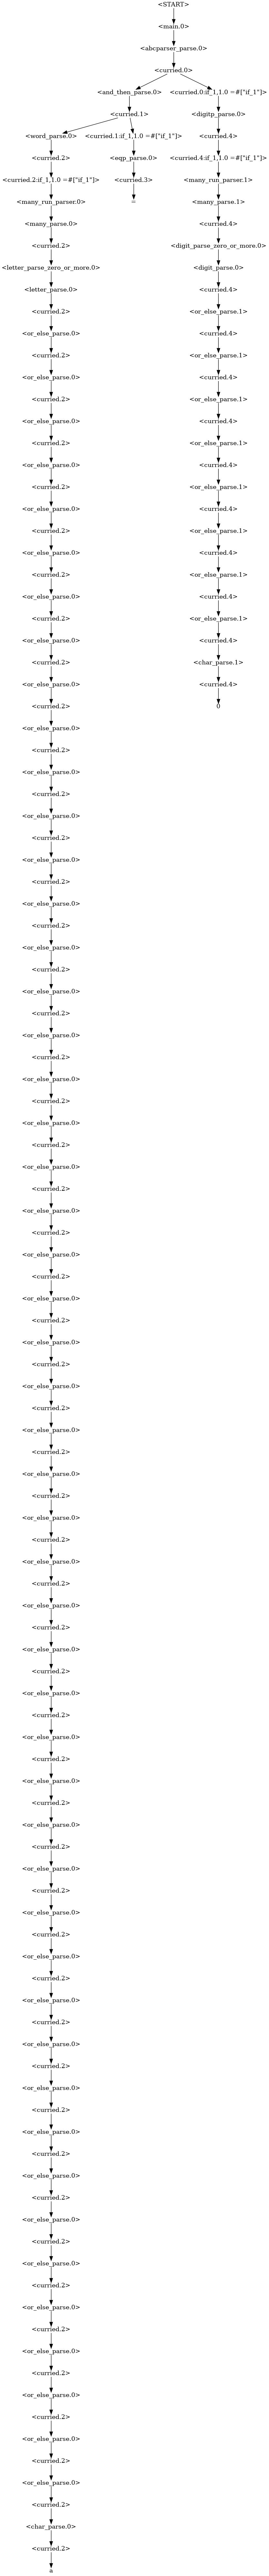

In [359]:
zoom(display_tree(parsec_trees[0]['tree'], extract_node=extract_node_o))

In [360]:
parsec_g = compact_grammar(cleanup_grammar(convert_to_grammar(parsec_trees), start_symbol='<START>'), start_symbol='<START>')

<curried.0-1> ['<curried.1-1>', '<curried.4-0-c>']
<curried.1-1> ['<curried.2-0-c>', '<curried.3-1>']
<curried.4-1> ['0']
<curried.3-1> ['=']
<digit_parse_zero_or_more.0-3> ['<curried.6-0-c>', '<digit_parse_zero_or_more.0-3-c>']
<curried.2-5> ['a']
<curried.2-9> ['e']
<curried.2-8> ['d']
<letter_parse_zero_or_more.0-3> ['<curried.5-0-c>', '<letter_parse_zero_or_more.0>']
<curried.6-3> ['3']
<curried.6-1> ['1']
<curried.6-4> ['4']
<curried.6-5> ['7']
<curried.5-9> ['z']
<curried.5-8> ['u']
<curried.5-7> ['i']


In [361]:
display_grammar_cf(parsec_g)

<START> 
	 [['<curried.2-0-c>', '=', '<curried.4-0-c>']]
<curried.2-0-c> 
	 [['<curried.2-6>'], ['<curried.2-7>'], ['<letter_parse_zero_or_more.0-0-c>'], ['a'], ['d'], ['e']]
<curried.2-6> 
	 [['b']]
<curried.2-7> 
	 [['c']]
<curried.4-0-c> 
	 [['0'], ['<curried.4-2>'], ['<curried.4-3>'], ['<digit_parse_zero_or_more.0-0-c>']]
<curried.4-2> 
	 [['2']]
<curried.4-3> 
	 [['9']]
<curried.5-0-c> 
	 [['<curried.2-6>'], ['<curried.2-7>'], ['i'], ['u'], ['z']]
<curried.6-0-c> 
	 [['1'], ['3'], ['4'], ['7'], ['<curried.4-2>'], ['<curried.4-3>']]
<digit_parse_zero_or_more.0-0-c> 
	 [['<curried.6-0-c>', '<digit_parse_zero_or_more.0-3-c>'], ['<digit_parse_zero_or_more.0-1>']]
<digit_parse_zero_or_more.0-1> 
	 [['<curried.4-0-c>'], ['<curried.4-0-c>', '<digit_parse_zero_or_more.0>']]
<digit_parse_zero_or_more.0-3-c> 
	 [['<digit_parse_zero_or_more.0-0-c>'], ['<digit_parse_zero_or_more.0>']]
<digit_parse_zero_or_more.0> 
	 [['<curried.6-0-c>'], ['<digit_parse_zero_or_more.0-0-c>']]
<letter_parse_zer

In [362]:
gf = LimitFuzzer(parsec_g)

In [363]:
for i in range(10):
    v = gf.fuzz(key='<START>')
    print(repr(v))

'bu=97'
'c=97'
'e=9'
'd=1479'
'a=2079'
'e=9'
'c=0'
'c=2'
'd=930'
'cb=9'


### A Lisp Parser

In [364]:
%%var sexpr_src
import myparsec as pyparsec
import sys
import json

alphaP = pyparsec.letters
alphaP.tag = 'alphaP'

digitP = pyparsec.digits
digitP.tag = 'digitP'

quoteP = pyparsec.char('"')
quoteP.tag = 'quoteP'
stringP = quoteP >> pyparsec.many(alphaP | digitP | pyparsec.whitespace) >> quoteP
stringP.tag = 'stringP'

idP = pyparsec.letter >> pyparsec.many(alphaP|digitP)
idP.tag = 'idP'

atomP = idP | digitP | stringP
atomP.tag = 'atomP'

openP = pyparsec.char('(')
closeP = pyparsec.char(')')
listP = pyparsec.forward(lambda:  openP >> pyparsec.sep_by(pyparsec.whitespace, pyparsec.many(sexprP)) >> closeP)
listP.tag = 'listP'
sexprP = (atomP |  listP)
sexprP.tag = 'sexprP'


def main(arg):
    v = sexprP.parse(arg)
    if isinstance(v, pyparsec.Left):
        raise Exception('parse failed')
    return v

#### The Lisp golden grammar

In [365]:
sexpr_golden = {
    '<START>': [ '<sexpr>' ],
    '<sexpr>': [ '<atom>', '<list>' ],
    '<atom>': ['<id>', '<digits>', '<string>' ],
    '<list>': [ '(<whitespace><sexprs><whitespace>)'],
    '<sexprs>': [ '', '<sexpr><space><whitespace><sexprs>'],
    '<id>': ['<letter><alphanums>'],
    '<alphanums>': [ '', '<alphanum><alphanums>'],
    '<alphanum>' : ['<letter>', '<digit>'],
    '<digit>': [i for i in string.digits],
    '<space>': [' '],
    '<whitespace>' : ['', '<space><whitespace>'],
    '<letter>' : [i for i in string.ascii_letters],
    '<digits>': ['<digit>', '<digit>''<digits>'],
    '<sletter>': ['<space>', '<digit>', '<letter>'],
    '<sletters>': ['', '<sletter><sletters>'],
    '<string>': ['"<sletters>"']
}

In [366]:
f = LimitFuzzer(canonical(sexpr_golden))

In [367]:
sexpr_samples = list(set([f.fuzz(key='<START>') for i in range(100)]))

In [368]:
%%time
with timeit() as t:
    sexpr_grammar = accio_grammar('sexpr.py', VARS['sexpr_src'], sexpr_samples)
Mimid_t['sexpr.py'] = t.runtime

<curried.0-72> ['d']
<curried.0-46> ['<curried.11-0-c>', '<curried.12-0-c>']
<curried.0-70> ['Z']
<curried.0-68> ['S']
<curried.0-11> ['<curried.6-0-c>', '<curried.6-0-c>']
<curried.0-74> ['t']
<curried.0-64> ['G']
<curried.0-71> ['b']
<curried.0-73> ['h']
<curried.0-66> ['L']
<curried.0-65> ['J']
<curried.0-9> ['<curried.1-0-c>', '<curried.8-1>']
<curried.8-1> [')']
<curried.6-1> ['"']
<curried.9-2> ['1']
<digit_parse_zero_or_more.1-1> ['<curried.7-0-c>', '<digit_parse_zero_or_more.0>']
<and_then_parse_zero_or_more.0-2> ['<curried.4-0-c>', '<and_then_parse_zero_or_more.0-2-c>']
<curried.12-9> ['W']
<digit_parse_zero_or_more.0-3> ['<digit_parse.1-0-c>', '<digit_parse_zero_or_more.0-3-c>']
<curried.12-8> ['M']
<or_else_parse_zero_or_more.1-8> ['<curried.9-0-c>', '<or_else_parse_zero_or_more.1>']
<or_else_parse_zero_or_more.1-5> ['<curried.7-0-c>', '<or_else_parse_zero_or_more.1>']
<or_else_parse_zero_or_more.1-1> ['<curried.13-0-c>', '<or_else_parse_zero_or_more.3-1>']
<or_else_parse_ze

In [369]:
save_grammar(sexpr_grammar, 'mimid', 'sexpr')

{'<START>': ['<curried.0-0-c>'],
 '<curried.0-0-c>': ['<curried.0-1>',
  '<curried.0-2>',
  '<curried.0-3>',
  '<curried.0-4>',
  '<curried.0-5>',
  '<curried.0-63>',
  '<curried.0-67>',
  '<curried.0-69>',
  '<curried.0-6>',
  '<curried.0-7>',
  '<curried.0-8>',
  '<curried.1-0-c>)',
  '<curried.11-0-c><curried.12-0-c>',
  '<curried.6-0-c><curried.6-0-c>',
  '<digit_parse_zero_or_more.0-0-c>',
  '<digit_parse_zero_or_more.1-0-c>',
  '<letter_parse.1-0-c>',
  '<or_else_parse.11-0-c>',
  'G',
  'J',
  'L',
  'S',
  'Z',
  'b',
  'd',
  'h',
  't'],
 '<curried.0-1>': ['0'],
 '<curried.0-2>': ['3'],
 '<curried.0-3>': ['5'],
 '<curried.0-4>': ['6'],
 '<curried.0-5>': ['7'],
 '<curried.0-63>': ['E'],
 '<curried.0-67>': ['P'],
 '<curried.0-69>': ['Y'],
 '<curried.0-6>': ['8'],
 '<curried.0-7>': ['9'],
 '<curried.0-8>': ['<curried.0-0-c>',
  '<digitP_parse.1-0-c>',
  '<letter_parse.1-0-c>',
  '<many_run_parser.1-0-c>',
  '<or_else_parse.11-0-c>'],
 '<curried.1-0-c>': ['<curried.1-1>', '<curri

In [370]:
#if 'sexpr' in CHECK:
result = check_precision('sexpr.py', sexpr_grammar)
Mimid_p['sexpr.py'] = result
print(result)

(997, 1000)


In [371]:
import subjects.sexpr

In [372]:
#if 'sexpr' in CHECK:
result = check_recall(sexpr_golden, sexpr_grammar, subjects.sexpr.main)
Mimid_r['sexpr.py'] = result
print(result)

(830, 1000)


## Parsing with PEG Parser

In [373]:
%%var peg_src
import re
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

def canonical(grammar, letters=False):
    def split(expansion):
        if isinstance(expansion, tuple): expansion = expansion[0]
        return [token for token in re.split(RE_NONTERMINAL, expansion) if token]
    def tokenize(word): return list(word) if letters else [word]
    def canonical_expr(expression):
        return [token for word in split(expression)
            for token in ([word] if word in grammar else tokenize(word))]
    return {k: [canonical_expr(expression) for expression in alternatives]
        for k, alternatives in grammar.items()}

def crange(character_start, character_end):
    return [chr(i) for i in range(ord(character_start), ord(character_end) + 1)]

def unify_key(grammar, key, text, at=0):
    if key not in grammar:
        if text[at:].startswith(key):
            return at + len(key), (key, [])
        else:
            return at, None
    for rule in grammar[key]:
        to, res = unify_rule(grammar, rule, text, at)
        if res:
            return (to, (key, res))
    return 0, None

def unify_rule(grammar, rule, text, at):
    results = []
    for token in rule:
        at, res = unify_key(grammar, token, text, at)
        if res is None:
            return at, None
        results.append(res)
    return at, results

import string
VAR_GRAMMAR = {
    '<start>': ['<assignment>'],
    '<assignment>': ['<identifier>=<expr>'],
    '<identifier>': ['<word>'],
    '<word>': ['<alpha><word>', '<alpha>'],
    '<alpha>': list(string.ascii_letters),
    '<expr>': ['<term>+<expr>', '<term>-<expr>', '<term>'],
    '<term>': ['<factor>*<term>', '<factor>/<term>', '<factor>'],
    '<factor>': ['+<factor>', '-<factor>', '(<expr>)', '<identifier>', '<number>'],
    '<number>': ['<integer>.<integer>', '<integer>'],
    '<integer>': ['<digit><integer>', '<digit>'],
    '<digit>': crange('0', '9')
}
def main(arg):
    C_VG = canonical(VAR_GRAMMAR)
    at, result = unify_key(C_VG, '<start>', arg)
    if result is None:
        raise Exception('Not parsed')
    return result

In [374]:
%%var config_src
# [(
import urllib.parse
# This is useful for parsers such as PEG where the argument
# is important as the name of the non-terminal.
ENCODE_ARGS = True
def encode_method_name(name, my_args):
    if not ENCODE_ARGS: return name
    if not my_args: return name
    if len(my_args) == 1: return name
    #return "%s_%s_" % (name, urllib.parse.quote('_'.join([i if isinstance(i, str) else str(i) for i in my_args])))
    return "%s_%s_" % (name, urllib.parse.quote(str(my_args[1])))
# )]

In [375]:
with open('build/config.py', 'w+') as f:
    print(VARS['config_src'], file=f)

### PEG samples

In [376]:
peg_samples = [
    'a=0',
    'ab=0',
    'bbc=4491123',
    'b=2',
    'zuui=2',
    'c=9',
    'd=012',
    'e=79',
]

In [377]:
peg_trees = accio_tree('peg.py', VARS['peg_src'], peg_samples, False)

In [378]:
def extract_node_unquote(node, id):
    symbol, children, *annotation = node
    if (symbol[0], symbol[-1]) == ('<', '>'):
        symbol = "<%s>" % urllib.parse.unquote(symbol[1:-2])
    return symbol, children, ''.join(str(a) for a in annotation)

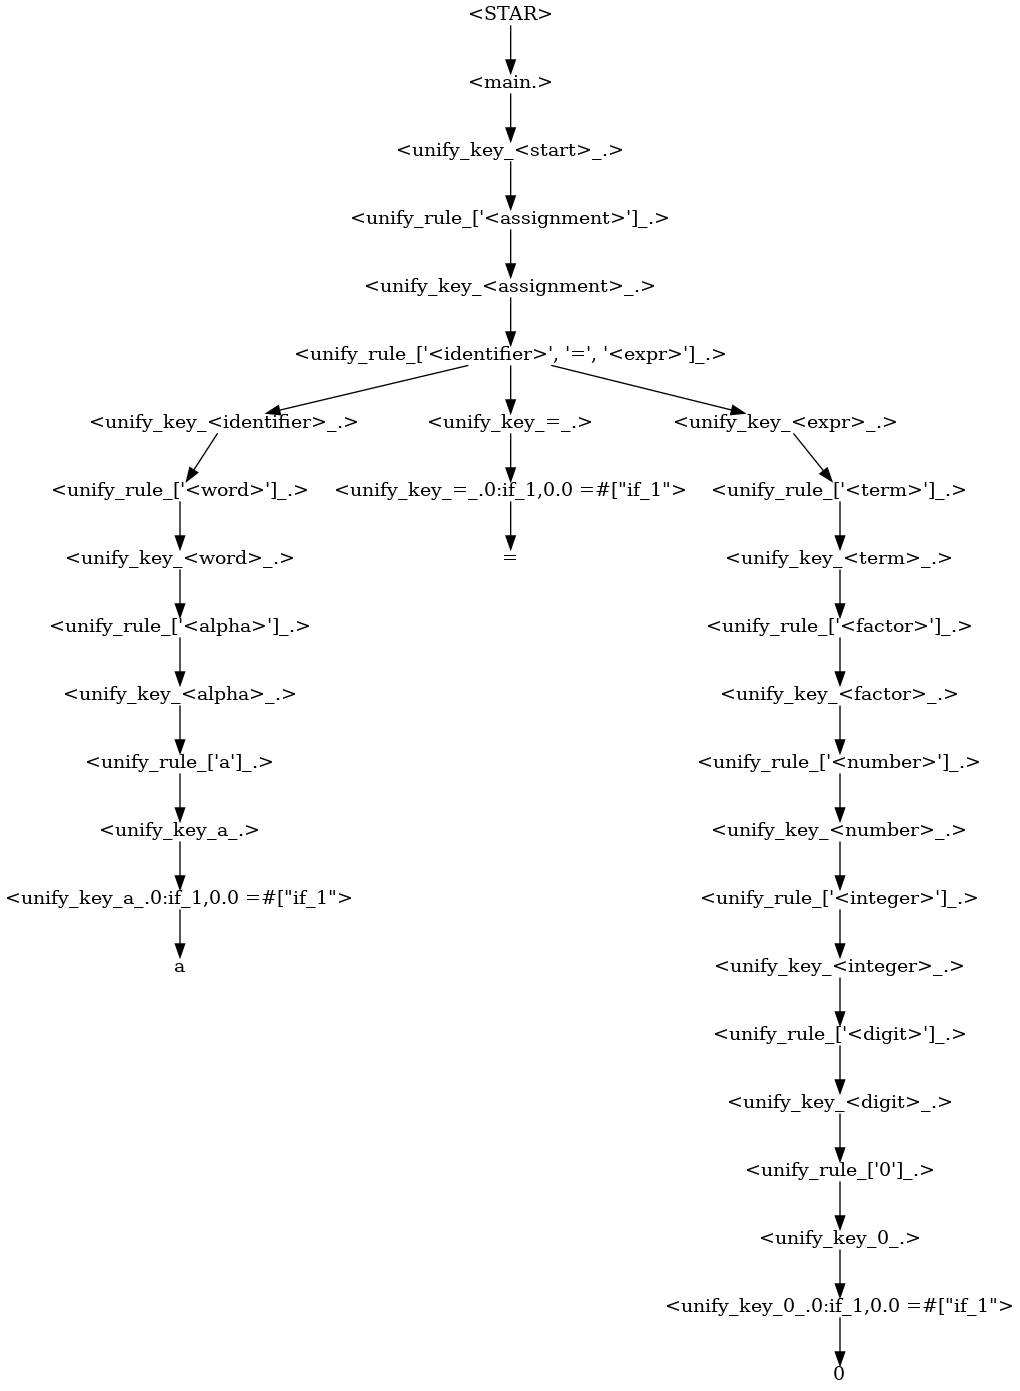

In [379]:
zoom(display_tree(peg_trees[0]['tree'], extract_node=extract_node_unquote))

In [380]:
def clean_peg(g):
    def rep(r):
         return r.replace('<unify_key_%3C', '<').replace('%3E_',':').replace('<unify_rule_%3C', '<')
    g_ = {}
    for k in g:
        rs = []
        for r in g[k]:
            r_ = []
            for t in r:
                t_ = rep(t)
                r_.append(t_)
            rs.append(r_)
        g_[rep(k)] = rs
    return g_

In [381]:
peg_g1 = clean_peg(compact_grammar(cleanup_grammar(convert_to_grammar(peg_trees), start_symbol='<START>'), start_symbol='<START>'))

<unify_rule_%5B%27%3Cidentifier%3E%27%2C%20%27%3D%27%2C%20%27%3Cexpr%3E%27%5D_.0-1> ['<unify_key_%3Cword%3E_.0-0-c>', '<unify_rule_%5B%27%3Cidentifier%3E%27%2C%20%27%3D%27%2C%20%27%3Cexpr%3E%27%5D_.0-2>']
<unify_rule_%5B%27%3Cidentifier%3E%27%2C%20%27%3D%27%2C%20%27%3Cexpr%3E%27%5D_.0-2> ['<unify_key_%3D_.0>', '<unify_key_%3Cinteger%3E_.0-0-c>']
<unify_rule_%5B%27%3Calpha%3E%27%2C%20%27%3Cword%3E%27%5D_.0-1> ['<unify_key_%3Calpha%3E_.0-0-c>', '<unify_key_%3Cword%3E_.0-0-c>']
<unify_key_%3D_.0> ['=']
<unify_rule_%5B%27%3Cdigit%3E%27%2C%20%27%3Cinteger%3E%27%5D_.0-1> ['<unify_key_%3Cdigit%3E_.0-0-c>', '<unify_key_%3Cinteger%3E_.0-0-c>']
<unify_key_a_.0> ['a']
<unify_key_c_.0> ['c']
<unify_key_i_.0> ['i']
<unify_key_u_.0> ['u']
<unify_key_d_.0> ['d']
<unify_key_b_.0> ['b']
<unify_key_z_.0> ['z']
<unify_key_e_.0> ['e']
<unify_key_0_.0> ['0']
<unify_key_4_.0> ['4']
<unify_key_7_.0> ['7']
<unify_key_9_.0> ['9']
<unify_key_1_.0> ['1']
<unify_key_2_.0> ['2']
<unify_key_3_.0> ['3']


In [382]:
display_grammar_cf(peg_g1)

<START> 
	 [['<word:.0-0-c>', '=', '<integer:.0-0-c>']]
<alpha:.0-0-c> 
	 [['a'], ['b'], ['c'], ['d'], ['e'], ['i'], ['u'], ['z']]
<digit:.0-0-c> 
	 [['0'], ['1'], ['2'], ['3'], ['4'], ['7'], ['9']]
<integer:.0-0-c> 
	 [['<digit:.0-0-c>'], ['<digit:.0-0-c>', '<integer:.0-0-c>']]
<word:.0-0-c> 
	 [['<alpha:.0-0-c>'], ['<alpha:.0-0-c>', '<word:.0-0-c>']]


In [383]:
gf = LimitFuzzer(peg_g1)

In [384]:
for i in range(100):
    v = gf.fuzz(key='<START>')
    print(repr(v))

'b=277'
'zbd=19'
'a=9'
'bzizu=0279'
'd=1'
'czzd=04'
'u=9'
'c=932'
'zczz=77'
'd=00'
'a=7'
'czduc=137'
'z=3'
'z=213'
'c=7'
'b=1'
'iaa=29'
'z=4'
'z=2727'
'z=24'
'b=1'
'z=7'
'c=2'
'cb=22'
'bb=9'
'ibaaz=24'
'aa=0174'
'z=230'
'a=1247'
'a=7047'
'i=0910'
'za=427779'
'u=7'
'c=93'
'ua=9440'
'c=740724'
'zi=7'
'b=4'
'eb=1'
'zzcb=2'
'z=0'
'i=7'
'ea=2'
'i=3'
'd=001'
'bucbz=207'
'ui=34'
'z=07'
'a=7700'
'c=9'
'b=739'
'd=03'
'b=43'
'e=1'
'id=731'
'ce=3'
'da=9'
'a=772'
'a=4'
'icu=1292'
'c=2'
'aei=1'
'ui=9'
'ubcce=1'
'uc=1'
'z=77'
'iuuicd=704'
'au=1'
'eu=2'
'c=11079'
'du=9923'
'i=291'
'e=03'
'a=743417'
'ab=3'
'zeuz=43'
'i=1'
'ez=24'
'b=79'
'z=4431933003'
'dzii=400'
'du=4'
'b=4'
'ui=1'
'c=0'
'ez=2'
'a=2'
'z=24'
'cz=3'
'u=3'
'bd=43'
'b=99'
'cub=3'
'u=9'
'zad=3'
'b=07'
'bb=90'
'bb=4'
'cd=71'
'u=12'


# Limitations

## Limitation due to context sensitivity

In [385]:
fail_msamples=[i.strip() for i in '''
x
exp(0)
e
'''.strip().split('\n') if i.strip()]

In [386]:
for j, i in enumerate(fail_msamples):
    print(j, repr(i), do(['python3', 'build/check.py','subjects/mathexpr.py', i]).returncode)

0 'x' 0
1 'exp(0)' 0
2 'e' 0


In [387]:
fail_msample_files = {("samples/%s/%d_fail.csv"%('mathexpr.py',i)):s for i,s in enumerate(fail_msamples)}
for k in fail_msample_files:
    with open(k, 'w+') as f:
        print(fail_msample_files[k], file=f)

In [388]:
fail_mcall_trace = []
for i in fail_msample_files:
    my_tree = do(["python3", "./build/%s" % 'mathexpr.py', i]).stdout
    fail_mcall_trace.append(json.loads(my_tree)[0])

In [389]:
fail_mined_tree = miner(fail_mcall_trace)

In [390]:
reset_generalizer()

In [391]:
fail_gmtree = generalize_method_trees(fail_mined_tree)

In [392]:
reset_generalizer()

In [393]:
fail_gltree = generalize_loop_trees(fail_gmtree)

In [394]:
from fuzzingbook.Parser import highlight_node

In [395]:
def fail_hl(dot, nid, symbol, ann):
    return symbol == '<parseVariable.0:while_1,0 =#["loop_1"]>'

In [396]:
highlight_fail_node = highlight_node(fail_hl)

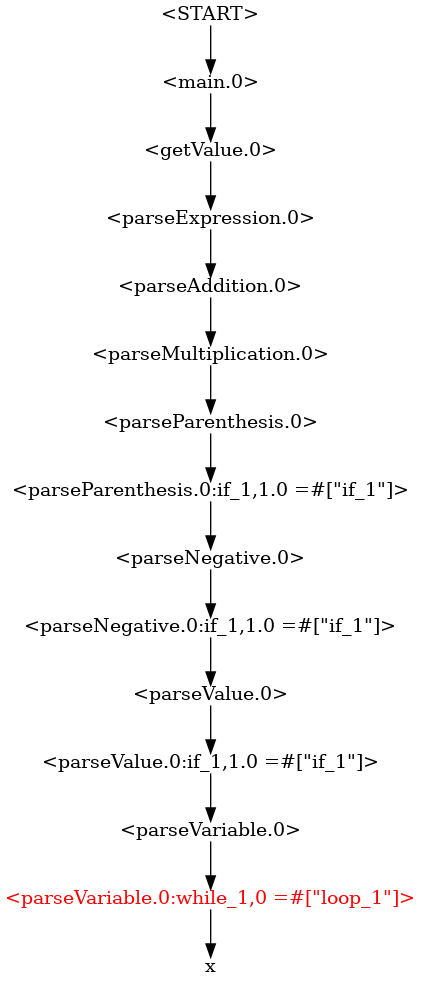

In [397]:
zoom(display_tree(fail_gltree[0]['tree'], node_attr=highlight_fail_node))

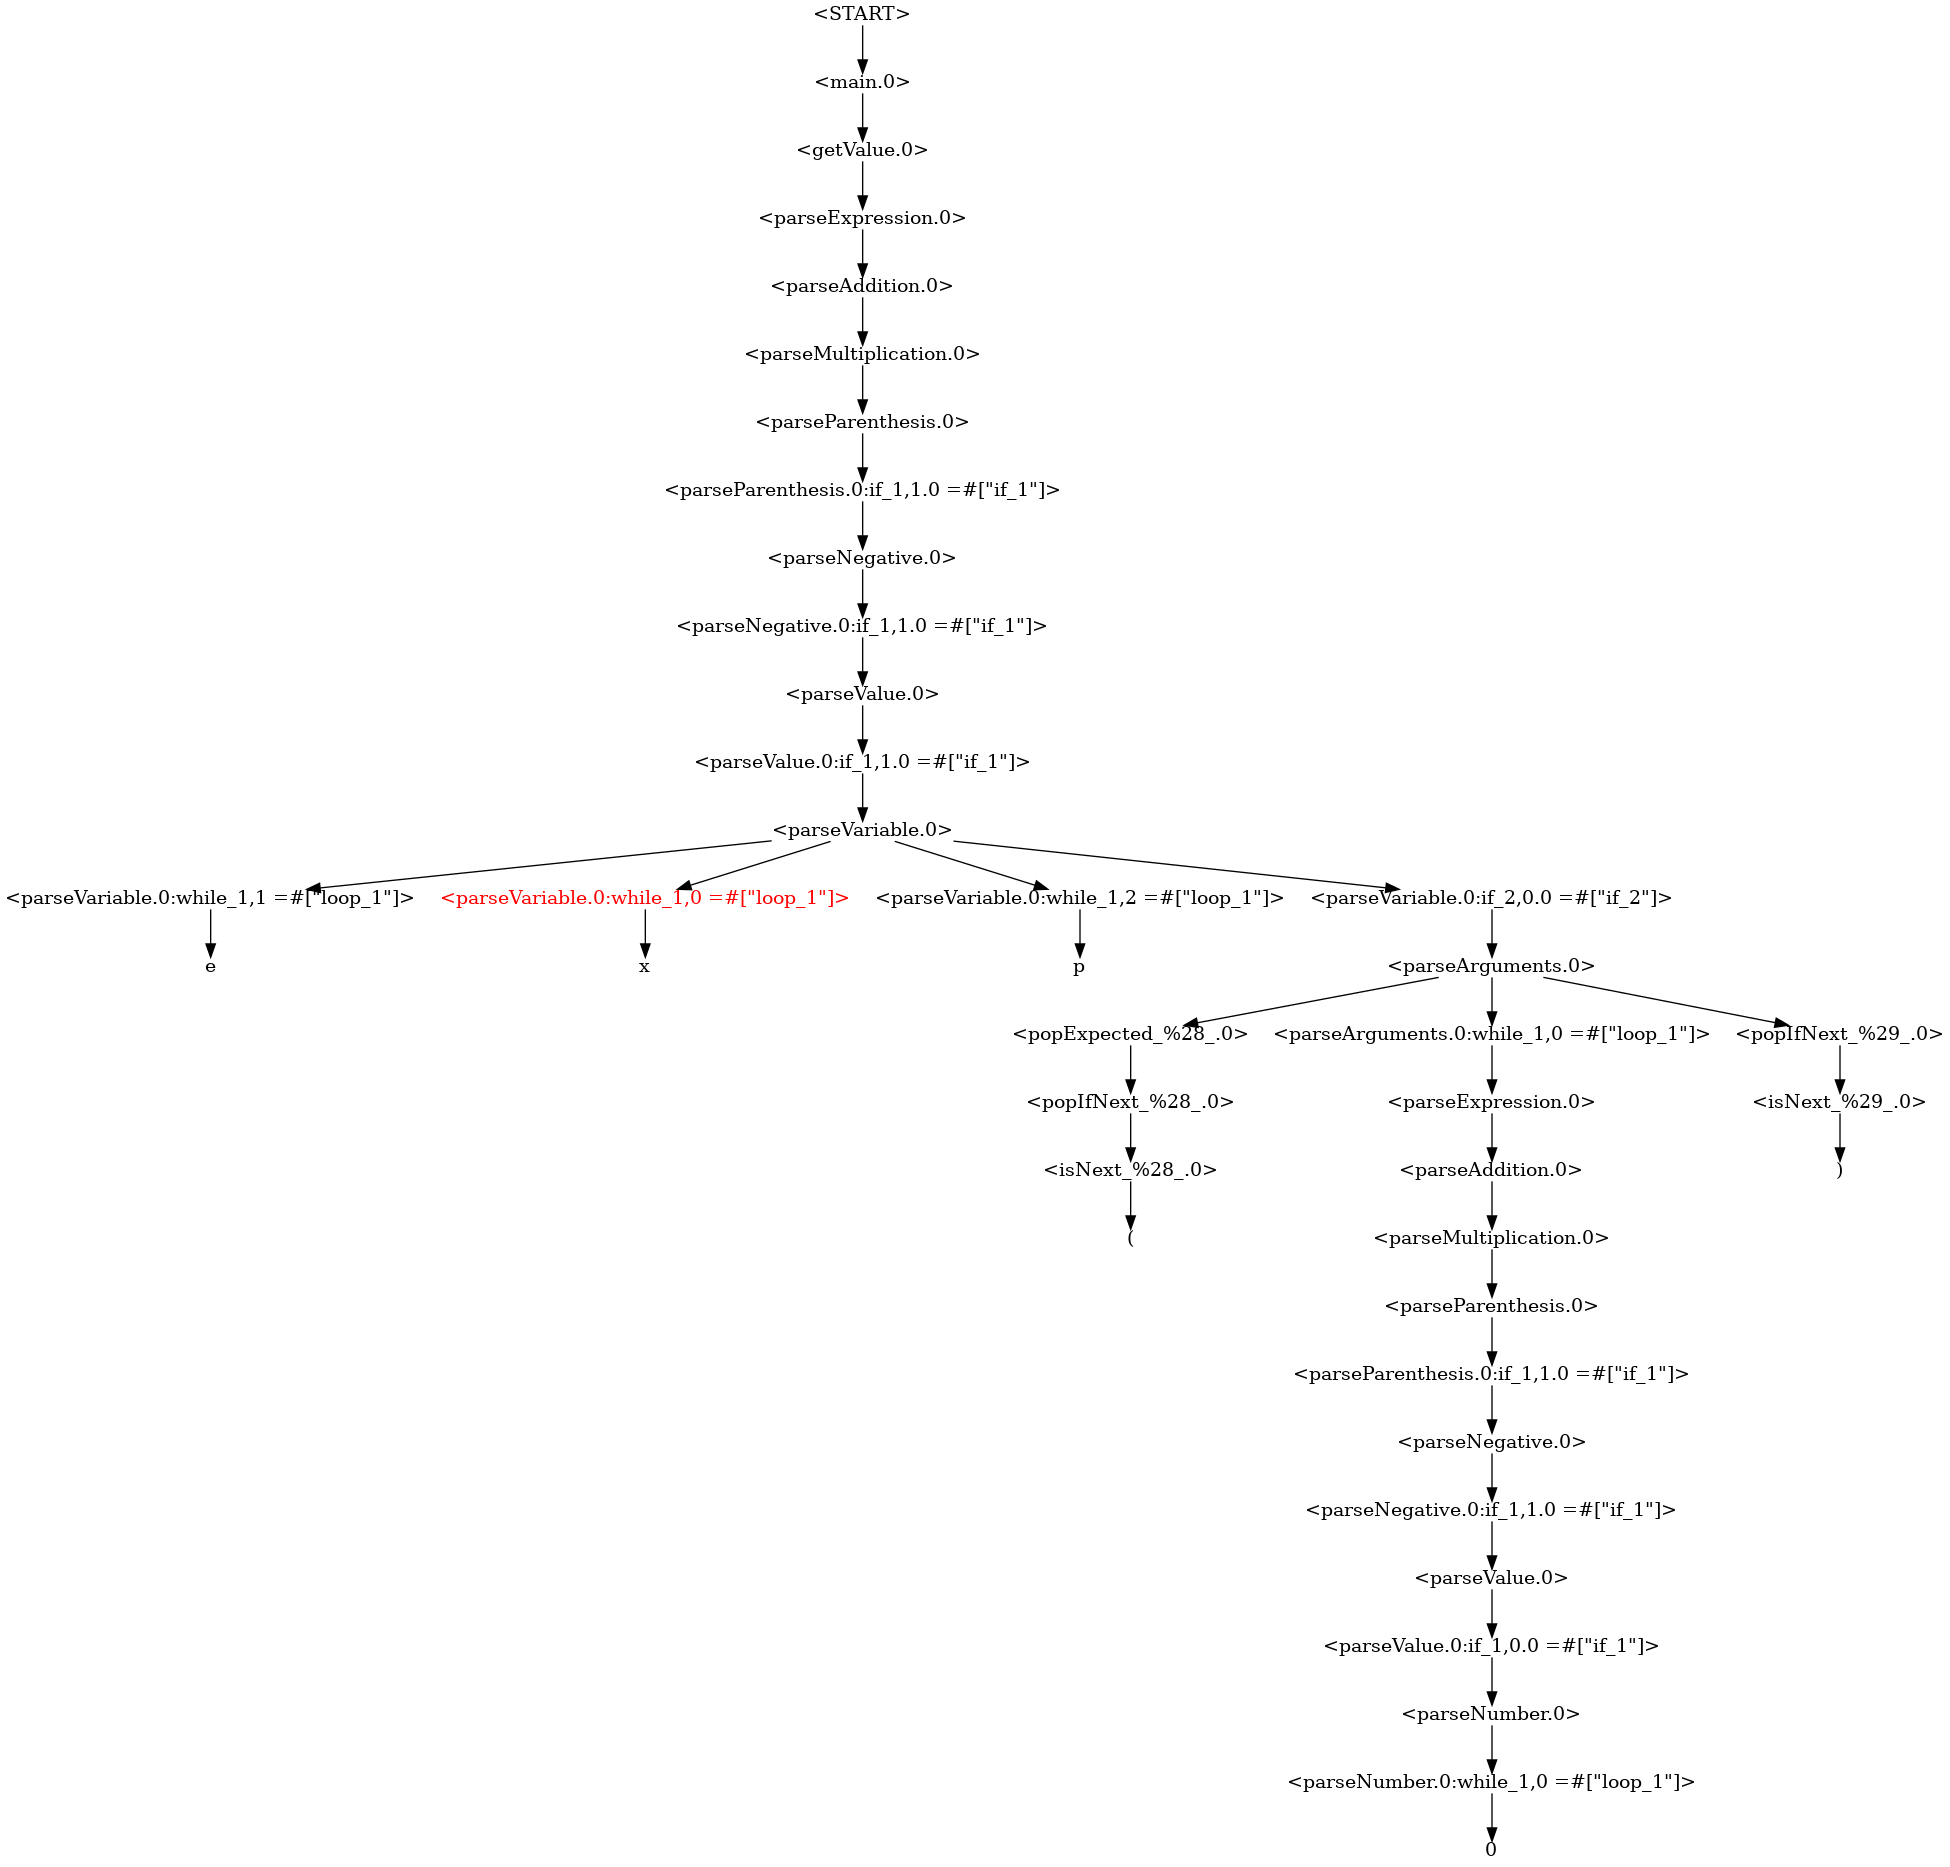

In [398]:
zoom(display_tree(fail_gltree[1]['tree'], node_attr=highlight_fail_node))

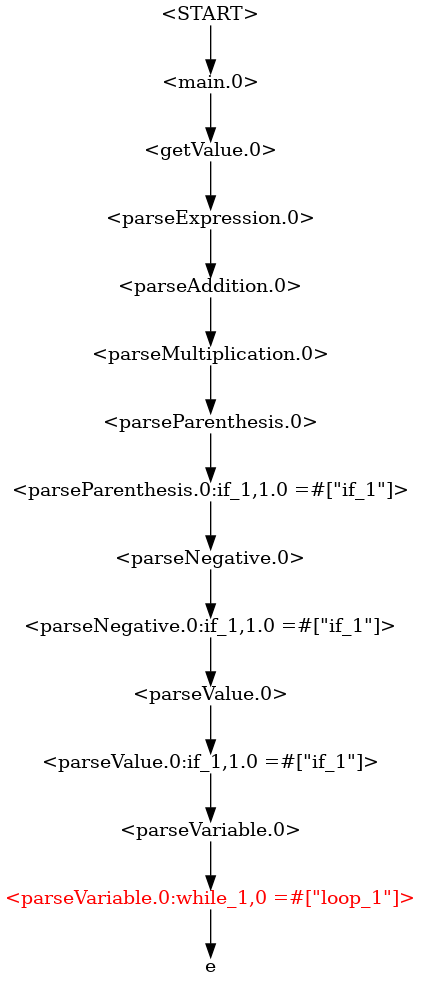

In [399]:
zoom(display_tree(fail_gltree[2]['tree'], node_attr=highlight_fail_node))

In [400]:
reset_generalizer()

In [401]:
fail_g = convert_to_grammar(fail_gltree)

In [402]:
for k in sorted(fail_g.keys()):
    print(k)
    for r in sorted(fail_g[k]):
        print('\t',repr(''.join(r)))
    print()

<START>
	 '<main.0>'

<getValue.0>
	 '<parseExpression.0>'

<isNext_%28_.0>
	 '('

<isNext_%29_.0>
	 ')'

<main.0>
	 '<getValue.0>'

<parseAddition.0>
	 '<parseMultiplication.0>'

<parseArguments.0:while_1,0 =#["loop_1"]>
	 '<parseExpression.0>'

<parseArguments.0>
	 '<popExpected_%28_.0><parseArguments.0:while_1,0 =#["loop_1"]><popIfNext_%29_.0>'

<parseExpression.0>
	 '<parseAddition.0>'

<parseMultiplication.0>
	 '<parseParenthesis.0>'

<parseNegative.0:if_1,1.0 =#["if_1"]>
	 '<parseValue.0>'

<parseNegative.0>
	 '<parseNegative.0:if_1,1.0 =#["if_1"]>'

<parseNumber.0:while_1,0 =#["loop_1"]>
	 '0'

<parseNumber.0>
	 '<parseNumber.0:while_1,0 =#["loop_1"]>'

<parseParenthesis.0:if_1,1.0 =#["if_1"]>
	 '<parseNegative.0>'

<parseParenthesis.0>
	 '<parseParenthesis.0:if_1,1.0 =#["if_1"]>'

<parseValue.0:if_1,0.0 =#["if_1"]>
	 '<parseNumber.0>'

<parseValue.0:if_1,1.0 =#["if_1"]>
	 '<parseVariable.0>'

<parseValue.0>
	 '<parseValue.0:if_1,0.0 =#["if_1"]>'
	 '<parseValue.0:if_1,1.0 =#["if

In [403]:
gf = LimitFuzzer(fail_g)

In [404]:
for i in range(10):
    print(repr(gf.fuzz(key='<START>')))

'0'
'0'
'0'
'0'
'0'
'0'
'0'
'0'
'0'
'0'


## Limit due to re-parsing

In [405]:
fail_usamples=[i.strip() for i in '''
https://host/folder
https://host/folder?s=q
https://host/folder#f
'''.strip().split('\n') if i.strip()]

In [406]:
for j, i in enumerate(fail_usamples):
    print(j, repr(i), do(['python3', 'build/check.py','subjects/urlparse.py', i]).returncode)

0 'https://host/folder' 0
1 'https://host/folder?s=q' 0
2 'https://host/folder#f' 0


In [407]:
fail_usample_files = {("samples/%s/%d_fail.csv"%('urlparse.py',i)):s for i,s in enumerate(fail_usamples)}
for k in fail_usample_files:
    with open(k, 'w+') as f:
        print(fail_usample_files[k], file=f)

In [408]:
fail_ucall_trace = []
for i in fail_usample_files:
    my_tree = do(["python3", "./build/%s" % 'urlparse.py', i]).stdout
    fail_ucall_trace.append(json.loads(my_tree)[0])

In [409]:
fail_mined_tree = miner(fail_ucall_trace)

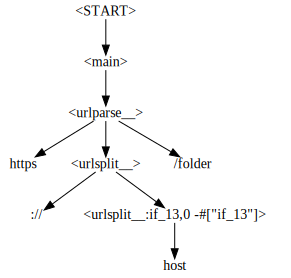

In [410]:
display_tree(fail_mined_tree[0]['tree'])

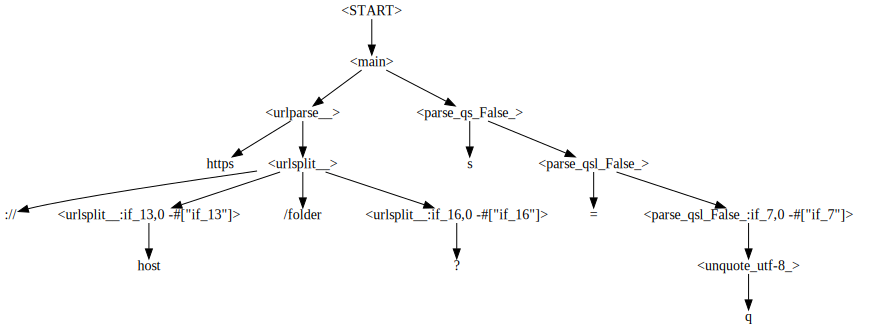

In [411]:
display_tree(fail_mined_tree[1]['tree'])

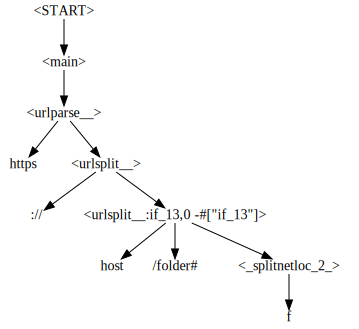

In [412]:
display_tree(fail_mined_tree[2]['tree'])